# Data preparing

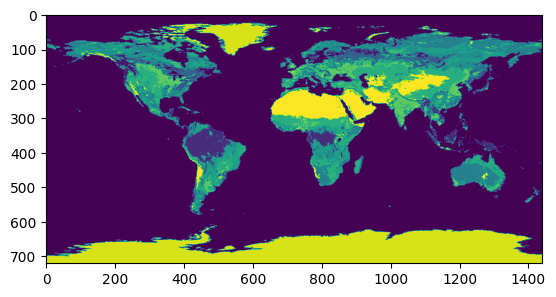

In [1]:
import numpy as np
land_cover = np.load('constant_masks/land_cover.npy')
soil_type = np.load('constant_masks/soil_type.npy')
topography_ocean = np.load('constant_masks/topography_ocean.npy')
topography = np.load('constant_masks/topography.npy')
import matplotlib.pyplot as plt
plt.imshow(land_cover)

Input tensor shape: torch.Size([1, 4, 721, 1440])
Output tensor shape: torch.Size([1, 96, 181, 360])


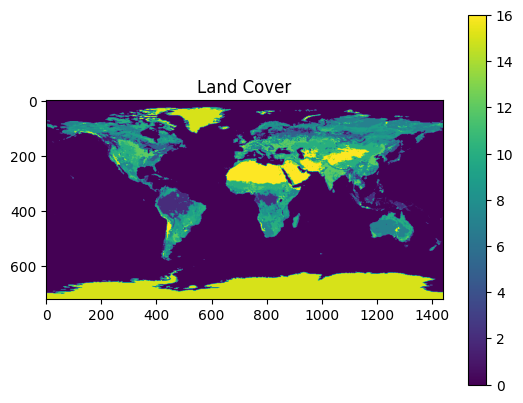

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

input_tensor = torch.load('constant_masks/input_tensor.pt', weights_only=False)


# 打印输入张量形状
print("Input tensor shape:", input_tensor.shape)

# 定义卷积层
# 输入通道数 = 4，输出通道数 = 96，卷积核大小 = 5x5，步长 = 4
conv_layer = nn.Conv2d(in_channels=4, out_channels=96, kernel_size=5, stride=4, padding=2)

# 执行卷积操作
output_tensor = conv_layer(input_tensor)

# 打印输出张量形状
print("Output tensor shape:", output_tensor.shape)

# 将输出转换为 NumPy 数组（如果需要进一步处理）
output_array = output_tensor.detach().numpy()

# 可视化输入 land_cover 栅格
plt.imshow(land_cover, cmap='viridis')
plt.colorbar()
plt.title('Land Cover')
plt.show()

# Canglong - origin

In [1]:
import torch
from torch import nn
import numpy as np
from timm.layers import trunc_normal_, DropPath
import torch.nn.functional as F
import sys
sys.path.append('..')
from canglong.earth_position import calculate_position_bias_indices
from canglong.shift_window import create_shifted_window_mask, partition_windows, reverse_partition
from canglong.embed import ImageToPatch2D, ImageToPatch3D, ImageToPatch4D
from canglong.recovery import RecoveryImage2D, RecoveryImage3D, RecoveryImage4D
from canglong.pad import calculate_padding_3d, calculate_padding_2d
from canglong.crop import center_crop_2d, center_crop_3d
input_constant = torch.load('constant_masks/Earth.pt', weights_only=True).cuda()

class UpSample(nn.Module):
    """
    Up-sampling operation.
    """

    def __init__(self, in_dim, out_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim * 4, bias=False)
        self.linear2 = nn.Linear(out_dim, out_dim, bias=False)
        self.norm = nn.LayerNorm(out_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

    def forward(self, x: torch.Tensor):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        x = self.linear1(x)
        x = x.reshape(B, in_pl, in_lat, in_lon, 2, 2, C // 2).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, in_pl, in_lat * 2, in_lon * 2, -1)

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        pad_h = in_lat * 2 - out_lat
        pad_w = in_lon * 2 - out_lon

        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top

        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        x = x[:, :out_pl, pad_top: 2 * in_lat - pad_bottom, pad_left: 2 * in_lon - pad_right, :]
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3], x.shape[4])
        x = self.norm(x)
        x = self.linear2(x)
        return x


class DownSample(nn.Module):
    """
    Down-sampling operation
    """

    def __init__(self, in_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear = nn.Linear(in_dim * 4, in_dim * 2, bias=False)
        self.norm = nn.LayerNorm(4 * in_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        h_pad = out_lat * 2 - in_lat
        w_pad = out_lon * 2 - in_lon

        pad_top = h_pad // 2
        pad_bottom = h_pad - pad_top

        pad_left = w_pad // 2
        pad_right = w_pad - pad_left

        pad_front = pad_back = 0

        self.pad = nn.ZeroPad3d(
            (pad_left, pad_right, pad_top, pad_bottom, pad_front, pad_back)
        )

    def forward(self, x):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution
        x = x.reshape(B, in_pl, in_lat, in_lon, C)

        x = self.pad(x.permute(0, -1, 1, 2, 3)).permute(0, 2, 3, 4, 1)
        x = x.reshape(B, in_pl, out_lat, 2, out_lon, 2, C).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, out_pl * out_lat * out_lon, 4 * C)

        x = self.norm(x)
        x = self.linear(x)
        return x


class EarthAttention3D(nn.Module):
    """
    3D window attention with earth position bias.
    """

    def __init__(self, dim, input_resolution, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0.,
                 proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.type_of_windows = (input_resolution[0] // window_size[0]) * (input_resolution[1] // window_size[1])

        self.earth_position_bias_table = nn.Parameter(
            torch.zeros((window_size[0] ** 2) * (window_size[1] ** 2) * (window_size[2] * 2 - 1),
                        self.type_of_windows, num_heads)
        )

        earth_position_index = calculate_position_bias_indices(window_size)
        self.register_buffer("earth_position_index", earth_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.earth_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x: torch.Tensor, mask=None):
        B_, nW_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, nW_, N, 3, self.num_heads, C // self.num_heads).permute(3, 0, 4, 1, 2, 5)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        earth_position_bias = self.earth_position_bias_table[self.earth_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1] * self.window_size[2],
            self.window_size[0] * self.window_size[1] * self.window_size[2],
            self.type_of_windows, -1
        )
        earth_position_bias = earth_position_bias.permute(
            3, 2, 0, 1).contiguous()
        attn = attn + earth_position_bias.unsqueeze(0)

        if mask is not None:
            nLon = mask.shape[0]
            attn = attn.view(B_ // nLon, nLon, self.num_heads, nW_, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, nW_, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).permute(0, 2, 3, 1, 4).reshape(B_, nW_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class EarthSpecificBlock(nn.Module):
    """
    3D Transformer Block
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=None, shift_size=None, mlp_ratio=4.,
                 qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        window_size = (2, 6, 12) if window_size is None else window_size
        shift_size = (1, 3, 6) if shift_size is None else shift_size
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = norm_layer(dim)
        padding = calculate_padding_3d(input_resolution, window_size)
        self.pad = nn.ZeroPad3d(padding)

        pad_resolution = list(input_resolution)
        pad_resolution[0] += (padding[-1] + padding[-2])
        pad_resolution[1] += (padding[2] + padding[3])
        pad_resolution[2] += (padding[0] + padding[1])

        self.attn = EarthAttention3D(
            dim=dim, input_resolution=pad_resolution, window_size=window_size, num_heads=num_heads, qkv_bias=qkv_bias,
            qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        shift_pl, shift_lat, shift_lon = self.shift_size
        self.roll = shift_pl and shift_lon and shift_lat

        if self.roll:
            attn_mask = create_shifted_window_mask(pad_resolution, window_size, shift_size)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x: torch.Tensor): #revise
        Pl, Lat, Lon = self.input_resolution
        B, L, C = x.shape
        assert L == Pl * Lat * Lon, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, Pl, Lat, Lon, C)

        x = self.pad(x.permute(0, 4, 1, 2, 3)).permute(0, 2, 3, 4, 1)

        _, Pl_pad, Lat_pad, Lon_pad, _ = x.shape

        shift_pl, shift_lat, shift_lon = self.shift_size
        if self.roll:
            shifted_x = torch.roll(x, shifts=(-shift_pl, -shift_lat, -shift_lon), dims=(1, 2, 3))
            x_windows = partition_windows(shifted_x, self.window_size)
        else:
            shifted_x = x
            x_windows = partition_windows(shifted_x, self.window_size)

        win_pl, win_lat, win_lon = self.window_size
        x_windows = x_windows.view(x_windows.shape[0], x_windows.shape[1], win_pl * win_lat * win_lon, C)

        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = attn_windows.view(attn_windows.shape[0], attn_windows.shape[1], win_pl, win_lat, win_lon, C)

        if self.roll:
            shifted_x = reverse_partition(attn_windows, self.window_size, Pl_pad, Lat_pad, Lon_pad)
            x = torch.roll(shifted_x, shifts=(shift_pl, shift_lat, shift_lon), dims=(1, 2, 3))
        else:
            shifted_x = reverse_partition(attn_windows, self.window_size, Pl_pad, Lat_pad, Lon_pad)
            x = shifted_x


        x = center_crop_3d(x.permute(0, 4, 1, 2, 3), self.input_resolution).permute(0, 2, 3, 4, 1)

        x = x.reshape(B, Pl * Lat * Lon, C)
        x = shortcut + self.drop_path(x)

        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x



class BasicLayer(nn.Module):
    """A basic 3D Transformer layer for one stage"""

    def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth

        self.blocks = nn.ModuleList([
            EarthSpecificBlock(dim=dim, input_resolution=input_resolution, num_heads=num_heads, window_size=window_size,
                               shift_size=(0, 0, 0) if i % 2 == 0 else None, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                               qk_scale=qk_scale, drop=drop, attn_drop=attn_drop,
                               drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                               norm_layer=norm_layer)
            for i in range(depth)
        ])

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x




class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x: torch.Tensor):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    
import torch
import torch.nn as nn
from canglong.helper import ResidualBlock, NonLocalBlock, DownSampleBlock, UpSampleBlock, GroupNorm, Swish

class Encoder(nn.Module):
    def __init__(self, image_channels, latent_dim):
        super(Encoder, self).__init__()
        channels = [64, 64, 64, 128, 128]
        attn_resolutions = [2]
        num_res_blocks = 1
        resolution = 256

        # 初始卷积层
        self.conv_in = nn.Conv3d(image_channels, channels[0], kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        
        # 第一层（含残差块和注意力模块）
        self.layer1 = self._make_layer(channels[0], channels[1], num_res_blocks, resolution, attn_resolutions)
        
        # 下采样与第二层
        self.downsample1 = DownSampleBlock(channels[1])
        self.layer2 = self._make_layer(channels[1], channels[2], num_res_blocks, resolution // 2, attn_resolutions)

        # Further downsampling and third layer
        self.downsample2 = DownSampleBlock(channels[2])
        self.layer3 = self._make_layer(channels[2], channels[3], num_res_blocks, resolution // 4, attn_resolutions)

        # 中间层的残差块和注意力模块
        self.mid_block1 = ResidualBlock(channels[3], channels[3])
        self.mid_block2 = ResidualBlock(channels[3], channels[3])
        
        # 输出层的归一化、激活和最终卷积层
        self.norm_out = GroupNorm(channels[3])
        self.act_out = Swish()
        self.conv_out = nn.Conv3d(channels[3], latent_dim, kernel_size=3, stride=1, padding=(1,2,1))

    def _make_layer(self, in_channels, out_channels, num_res_blocks, resolution, attn_resolutions):
        layers = []
        for _ in range(num_res_blocks):
            layers.append(ResidualBlock(in_channels, out_channels))
            in_channels = out_channels
            if resolution in attn_resolutions:
                layers.append(NonLocalBlock(in_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 初始卷积
        x = self.conv_in(x)

        # 第一层，并存储跳跃连接
        x = self.layer1(x)
        skip = x  # 保存第一层输出，用于后续跳跃连接

        # 下采样，进入第二层
        x = self.downsample1(x)
        x = self.layer2(x)

        # Further downsample and third layer
        x = self.downsample2(x)
        x = self.layer3(x)

        # 中间层的残差块和注意力模块
        x = self.mid_block1(x)
        #x = self.mid_attn(x)
        x = self.mid_block2(x)
        
        # 最终的归一化、激活和卷积输出层
        x = self.norm_out(x)
        x = self.act_out(x)
        x = self.conv_out(x)[:, :, :, :181, :360]
        
        return x
    
class Decoder(nn.Module):
    def __init__(self, image_channels=14, latent_dim=64):
        super(Decoder, self).__init__()
        channels = [128, 128, 64, 64]  # Decoder 的通道配置
        num_res_blocks = 1  # 与 Encoder 对齐

        # 初始卷积层
        self.conv_in = nn.Conv3d(latent_dim, channels[0], kernel_size=3, stride=1, padding=1)
        
        # 第一层残差块
        self.layer1 = self._make_layer(channels[0], channels[1], num_res_blocks)
        
        # 上采样和第二层残差块
        self.upsample1 = UpSampleBlock(channels[1])
        self.layer2 = self._make_layer(channels[1], channels[2], num_res_blocks)

        self.upsample2 = UpSampleBlock(channels[2])
        self.layer3 = self._make_layer(channels[2], channels[3], num_res_blocks)
        
        # 中间层的残差块
        self.mid_block1 = ResidualBlock(channels[3], channels[3])
        self.mid_block2 = ResidualBlock(channels[3], channels[3])
        
        # 最终输出层
        self.norm_out = GroupNorm(channels[3])
        self.act_out = Swish()
        self.conv_out = nn.ConvTranspose3d(channels[3], image_channels, kernel_size=(2, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))

    def _make_layer(self, in_channels, out_channels, num_res_blocks):
        # 创建指定数量的残差块
        layers = [ResidualBlock(in_channels, out_channels) for _ in range(num_res_blocks)]
        return nn.Sequential(*layers)

    def forward(self, x):
        # 初始卷积
        x = self.conv_in(x)

        # 第一层残差块
        x = self.layer1(x)

        # 上采样和第二层残差块
        x = self.upsample1(x)  # 上采样后通道数保持不变

        x = self.layer2(x)     # 确保输入与 layer2 的期望通道数匹配

        x = self.upsample2(x)  # 上采样后通道数保持不变

        x = self.layer3(x)     # 确保输入与 layer2 的期望通道数匹配
        
        # 中间层的残差块
        x = self.mid_block1(x)
        x = self.mid_block2(x)
        
        # 最终的归一化、激活和卷积输出层
        x = self.norm_out(x)
        x = self.act_out(x)

        x = self.conv_out(x)[:, :, :, :721, :1440]
        
        return x



    
class Canglong(nn.Module):
    """
    CAS Canglong PyTorch impl of: `CAS-Canglong: A skillful 3D Transformer model for sub-seasonal to seasonal global sea surface temperature prediction`
    """

    def __init__(self, embed_dim=96, num_heads=(8, 16, 16, 8), window_size=(2, 6, 12)):
        super().__init__()
        drop_path = np.linspace(0, 0.2, 8).tolist()
        self.patchembed2d = ImageToPatch2D(
            img_dims=(721, 1440),
            patch_dims=(4, 4), # 8, 8
            in_channels=4,
            out_channels=embed_dim,
        )
        self.patchembed3d = ImageToPatch3D(
            img_dims=(14, 721, 1440),
            patch_dims=(1, 4, 4),
            in_channels=14,
            out_channels=embed_dim
        )
        self.patchembed4d = ImageToPatch4D(
            img_dims=(7, 5, 2, 721, 1440),
            patch_dims=(2, 2, 4, 4),
            in_channels=7,
            out_channels=embed_dim
        )
        self.encoder3d = Encoder(image_channels=17, latent_dim=96)

        self.layer1 = BasicLayer(
            dim=embed_dim,
            input_resolution=(6, 181, 360),
            depth=2,
            num_heads=num_heads[0],
            window_size=window_size,
            drop_path=drop_path[:2]
        )
        self.downsample = DownSample(in_dim=embed_dim, input_resolution=(6, 181, 360), output_resolution=(6, 91, 180))
        self.layer2 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(6, 91, 180),
            depth=6,
            num_heads=num_heads[1],
            window_size=window_size,
            drop_path=drop_path[2:]
        )
        self.layer3 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(6, 91, 180),
            depth=6,
            num_heads=num_heads[2],
            window_size=window_size,
            drop_path=drop_path[2:]
        )
        self.upsample = UpSample(embed_dim * 2, embed_dim, (6, 91, 180), (6, 181, 360))
        self.layer4 = BasicLayer(
            dim=embed_dim,
            input_resolution=(6, 181, 360),
            depth=2,
            num_heads=num_heads[3],
            window_size=window_size,
            drop_path=drop_path[:2]
        )
        self.patchrecovery2d = RecoveryImage2D((721, 1440), (4, 4), 2 * embed_dim, 4) #8, 8
        self.decoder3d = Decoder(image_channels=17, latent_dim=2 * 96)
        self.patchrecovery3d = RecoveryImage3D(image_size=(16, 721, 1440), 
                                               patch_size=(1, 4, 4), 
                                               input_channels=2 * embed_dim, 
                                               output_channels=16) #2, 8, 8
        self.patchrecovery4d = RecoveryImage4D(image_size=(7, 5, 1, 721, 1440), 
                                               patch_size=(2, 1, 4, 4), 
                                               input_channels=2 * embed_dim, 
                                               output_channels=7,
                                               target_size=(7, 5, 1, 721, 1440))
        

        self.conv_constant = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=5, stride=4, padding=2)
        self.input_constant = input_constant


    def forward(self, surface, upper_air):        
        
        constant = self.conv_constant(self.input_constant)
        surface = self.encoder3d(surface)

        upper_air = self.patchembed4d(upper_air)
        
        x = torch.concat([upper_air.squeeze(3), 
                          surface, 
                          constant.unsqueeze(2)], dim=2)
        
        B, C, Pl, Lat, Lon = x.shape

        x = x.reshape(B, C, -1).transpose(1, 2)
        
        x = self.layer1(x) #revise

        skip = x

        x = self.downsample(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.upsample(x)
        x = self.layer4(x)

        output = torch.concat([x, skip], dim=-1)
        output = output.transpose(1, 2).reshape(B, -1, Pl, Lat, Lon)
        output_surface = output[:, :, 3:5, :, :]  #  四五层是surface
        output_upper_air = output[:, :, 0:3, :, :]  # 前三层是upper air


        output_surface = self.decoder3d(output_surface)
        output_upper_air = self.patchrecovery4d(output_upper_air.unsqueeze(3))
        
        return output_surface, output_upper_air


/usr/local/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = Canglong().cuda()
input_upper_air = torch.randn(1, 7, 5, 2, 721, 1440).cuda()
input_surface = torch.randn(1, 17, 2, 721, 1440).cuda()
output_surface, output_upper_air = model(input_surface, input_upper_air)
print(output_surface.shape)
print(output_upper_air.shape)

/usr/local/miniconda3/envs/torch/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 17, 1, 721, 1440])
torch.Size([1, 7, 5, 1, 721, 1440])


In [1]:
import h5py as h5
surface, upper_air = h5.File('/gz-data/ERA5_2023_weekly.h5')['surface'], h5.File('/gz-data/ERA5_2023_weekly.h5')['upper_air']
print(f"Surface data shape: {surface.shape}")
print(f"Upper air data shape: {upper_air.shape}")

Surface data shape: (52, 17, 721, 1440)
Upper air data shape: (52, 7, 5, 721, 1440)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import tqdm
import h5py as h5

class WeatherDataset(Dataset):
    def __init__(self, surface_data, upper_air_data, start_idx, end_idx):
        """
        初始化气象数据集 - 按时间序列顺序划分
        
        参数:
            surface_data: 表面数据，形状为 [17, 100, 721, 1440]
            upper_air_data: 高空数据，形状为 [7, 5, 100, 721, 1440]
            start_idx: 开始索引
            end_idx: 结束索引
        """
        self.surface_data = surface_data
        self.upper_air_data = upper_air_data
        self.length = end_idx - start_idx - 2  # 减2确保有足够的目标数据
        
        print(f"Dataset from index {start_idx} to {end_idx}, sample count: {self.length}")
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        # 提取输入数据 (t和t+1时刻)
        input_surface = self.surface_data[idx:idx+2]  # [1, 17, 2, 721, 1440]
        
        # 提取高空数据 (t和t+1时刻)
        input_upper_air = self.upper_air_data[idx:idx+2]  # [1, 7, 5, 2, 721, 1440]
        
        # 提取目标数据 (t+2时刻)
        target_surface = self.surface_data[idx+2]  # [1, 16, 721, 1440]
        target_upper_air = self.upper_air_data[idx+2]  # [1, 7, 4, 721, 1440]
        
        return input_surface, input_upper_air, target_surface, target_upper_air

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载数据
print("Loading data...")
input_surface, input_upper_air = h5.File('/gz-data/ERA5_2023_weekly.h5')['surface'], h5.File('/gz-data/ERA5_2023_weekly.h5')['upper_air']
print(f"Surface data shape: {input_surface.shape}") #(52, 17, 721, 1440)
print(f"Upper air data shape: {input_upper_air.shape}") #(52, 7, 5, 721, 1440)

# 计算数据集划分点 - 按照6:2:2的时间序列划分
total_samples = 52#input_surface.shape[0]  # 假设为100
train_end = 30#int(total_samples * 0.6)  # 60
valid_end = 40#int(total_samples * 0.8)  # 80

# 创建数据集
train_dataset = WeatherDataset(input_surface, input_upper_air, start_idx=0, end_idx=train_end)
valid_dataset = WeatherDataset(input_surface, input_upper_air, start_idx=train_end, end_idx=valid_end)
test_dataset = WeatherDataset(input_surface, input_upper_air, start_idx=valid_end, end_idx=total_samples)

# 创建数据加载器 - 使用较小的batch size以便于调试
batch_size = 1  # 小batch size便于调试
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)  # 不打乱时间顺序
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Created data loaders with batch size {batch_size}")
import sys
sys.path.append('code_v2')
from convert_dict_to_pytorch_arrays import load_normalization_arrays

# 调用函数获取四个数组
json = '/home/CanglongPhysics/code_v2/ERA5_1940_2019_combined_mean_std.json'
surface_mean, surface_std, upper_mean, upper_std = load_normalization_arrays(json)

Using device: cuda
Loading data...
Surface data shape: (52, 17, 721, 1440)
Upper air data shape: (52, 7, 5, 721, 1440)
Dataset from index 0 to 30, sample count: 28
Dataset from index 30 to 40, sample count: 8
Dataset from index 40 to 52, sample count: 10
Created data loaders with batch size 1


In [5]:
# 创建模型
#model = Canglong()
model = torch.load('/home/CanglongPhysics/checkpoints_v3/model_v1_new.pth')
# 多GPU训练
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

# 将模型移动到设备
model.to(device)

# 创建优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

# 创建保存目录
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

# 训练参数
num_epochs = 50
best_valid_loss = float('inf')

# 训练循环
print("Starting training...")
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    train_loss = 0.0
    surface_loss = 0.0
    upper_air_loss = 0.0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for input_surface, input_upper_air, target_surface, target_upper_air in train_pbar:
        # 将数据移动到设备
        input_surface = ((input_surface.permute(0, 2, 1, 3, 4) - surface_mean) / surface_std).to(device)
        input_upper_air = ((input_upper_air.permute(0, 2, 3, 1, 4, 5) - upper_mean) / upper_std).to(device)
        target_surface = ((target_surface.unsqueeze(2) - surface_mean) / surface_mean).to(device)
        target_upper_air = ((target_upper_air.unsqueeze(3) - upper_mean) / upper_std).to(device)
        
        # 清除梯度
        optimizer.zero_grad()
        
        # 前向传播
        output_surface, output_upper_air = model(input_surface, input_upper_air)
        
        # 计算损失
        loss_surface = criterion(output_surface, target_surface)
        loss_upper_air = criterion(output_upper_air, target_upper_air)
        loss = loss_surface + loss_upper_air
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        # 累加损失
        batch_loss = loss.item()
        train_loss += batch_loss
        surface_loss += loss_surface.item()
        upper_air_loss += loss_upper_air.item()
        
        # 更新进度条
        train_pbar.set_postfix({
            "loss": f"{batch_loss:.6f}",
            "surface": f"{loss_surface.item():.6f}",
            "upper_air": f"{loss_upper_air.item():.6f}"
        })
    
    # 计算平均训练损失
    train_loss = train_loss / len(train_loader)
    surface_loss = surface_loss / len(train_loader)
    upper_air_loss = upper_air_loss / len(train_loader)
    
    # 验证阶段
    model.eval()
    valid_loss = 0.0
    valid_surface_loss = 0.0
    valid_upper_air_loss = 0.0
    
    with torch.no_grad():
        valid_pbar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]")
        for input_surface, input_upper_air, target_surface, target_upper_air in valid_pbar:
            # 将数据移动到设备
            input_surface = ((input_surface.permute(0, 2, 1, 3, 4) - surface_mean) / surface_std).to(device)
            input_upper_air = ((input_upper_air.permute(0, 2, 3, 1, 4, 5) - upper_mean) / upper_std).to(device)
            target_surface = ((target_surface.unsqueeze(2) - surface_mean) / surface_mean).to(device)
            target_upper_air = ((target_upper_air.unsqueeze(3) - upper_mean) / upper_std).to(device)
            
            # 前向传播
            output_surface, output_upper_air = model(input_surface, input_upper_air)
            
            # 计算损失
            loss_surface = criterion(output_surface, target_surface)
            loss_upper_air = criterion(output_upper_air, target_upper_air)
            loss = loss_surface + loss_upper_air
            
            # 累加损失
            batch_loss = loss.item()
            valid_loss += batch_loss
            valid_surface_loss += loss_surface.item()
            valid_upper_air_loss += loss_upper_air.item()
            
            # 更新进度条
            valid_pbar.set_postfix({
                "loss": f"{batch_loss:.6f}",
                "surface": f"{loss_surface.item():.6f}",
                "upper_air": f"{loss_upper_air.item():.6f}"
            })
    
    # 计算平均验证损失
    valid_loss = valid_loss / len(valid_loader)
    valid_surface_loss = valid_surface_loss / len(valid_loader)
    valid_upper_air_loss = valid_upper_air_loss / len(valid_loader)
    
    # 打印损失
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train - Total: {train_loss:.6f}, Surface: {surface_loss:.6f}, Upper Air: {upper_air_loss:.6f}")
    print(f"  Valid - Total: {valid_loss:.6f}, Surface: {valid_surface_loss:.6f}, Upper Air: {valid_upper_air_loss:.6f}")

/tmp/ipykernel_187/464285464.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/home/CanglongPhysics/checkpoints_v3/model_v1_new.pth')


AttributeError: 'collections.OrderedDict' object has no attribute 'to'

In [4]:
torch.save(model.module.state_dict() if hasattr(model, 'module') else model.state_dict(), 'checkpoints_v3/model_v1_new.pth')

# Canglong - v2 -wind

In [1]:
import torch
from torch import nn
import numpy as np
from timm.layers import trunc_normal_, DropPath
import torch.nn.functional as F
import sys
sys.path.append('..')
from canglong.earth_position import calculate_position_bias_indices
from canglong.shift_window import create_shifted_window_mask, partition_windows, reverse_partition
from canglong.embed import ImageToPatch2D, ImageToPatch3D, ImageToPatch4D
from canglong.recovery import RecoveryImage2D, RecoveryImage3D, RecoveryImage4D
from canglong.pad import calculate_padding_3d, calculate_padding_2d
from canglong.crop import center_crop_2d, center_crop_3d
from canglong.wind_direction import WindDirectionProcessor
from canglong.wind_aware_mask import WindAwareAttentionMaskGenerator
from canglong.wind_aware_block import WindAwareEarthSpecificBlock
from canglong.helper import ResidualBlock, NonLocalBlock, DownSampleBlock, UpSampleBlock, GroupNorm, Swish

input_constant = torch.load('constant_masks/Earth.pt', weights_only=False).cuda()


class UpSample(nn.Module):
    """
    Up-sampling operation.
    """

    def __init__(self, in_dim, out_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim * 4, bias=False)
        self.linear2 = nn.Linear(out_dim, out_dim, bias=False)
        self.norm = nn.LayerNorm(out_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

    def forward(self, x: torch.Tensor):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        x = self.linear1(x)
        x = x.reshape(B, in_pl, in_lat, in_lon, 2, 2, C // 2).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, in_pl, in_lat * 2, in_lon * 2, -1)

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        pad_h = in_lat * 2 - out_lat
        pad_w = in_lon * 2 - out_lon

        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top

        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        x = x[:, :out_pl, pad_top: 2 * in_lat - pad_bottom, pad_left: 2 * in_lon - pad_right, :]
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3], x.shape[4])
        x = self.norm(x)
        x = self.linear2(x)
        return x


class DownSample(nn.Module):
    """
    Down-sampling operation
    """

    def __init__(self, in_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear = nn.Linear(in_dim * 4, in_dim * 2, bias=False)
        self.norm = nn.LayerNorm(4 * in_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        h_pad = out_lat * 2 - in_lat
        w_pad = out_lon * 2 - in_lon

        pad_top = h_pad // 2
        pad_bottom = h_pad - pad_top

        pad_left = w_pad // 2
        pad_right = w_pad - pad_left

        pad_front = pad_back = 0

        self.pad = nn.ZeroPad3d(
            (pad_left, pad_right, pad_top, pad_bottom, pad_front, pad_back)
        )

    def forward(self, x):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution
        x = x.reshape(B, in_pl, in_lat, in_lon, C)

        x = self.pad(x.permute(0, -1, 1, 2, 3)).permute(0, 2, 3, 4, 1)
        x = x.reshape(B, in_pl, out_lat, 2, out_lon, 2, C).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, out_pl * out_lat * out_lon, 4 * C)

        x = self.norm(x)
        x = self.linear(x)
        return x


class BasicLayer(nn.Module):
    """A basic 3D Transformer layer for one stage"""

    def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0., norm_layer=nn.LayerNorm, use_wind_aware_shift=True):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth

        # 风向感知的注意力掩码生成器
        self.wind_aware_mask_generator = WindAwareAttentionMaskGenerator(input_resolution, window_size) if use_wind_aware_shift else None

        self.blocks = nn.ModuleList([
            WindAwareEarthSpecificBlock(
                dim=dim, 
                input_resolution=input_resolution, 
                num_heads=num_heads, 
                window_size=window_size,
                shift_size=(0, 0, 0) if i % 2 == 0 else (window_size[0]//2, window_size[1]//2, window_size[2]//2),
                mlp_ratio=mlp_ratio, 
                qkv_bias=qkv_bias,
                qk_scale=qk_scale, 
                drop=drop, 
                attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer,
                use_wind_aware_shift=use_wind_aware_shift
            )
            for i in range(depth)
        ])

    def forward(self, x, wind_direction_id=None):
        for i, blk in enumerate(self.blocks):
            x = blk(x, wind_direction_id)
        return x


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x: torch.Tensor):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    

class Encoder(nn.Module):
    def __init__(self, image_channels, latent_dim):
        super(Encoder, self).__init__()
        channels = [64, 64, 64, 128, 128]
        attn_resolutions = [2]
        num_res_blocks = 1
        resolution = 256

        # 初始卷积层
        self.conv_in = nn.Conv3d(image_channels, channels[0], kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        
        # 第一层（含残差块和注意力模块）
        self.layer1 = self._make_layer(channels[0], channels[1], num_res_blocks, resolution, attn_resolutions)
        
        # 下采样与第二层
        self.downsample1 = DownSampleBlock(channels[1])
        self.layer2 = self._make_layer(channels[1], channels[2], num_res_blocks, resolution // 2, attn_resolutions)

        # Further downsampling and third layer
        self.downsample2 = DownSampleBlock(channels[2])
        self.layer3 = self._make_layer(channels[2], channels[3], num_res_blocks, resolution // 4, attn_resolutions)

        # 中间层的残差块和注意力模块
        self.mid_block1 = ResidualBlock(channels[3], channels[3])
        self.mid_block2 = ResidualBlock(channels[3], channels[3])
        
        # 输出层的归一化、激活和最终卷积层
        self.norm_out = GroupNorm(channels[3])
        self.act_out = Swish()
        self.conv_out = nn.Conv3d(channels[3], latent_dim, kernel_size=3, stride=1, padding=(1,2,1))

    def _make_layer(self, in_channels, out_channels, num_res_blocks, resolution, attn_resolutions):
        layers = []
        for _ in range(num_res_blocks):
            layers.append(ResidualBlock(in_channels, out_channels))
            in_channels = out_channels
            if resolution in attn_resolutions:
                layers.append(NonLocalBlock(in_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 初始卷积
        x = self.conv_in(x)

        # 第一层，并存储跳跃连接
        x = self.layer1(x)
        skip = x  # 保存第一层输出，用于后续跳跃连接

        # 下采样，进入第二层
        x = self.downsample1(x)
        x = self.layer2(x)

        # Further downsample and third layer
        x = self.downsample2(x)
        x = self.layer3(x)

        # 中间层的残差块和注意力模块
        x = self.mid_block1(x)
        #x = self.mid_attn(x)
        x = self.mid_block2(x)
        
        # 最终的归一化、激活和卷积输出层
        x = self.norm_out(x)
        x = self.act_out(x)
        x = self.conv_out(x)[:, :, :, :181, :360]
        
        return x
    

class Decoder(nn.Module):
    def __init__(self, image_channels=14, latent_dim=64):
        super(Decoder, self).__init__()
        channels = [128, 128, 64, 64]  # Decoder 的通道配置
        num_res_blocks = 1  # 与 Encoder 对齐

        # 初始卷积层
        self.conv_in = nn.Conv3d(latent_dim, channels[0], kernel_size=3, stride=1, padding=1)
        
        # 第一层残差块
        self.layer1 = self._make_layer(channels[0], channels[1], num_res_blocks)
        
        # 上采样和第二层残差块
        self.upsample1 = UpSampleBlock(channels[1])
        self.layer2 = self._make_layer(channels[1], channels[2], num_res_blocks)

        self.upsample2 = UpSampleBlock(channels[2])
        self.layer3 = self._make_layer(channels[2], channels[3], num_res_blocks)
        
        # 中间层的残差块
        self.mid_block1 = ResidualBlock(channels[3], channels[3])
        self.mid_block2 = ResidualBlock(channels[3], channels[3])
        
        # 最终输出层
        self.norm_out = GroupNorm(channels[3])
        self.act_out = Swish()
        self.conv_out = nn.ConvTranspose3d(channels[3], image_channels, kernel_size=(2, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))

    def _make_layer(self, in_channels, out_channels, num_res_blocks):
        # 创建指定数量的残差块
        layers = [ResidualBlock(in_channels, out_channels) for _ in range(num_res_blocks)]
        return nn.Sequential(*layers)

    def forward(self, x):
        # 初始卷积
        x = self.conv_in(x)

        # 第一层残差块
        x = self.layer1(x)

        # 上采样和第二层残差块
        x = self.upsample1(x)  # 上采样后通道数保持不变

        x = self.layer2(x)     # 确保输入与 layer2 的期望通道数匹配

        x = self.upsample2(x)  # 上采样后通道数保持不变

        x = self.layer3(x)     # 确保输入与 layer2 的期望通道数匹配
        
        # 中间层的残差块
        x = self.mid_block1(x)
        x = self.mid_block2(x)
        
        # 最终的归一化、激活和卷积输出层
        x = self.norm_out(x)
        x = self.act_out(x)

        x = self.conv_out(x)[:, :, :, :721, :1440]
        
        return x


class CanglongV2(nn.Module):
    """
    CAS Canglong PyTorch impl of: `CAS-Canglong: A skillful 3D Transformer model for sub-seasonal to seasonal global sea surface temperature prediction`
    Version 2 with wind-aware dynamic window shifting
    """

    def __init__(self, embed_dim=96, num_heads=(8, 16, 16, 8), window_size=(2, 6, 12)):
        super().__init__()
        drop_path = np.linspace(0, 0.2, 8).tolist()
        
        # 风向处理器
        self.wind_direction_processor = WindDirectionProcessor(window_size=(4, 4))
        
        self.patchembed2d = ImageToPatch2D(
            img_dims=(721, 1440),
            patch_dims=(4, 4), # 8, 8
            in_channels=4,
            out_channels=embed_dim,
        )
        self.patchembed3d = ImageToPatch3D(
            img_dims=(14, 721, 1440),
            patch_dims=(1, 4, 4),
            in_channels=14,
            out_channels=embed_dim
        )
        self.patchembed4d = ImageToPatch4D(
            img_dims=(7, 5, 2, 721, 1440),
            patch_dims=(2, 2, 4, 4),
            in_channels=7,
            out_channels=embed_dim
        )
        self.encoder3d = Encoder(image_channels=17, latent_dim=96)

        self.layer1 = BasicLayer(
            dim=embed_dim,
            input_resolution=(6, 181, 360),
            depth=2,
            num_heads=num_heads[0],
            window_size=window_size,
            drop_path=drop_path[:2],
            use_wind_aware_shift=True  # 启用风向感知的窗口交换
        )
        self.downsample = DownSample(in_dim=embed_dim, input_resolution=(6, 181, 360), output_resolution=(6, 91, 180))
        self.layer2 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(6, 91, 180),
            depth=6,
            num_heads=num_heads[1],
            window_size=window_size,
            drop_path=drop_path[2:],
            use_wind_aware_shift=True  # 启用风向感知的窗口交换
        )
        self.layer3 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(6, 91, 180),
            depth=6,
            num_heads=num_heads[2],
            window_size=window_size,
            drop_path=drop_path[2:],
            use_wind_aware_shift=True  # 启用风向感知的窗口交换
        )
        self.upsample = UpSample(embed_dim * 2, embed_dim, (6, 91, 180), (6, 181, 360))
        self.layer4 = BasicLayer(
            dim=embed_dim,
            input_resolution=(6, 181, 360),
            depth=2,
            num_heads=num_heads[3],
            window_size=window_size,
            drop_path=drop_path[:2],
            use_wind_aware_shift=True  # 启用风向感知的窗口交换
        )
        self.patchrecovery2d = RecoveryImage2D((721, 1440), (4, 4), 2 * embed_dim, 4) #8, 8
        self.decoder3d = Decoder(image_channels=17, latent_dim=2 * 96)
        self.patchrecovery3d = RecoveryImage3D(image_size=(16, 721, 1440), 
                                               patch_size=(1, 4, 4), 
                                               input_channels=2 * embed_dim, 
                                               output_channels=16) #2, 8, 8
        self.patchrecovery4d = RecoveryImage4D(image_size=(7, 5, 1, 721, 1440), 
                                               patch_size=(2, 1, 4, 4), 
                                               input_channels=2 * embed_dim, 
                                               output_channels=7,
                                               target_size=(7, 5, 1, 721, 1440))
        

        self.conv_constant = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=5, stride=4, padding=2)
        self.input_constant = input_constant


    def forward(self, surface, upper_air):        
        
        # 计算风向ID
        wind_direction_id = self.wind_direction_processor(surface, upper_air)
        
        constant = self.conv_constant(self.input_constant)
        surface = self.encoder3d(surface)

        upper_air = self.patchembed4d(upper_air)
        
        x = torch.concat([upper_air.squeeze(3), 
                          surface, 
                          constant.unsqueeze(2)], dim=2)
        
        B, C, Pl, Lat, Lon = x.shape

        x = x.reshape(B, C, -1).transpose(1, 2)
        
        # 传递风向ID到各层
        x = self.layer1(x, wind_direction_id) #revise

        skip = x

        x = self.downsample(x)
        x = self.layer2(x, wind_direction_id)
        x = self.layer3(x, wind_direction_id)
        x = self.upsample(x)
        x = self.layer4(x, wind_direction_id)

        output = torch.concat([x, skip], dim=-1)
        output = output.transpose(1, 2).reshape(B, -1, Pl, Lat, Lon)
        output_surface = output[:, :, 3:5, :, :]  #  四五层是surface
        output_upper_air = output[:, :, 0:3, :, :]  # 前三层是upper air


        output_surface = self.decoder3d(output_surface)
        output_upper_air = self.patchrecovery4d(output_upper_air.unsqueeze(3))
        
        return output_surface, output_upper_air


        # 简化输出处理来验证模型架构
        return output_surface, output_upper_air  # 只取前2层surface
    

/usr/local/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import tqdm
import h5py as h5

class WeatherDataset(Dataset):
    def __init__(self, surface_data, upper_air_data, start_idx, end_idx):
        """
        初始化气象数据集 - 按时间序列顺序划分
        
        参数:
            surface_data: 表面数据，形状为 [17, 100, 721, 1440]
            upper_air_data: 高空数据，形状为 [7, 5, 100, 721, 1440]
            start_idx: 开始索引
            end_idx: 结束索引
        """
        self.surface_data = surface_data
        self.upper_air_data = upper_air_data
        self.length = end_idx - start_idx - 2  # 减2确保有足够的目标数据
        
        print(f"Dataset from index {start_idx} to {end_idx}, sample count: {self.length}")
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        # 提取输入数据 (t和t+1时刻)
        input_surface = self.surface_data[idx:idx+2]  # [1, 17, 2, 721, 1440]
        
        # 提取高空数据 (t和t+1时刻)
        input_upper_air = self.upper_air_data[idx:idx+2]  # [1, 7, 5, 2, 721, 1440]
        
        # 提取目标数据 (t+2时刻)
        target_surface = self.surface_data[idx+2]  # [1, 16, 721, 1440]
        target_upper_air = self.upper_air_data[idx+2]  # [1, 7, 4, 721, 1440]
        
        return input_surface, input_upper_air, target_surface, target_upper_air

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载数据
print("Loading data...")
input_surface, input_upper_air = h5.File('/gz-data/ERA5_2023_weekly.h5')['surface'], h5.File('/gz-data/ERA5_2023_weekly.h5')['upper_air']
print(f"Surface data shape: {input_surface.shape}") #(52, 17, 721, 1440)
print(f"Upper air data shape: {input_upper_air.shape}") #(52, 7, 5, 721, 1440)

# 计算数据集划分点 - 按照6:2:2的时间序列划分
total_samples = 52#input_surface.shape[0]  # 假设为100
train_end = 30#int(total_samples * 0.6)  # 60
valid_end = 40#int(total_samples * 0.8)  # 80

# 创建数据集
train_dataset = WeatherDataset(input_surface, input_upper_air, start_idx=0, end_idx=train_end)
valid_dataset = WeatherDataset(input_surface, input_upper_air, start_idx=train_end, end_idx=valid_end)
test_dataset = WeatherDataset(input_surface, input_upper_air, start_idx=valid_end, end_idx=total_samples)

# 创建数据加载器 - 使用较小的batch size以便于调试
batch_size = 1  # 小batch size便于调试
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)  # 不打乱时间顺序
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Created data loaders with batch size {batch_size}")
import sys
sys.path.append('code_v2')
from convert_dict_to_pytorch_arrays import load_normalization_arrays

# 调用函数获取四个数组
json = '/home/CanglongPhysics/code_v2/ERA5_1940_2019_combined_mean_std.json'
surface_mean, surface_std, upper_mean, upper_std = load_normalization_arrays(json)

Using device: cuda
Loading data...
Surface data shape: (52, 17, 721, 1440)
Upper air data shape: (52, 7, 5, 721, 1440)
Dataset from index 0 to 30, sample count: 28
Dataset from index 30 to 40, sample count: 8
Dataset from index 40 to 52, sample count: 10
Created data loaders with batch size 1


In [5]:
# 创建模型
model = CanglongV2()
#model = torch.load('../model/model_v1_100.pth')
# 多GPU训练
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

# 将模型移动到设备
model.to(device)

# 创建优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

# 创建保存目录
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

# 训练参数
num_epochs = 50
best_valid_loss = float('inf')

# 训练循环
print("Starting training...")
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    train_loss = 0.0
    surface_loss = 0.0
    upper_air_loss = 0.0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for input_surface, input_upper_air, target_surface, target_upper_air in train_pbar:
        # 将数据移动到设备
        input_surface = ((input_surface.permute(0, 2, 1, 3, 4) - surface_mean) / surface_std).to(device)
        input_upper_air = ((input_upper_air.permute(0, 2, 3, 1, 4, 5) - upper_mean) / upper_std).to(device)
        target_surface = ((target_surface.unsqueeze(2) - surface_mean) / surface_mean).to(device)
        target_upper_air = ((target_upper_air.unsqueeze(3) - upper_mean) / upper_std).to(device)
        
        # 清除梯度
        optimizer.zero_grad()
        
        # 前向传播
        output_surface, output_upper_air = model(input_surface, input_upper_air)
        
        # 计算损失
        loss_surface = criterion(output_surface, target_surface)
        loss_upper_air = criterion(output_upper_air, target_upper_air)
        loss = loss_surface + loss_upper_air
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        # 累加损失
        batch_loss = loss.item()
        train_loss += batch_loss
        surface_loss += loss_surface.item()
        upper_air_loss += loss_upper_air.item()
        
        # 更新进度条
        train_pbar.set_postfix({
            "loss": f"{batch_loss:.6f}",
            "surface": f"{loss_surface.item():.6f}",
            "upper_air": f"{loss_upper_air.item():.6f}"
        })
    
    # 计算平均训练损失
    train_loss = train_loss / len(train_loader)
    surface_loss = surface_loss / len(train_loader)
    upper_air_loss = upper_air_loss / len(train_loader)
    
    # 验证阶段
    model.eval()
    valid_loss = 0.0
    valid_surface_loss = 0.0
    valid_upper_air_loss = 0.0
    
    with torch.no_grad():
        valid_pbar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]")
        for input_surface, input_upper_air, target_surface, target_upper_air in valid_pbar:
            # 将数据移动到设备
            input_surface = ((input_surface.permute(0, 2, 1, 3, 4) - surface_mean) / surface_std).to(device)
            input_upper_air = ((input_upper_air.permute(0, 2, 3, 1, 4, 5) - upper_mean) / upper_std).to(device)
            target_surface = ((target_surface.unsqueeze(2) - surface_mean) / surface_mean).to(device)
            target_upper_air = ((target_upper_air.unsqueeze(3) - upper_mean) / upper_std).to(device)
            
            # 前向传播
            output_surface, output_upper_air = model(input_surface, input_upper_air)
            
            # 计算损失
            loss_surface = criterion(output_surface, target_surface)
            loss_upper_air = criterion(output_upper_air, target_upper_air)
            loss = loss_surface + loss_upper_air
            
            # 累加损失
            batch_loss = loss.item()
            valid_loss += batch_loss
            valid_surface_loss += loss_surface.item()
            valid_upper_air_loss += loss_upper_air.item()
            
            # 更新进度条
            valid_pbar.set_postfix({
                "loss": f"{batch_loss:.6f}",
                "surface": f"{loss_surface.item():.6f}",
                "upper_air": f"{loss_upper_air.item():.6f}"
            })
    
    # 计算平均验证损失
    valid_loss = valid_loss / len(valid_loader)
    valid_surface_loss = valid_surface_loss / len(valid_loader)
    valid_upper_air_loss = valid_upper_air_loss / len(valid_loader)
    
    # 打印损失
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train - Total: {train_loss:.6f}, Surface: {surface_loss:.6f}, Upper Air: {upper_air_loss:.6f}")
    print(f"  Valid - Total: {valid_loss:.6f}, Surface: {valid_surface_loss:.6f}, Upper Air: {valid_upper_air_loss:.6f}")

torch.save(model.module.state_dict() if hasattr(model, 'module') else model.state_dict(), 'checkpoints_v3/model_v2.pth')

/usr/local/miniconda3/envs/torch/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Starting training...


Epoch 1/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it, loss=298.390869, surface=297.557800, upper_air=0.833062]


Epoch 1/50
  Train - Total: 344.196945, Surface: 343.137526, Upper Air: 1.059414
  Valid - Total: 316.260998, Surface: 315.471027, Upper Air: 0.789969


Epoch 2/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, loss=259.613617, surface=258.941315, upper_air=0.672303]


Epoch 2/50
  Train - Total: 276.625022, Surface: 275.985318, Upper Air: 0.639704
  Valid - Total: 260.641066, Surface: 260.051065, Upper Air: 0.590001


Epoch 3/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it, loss=236.240524, surface=235.610901, upper_air=0.629625]


Epoch 3/50
  Train - Total: 228.837538, Surface: 228.294410, Upper Air: 0.543126
  Valid - Total: 219.112709, Surface: 218.571390, Upper Air: 0.541318


Epoch 4/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.25s/it, loss=223.386765, surface=222.775177, upper_air=0.611585]


Epoch 4/50
  Train - Total: 197.123014, Surface: 196.602826, Upper Air: 0.520188
  Valid - Total: 192.538971, Surface: 192.004389, Upper Air: 0.534581


Epoch 5/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it, loss=216.757446, surface=216.145798, upper_air=0.611644]


Epoch 5/50
  Train - Total: 176.342199, Surface: 175.834541, Upper Air: 0.507658
  Valid - Total: 174.167822, Surface: 173.626852, Upper Air: 0.540969


Epoch 6/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it, loss=218.621887, surface=218.024643, upper_air=0.597244]


Epoch 6/50
  Train - Total: 165.520625, Surface: 165.017454, Upper Air: 0.503170
  Valid - Total: 169.571159, Surface: 169.061785, Upper Air: 0.509376


Epoch 7/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.23s/it, loss=222.474731, surface=221.886490, upper_air=0.588235]


Epoch 7/50
  Train - Total: 159.568683, Surface: 159.086956, Upper Air: 0.481727
  Valid - Total: 167.762840, Surface: 167.267694, Upper Air: 0.495143


Epoch 8/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.19s/it, loss=222.663788, surface=222.075790, upper_air=0.588002]


Epoch 8/50
  Train - Total: 157.417451, Surface: 156.942353, Upper Air: 0.475098
  Valid - Total: 164.853837, Surface: 164.357443, Upper Air: 0.496395


Epoch 9/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.23s/it, loss=211.471695, surface=210.878937, upper_air=0.592756]


Epoch 9/50
  Train - Total: 155.655272, Surface: 155.176222, Upper Air: 0.479050
  Valid - Total: 160.078885, Surface: 159.579895, Upper Air: 0.498989


Epoch 10/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.19s/it, loss=213.734512, surface=213.140167, upper_air=0.594338]


Epoch 10/50
  Train - Total: 153.386080, Surface: 152.906858, Upper Air: 0.479222
  Valid - Total: 159.853837, Surface: 159.345194, Upper Air: 0.508639


Epoch 11/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it, loss=220.711761, surface=220.135529, upper_air=0.576241]


Epoch 11/50
  Train - Total: 152.967346, Surface: 152.491088, Upper Air: 0.476258
  Valid - Total: 159.513096, Surface: 159.027670, Upper Air: 0.485428


Epoch 12/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, loss=205.120209, surface=204.543823, upper_air=0.576379]


Epoch 12/50
  Train - Total: 150.732709, Surface: 150.270472, Upper Air: 0.462237
  Valid - Total: 155.063160, Surface: 154.579808, Upper Air: 0.483352


Epoch 13/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it, loss=204.954391, surface=204.374908, upper_air=0.579487]


Epoch 13/50
  Train - Total: 150.576456, Surface: 150.113706, Upper Air: 0.462751
  Valid - Total: 154.369636, Surface: 153.884661, Upper Air: 0.484977


Epoch 14/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.19s/it, loss=201.087753, surface=200.516296, upper_air=0.571449]


Epoch 14/50
  Train - Total: 148.188370, Surface: 147.727210, Upper Air: 0.461159
  Valid - Total: 152.438204, Surface: 151.958062, Upper Air: 0.480140


Epoch 15/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.24s/it, loss=204.987411, surface=204.418579, upper_air=0.568836]


Epoch 15/50
  Train - Total: 145.921213, Surface: 145.462732, Upper Air: 0.458481
  Valid - Total: 149.127181, Surface: 148.649984, Upper Air: 0.477196


Epoch 16/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it, loss=207.866257, surface=207.296082, upper_air=0.570178]


Epoch 16/50
  Train - Total: 146.230726, Surface: 145.773887, Upper Air: 0.456841
  Valid - Total: 150.086990, Surface: 149.612011, Upper Air: 0.474979


Epoch 17/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, loss=197.564026, surface=196.991776, upper_air=0.572255]


Epoch 17/50
  Train - Total: 143.155955, Surface: 142.700205, Upper Air: 0.455749
  Valid - Total: 148.573585, Surface: 148.093780, Upper Air: 0.479806


Epoch 18/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it, loss=203.817184, surface=203.250854, upper_air=0.566327]


Epoch 18/50
  Train - Total: 141.975956, Surface: 141.521474, Upper Air: 0.454482
  Valid - Total: 150.741494, Surface: 150.269082, Upper Air: 0.472413


Epoch 19/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.19s/it, loss=189.176132, surface=188.606049, upper_air=0.570078]


Epoch 19/50
  Train - Total: 139.372068, Surface: 138.920557, Upper Air: 0.451511
  Valid - Total: 144.475966, Surface: 143.999557, Upper Air: 0.476410


Epoch 20/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, loss=199.277740, surface=198.715805, upper_air=0.561938]


Epoch 20/50
  Train - Total: 138.359863, Surface: 137.908257, Upper Air: 0.451606
  Valid - Total: 145.670594, Surface: 145.199862, Upper Air: 0.470734


Epoch 21/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.22s/it, loss=195.863647, surface=195.300690, upper_air=0.562958]


Epoch 21/50
  Train - Total: 137.583038, Surface: 137.134381, Upper Air: 0.448656
  Valid - Total: 147.489291, Surface: 147.017044, Upper Air: 0.472248


Epoch 22/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.22s/it, loss=193.651840, surface=193.089005, upper_air=0.562840]


Epoch 22/50
  Train - Total: 136.324971, Surface: 135.875605, Upper Air: 0.449365
  Valid - Total: 141.023425, Surface: 140.553195, Upper Air: 0.470233


Epoch 23/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.23s/it, loss=176.040771, surface=175.476105, upper_air=0.564662]


Epoch 23/50
  Train - Total: 133.556450, Surface: 133.107679, Upper Air: 0.448771
  Valid - Total: 136.168525, Surface: 135.694342, Upper Air: 0.474183


Epoch 24/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, loss=177.983063, surface=177.409760, upper_air=0.573308]


Epoch 24/50
  Train - Total: 130.762781, Surface: 130.308869, Upper Air: 0.453911
  Valid - Total: 134.435071, Surface: 133.955568, Upper Air: 0.479503


Epoch 25/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.23s/it, loss=170.253387, surface=169.684052, upper_air=0.569334]


Epoch 25/50
  Train - Total: 130.158070, Surface: 129.697727, Upper Air: 0.460344
  Valid - Total: 130.173919, Surface: 129.695083, Upper Air: 0.478835


Epoch 26/50 [Valid]: 100%|██████████| 8/8 [00:10<00:00,  1.28s/it, loss=168.283020, surface=167.715790, upper_air=0.567235]


Epoch 26/50
  Train - Total: 128.995004, Surface: 128.541364, Upper Air: 0.453641
  Valid - Total: 127.948545, Surface: 127.469125, Upper Air: 0.479419


Epoch 27/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.22s/it, loss=174.281845, surface=173.718140, upper_air=0.563710]


Epoch 27/50
  Train - Total: 125.977013, Surface: 125.523763, Upper Air: 0.453249
  Valid - Total: 127.673503, Surface: 127.199183, Upper Air: 0.474320


Epoch 28/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.23s/it, loss=154.719101, surface=154.158951, upper_air=0.560155]


Epoch 28/50
  Train - Total: 122.152136, Surface: 121.701352, Upper Air: 0.450784
  Valid - Total: 121.576094, Surface: 121.102720, Upper Air: 0.473372


Epoch 29/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.22s/it, loss=163.504166, surface=162.944656, upper_air=0.559512]


Epoch 29/50
  Train - Total: 120.095475, Surface: 119.646927, Upper Air: 0.448549
  Valid - Total: 126.069075, Surface: 125.592916, Upper Air: 0.476160


Epoch 30/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.24s/it, loss=179.844147, surface=179.284561, upper_air=0.559581]


Epoch 30/50
  Train - Total: 119.860621, Surface: 119.410851, Upper Air: 0.449771
  Valid - Total: 133.284266, Surface: 132.808332, Upper Air: 0.475934


Epoch 31/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.22s/it, loss=170.883194, surface=170.322021, upper_air=0.561173]


Epoch 31/50
  Train - Total: 120.711752, Surface: 120.262273, Upper Air: 0.449480
  Valid - Total: 124.964922, Surface: 124.490686, Upper Air: 0.474237


Epoch 32/50 [Valid]: 100%|██████████| 8/8 [00:10<00:00,  1.25s/it, loss=161.484146, surface=160.922760, upper_air=0.561390]


Epoch 32/50
  Train - Total: 116.833620, Surface: 116.386714, Upper Air: 0.446906
  Valid - Total: 123.248840, Surface: 122.775312, Upper Air: 0.473526


Epoch 33/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.23s/it, loss=153.519623, surface=152.961868, upper_air=0.557753]


Epoch 33/50
  Train - Total: 114.279422, Surface: 113.831907, Upper Air: 0.447516
  Valid - Total: 117.960870, Surface: 117.488916, Upper Air: 0.471954


Epoch 34/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it, loss=149.257141, surface=148.697952, upper_air=0.559183]


Epoch 34/50
  Train - Total: 114.138822, Surface: 113.691528, Upper Air: 0.447295
  Valid - Total: 118.508119, Surface: 118.037302, Upper Air: 0.470817


Epoch 35/50 [Valid]: 100%|██████████| 8/8 [00:10<00:00,  1.26s/it, loss=147.620453, surface=147.064926, upper_air=0.555522]


Epoch 35/50
  Train - Total: 111.106864, Surface: 110.662032, Upper Air: 0.444833
  Valid - Total: 114.034067, Surface: 113.562688, Upper Air: 0.471379


Epoch 36/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.22s/it, loss=149.267593, surface=148.711594, upper_air=0.556006]


Epoch 36/50
  Train - Total: 109.610132, Surface: 109.166552, Upper Air: 0.443580
  Valid - Total: 117.838149, Surface: 117.366526, Upper Air: 0.471624


Epoch 37/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.22s/it, loss=142.553131, surface=142.000717, upper_air=0.552416]


Epoch 37/50
  Train - Total: 108.066561, Surface: 107.624312, Upper Air: 0.442249
  Valid - Total: 108.702542, Surface: 108.233541, Upper Air: 0.469000


Epoch 38/50 [Valid]: 100%|██████████| 8/8 [00:10<00:00,  1.28s/it, loss=144.806580, surface=144.252960, upper_air=0.553626]


Epoch 38/50
  Train - Total: 105.394192, Surface: 104.951462, Upper Air: 0.442729
  Valid - Total: 110.832700, Surface: 110.365102, Upper Air: 0.467600


Epoch 39/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.23s/it, loss=136.632858, surface=136.078461, upper_air=0.554397]


Epoch 39/50
  Train - Total: 104.662533, Surface: 104.219882, Upper Air: 0.442652
  Valid - Total: 107.606116, Surface: 107.136901, Upper Air: 0.469216


Epoch 40/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.22s/it, loss=136.479370, surface=135.928741, upper_air=0.550630]


Epoch 40/50
  Train - Total: 102.660398, Surface: 102.219132, Upper Air: 0.441266
  Valid - Total: 108.062164, Surface: 107.595589, Upper Air: 0.466576


Epoch 41/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it, loss=133.307755, surface=132.757874, upper_air=0.549878]


Epoch 41/50
  Train - Total: 99.669543, Surface: 99.229067, Upper Air: 0.440476
  Valid - Total: 105.257960, Surface: 104.790913, Upper Air: 0.467048


Epoch 42/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.24s/it, loss=137.144714, surface=136.594299, upper_air=0.550420]


Epoch 42/50
  Train - Total: 101.183361, Surface: 100.742738, Upper Air: 0.440623
  Valid - Total: 105.916246, Surface: 105.447546, Upper Air: 0.468702


Epoch 43/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.24s/it, loss=143.713913, surface=143.161575, upper_air=0.552335]


Epoch 43/50
  Train - Total: 102.073994, Surface: 101.631552, Upper Air: 0.442442
  Valid - Total: 114.004924, Surface: 113.534510, Upper Air: 0.470414


Epoch 44/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it, loss=128.522537, surface=127.971855, upper_air=0.550685]


Epoch 44/50
  Train - Total: 98.000468, Surface: 97.559381, Upper Air: 0.441087
  Valid - Total: 108.628882, Surface: 108.160522, Upper Air: 0.468360


Epoch 45/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, loss=125.227463, surface=124.677872, upper_air=0.549592]


Epoch 45/50
  Train - Total: 94.846699, Surface: 94.405510, Upper Air: 0.441189
  Valid - Total: 101.372083, Surface: 100.904389, Upper Air: 0.467694


Epoch 46/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.22s/it, loss=129.569336, surface=129.020248, upper_air=0.549085]


Epoch 46/50
  Train - Total: 93.523718, Surface: 93.084913, Upper Air: 0.438804
  Valid - Total: 101.096004, Surface: 100.627795, Upper Air: 0.468208


Epoch 47/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.23s/it, loss=143.805481, surface=143.255249, upper_air=0.550236]


Epoch 47/50
  Train - Total: 91.904979, Surface: 91.464096, Upper Air: 0.440883
  Valid - Total: 103.727894, Surface: 103.263851, Upper Air: 0.464043


Epoch 48/50 [Valid]: 100%|██████████| 8/8 [00:10<00:00,  1.25s/it, loss=124.412682, surface=123.865654, upper_air=0.547024]


Epoch 48/50
  Train - Total: 87.884329, Surface: 87.447149, Upper Air: 0.437181
  Valid - Total: 99.510626, Surface: 99.044697, Upper Air: 0.465929


Epoch 49/50 [Valid]: 100%|██████████| 8/8 [00:10<00:00,  1.26s/it, loss=126.753052, surface=126.206932, upper_air=0.546123]


Epoch 49/50
  Train - Total: 88.825650, Surface: 88.387111, Upper Air: 0.438539
  Valid - Total: 98.000234, Surface: 97.537308, Upper Air: 0.462926


Epoch 50/50 [Valid]: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, loss=120.470390, surface=119.925255, upper_air=0.545135]


Epoch 50/50
  Train - Total: 84.849824, Surface: 84.414144, Upper Air: 0.435680
  Valid - Total: 97.549290, Surface: 97.088228, Upper Air: 0.461063


# Canglong v3

In [1]:
import os
import sys

import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from timm.layers import trunc_normal_, DropPath
from tqdm import tqdm
import h5py as h5

sys.path.append('code_v2')
from convert_dict_to_pytorch_arrays import load_normalization_arrays

from canglong.earth_position import calculate_position_bias_indices
from canglong.shift_window import create_shifted_window_mask, partition_windows, reverse_partition
from canglong.embed import ImageToPatch2D, ImageToPatch3D, ImageToPatch4D
from canglong.recovery import RecoveryImage2D, RecoveryImage3D, RecoveryImage4D
from canglong.pad import calculate_padding_3d, calculate_padding_2d
from canglong.crop import center_crop_2d, center_crop_3d
from canglong.wind_direction import WindDirectionProcessor
from canglong.wind_aware_mask import WindAwareAttentionMaskGenerator
from canglong.wind_aware_block import WindAwareEarthSpecificBlock
from canglong.helper import ResidualBlock, NonLocalBlock, DownSampleBlock, UpSampleBlock, GroupNorm, Swish


input_constant = None


class UpSample(nn.Module):
    """
    Up-sampling operation.
    """

    def __init__(self, in_dim, out_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim * 4, bias=False)
        self.linear2 = nn.Linear(out_dim, out_dim, bias=False)
        self.norm = nn.LayerNorm(out_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

    def forward(self, x: torch.Tensor):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        x = self.linear1(x)
        x = x.reshape(B, in_pl, in_lat, in_lon, 2, 2, C // 2).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, in_pl, in_lat * 2, in_lon * 2, -1)

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        pad_h = in_lat * 2 - out_lat
        pad_w = in_lon * 2 - out_lon

        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top

        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        x = x[:, :out_pl, pad_top: 2 * in_lat - pad_bottom, pad_left: 2 * in_lon - pad_right, :]
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3], x.shape[4])
        x = self.norm(x)
        x = self.linear2(x)
        return x


class DownSample(nn.Module):
    """
    Down-sampling operation
    """

    def __init__(self, in_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear = nn.Linear(in_dim * 4, in_dim * 2, bias=False)
        self.norm = nn.LayerNorm(4 * in_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        h_pad = out_lat * 2 - in_lat
        w_pad = out_lon * 2 - in_lon

        pad_top = h_pad // 2
        pad_bottom = h_pad - pad_top

        pad_left = w_pad // 2
        pad_right = w_pad - pad_left

        pad_front = pad_back = 0

        self.pad = nn.ZeroPad3d(
            (pad_left, pad_right, pad_top, pad_bottom, pad_front, pad_back)
        )

    def forward(self, x):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution
        x = x.reshape(B, in_pl, in_lat, in_lon, C)

        x = self.pad(x.permute(0, -1, 1, 2, 3)).permute(0, 2, 3, 4, 1)
        x = x.reshape(B, in_pl, out_lat, 2, out_lon, 2, C).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, out_pl * out_lat * out_lon, 4 * C)

        x = self.norm(x)
        x = self.linear(x)
        return x


class BasicLayer(nn.Module):
    """A basic 3D Transformer layer for one stage"""

    def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0., norm_layer=nn.LayerNorm, use_wind_aware_shift=True):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth

        # 风向感知的注意力掩码生成器
        self.wind_aware_mask_generator = WindAwareAttentionMaskGenerator(input_resolution, window_size) if use_wind_aware_shift else None

        self.blocks = nn.ModuleList([
            WindAwareEarthSpecificBlock(
                dim=dim, 
                input_resolution=input_resolution, 
                num_heads=num_heads, 
                window_size=window_size,
                shift_size=(0, 0, 0) if i % 2 == 0 else (window_size[0]//2, window_size[1]//2, window_size[2]//2),
                mlp_ratio=mlp_ratio, 
                qkv_bias=qkv_bias,
                qk_scale=qk_scale, 
                drop=drop, 
                attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer,
                use_wind_aware_shift=use_wind_aware_shift
            )
            for i in range(depth)
        ])

    def forward(self, x, wind_direction_id=None):
        for i, blk in enumerate(self.blocks):
            x = blk(x, wind_direction_id)
        return x


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x: torch.Tensor):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    

class Encoder(nn.Module):
    def __init__(self, image_channels, latent_dim):
        super(Encoder, self).__init__()
        channels = [64, 64, 64, 128, 128]
        attn_resolutions = [2]
        num_res_blocks = 1
        resolution = 256

        # 初始卷积层
        self.conv_in = nn.Conv3d(image_channels, channels[0], kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        
        # 第一层（含残差块和注意力模块）
        self.layer1 = self._make_layer(channels[0], channels[1], num_res_blocks, resolution, attn_resolutions)
        
        # 下采样与第二层
        self.downsample1 = DownSampleBlock(channels[1])
        self.layer2 = self._make_layer(channels[1], channels[2], num_res_blocks, resolution // 2, attn_resolutions)

        # Further downsampling and third layer
        self.downsample2 = DownSampleBlock(channels[2])
        self.layer3 = self._make_layer(channels[2], channels[3], num_res_blocks, resolution // 4, attn_resolutions)

        # 中间层的残差块和注意力模块
        self.mid_block1 = ResidualBlock(channels[3], channels[3])
        self.mid_block2 = ResidualBlock(channels[3], channels[3])
        
        # 输出层的归一化、激活和最终卷积层
        self.norm_out = GroupNorm(channels[3])
        self.act_out = Swish()
        self.conv_out = nn.Conv3d(channels[3], latent_dim, kernel_size=3, stride=1, padding=(1,2,1))

    def _make_layer(self, in_channels, out_channels, num_res_blocks, resolution, attn_resolutions):
        layers = []
        for _ in range(num_res_blocks):
            layers.append(ResidualBlock(in_channels, out_channels))
            in_channels = out_channels
            if resolution in attn_resolutions:
                layers.append(NonLocalBlock(in_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 初始卷积
        x = self.conv_in(x)

        # 第一层，并存储跳跃连接
        x = self.layer1(x)
        skip = x  # 保存第一层输出，用于后续跳跃连接

        # 下采样，进入第二层
        x = self.downsample1(x)
        x = self.layer2(x)

        # Further downsample and third layer
        x = self.downsample2(x)
        x = self.layer3(x)

        # 中间层的残差块和注意力模块
        x = self.mid_block1(x)
        #x = self.mid_attn(x)
        x = self.mid_block2(x)
        
        # 最终的归一化、激活和卷积输出层
        x = self.norm_out(x)
        x = self.act_out(x)
        x = self.conv_out(x)[:, :, :, :181, :360]
        
        return x
    

class Decoder(nn.Module):
    def __init__(self, image_channels=14, latent_dim=64):
        super(Decoder, self).__init__()
        channels = [128, 128, 64, 64]  # Decoder 的通道配置
        num_res_blocks = 1  # 与 Encoder 对齐

        # 初始卷积层
        self.conv_in = nn.Conv3d(latent_dim, channels[0], kernel_size=3, stride=1, padding=1)
        
        # 第一层残差块
        self.layer1 = self._make_layer(channels[0], channels[1], num_res_blocks)
        
        # 上采样和第二层残差块
        self.upsample1 = UpSampleBlock(channels[1])
        self.layer2 = self._make_layer(channels[1], channels[2], num_res_blocks)

        self.upsample2 = UpSampleBlock(channels[2])
        self.layer3 = self._make_layer(channels[2], channels[3], num_res_blocks)
        
        # 中间层的残差块
        self.mid_block1 = ResidualBlock(channels[3], channels[3])
        self.mid_block2 = ResidualBlock(channels[3], channels[3])
        
        # 最终输出层
        self.norm_out = GroupNorm(channels[3])
        self.act_out = Swish()
        self.conv_out = nn.ConvTranspose3d(channels[3], image_channels, kernel_size=(2, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))

    def _make_layer(self, in_channels, out_channels, num_res_blocks):
        # 创建指定数量的残差块
        layers = [ResidualBlock(in_channels, out_channels) for _ in range(num_res_blocks)]
        return nn.Sequential(*layers)

    def forward(self, x):
        # 初始卷积
        x = self.conv_in(x)

        # 第一层残差块
        x = self.layer1(x)

        # 上采样和第二层残差块
        x = self.upsample1(x)  # 上采样后通道数保持不变

        x = self.layer2(x)     # 确保输入与 layer2 的期望通道数匹配

        x = self.upsample2(x)  # 上采样后通道数保持不变

        x = self.layer3(x)     # 确保输入与 layer2 的期望通道数匹配
        
        # 中间层的残差块
        x = self.mid_block1(x)
        x = self.mid_block2(x)
        
        # 最终的归一化、激活和卷积输出层
        x = self.norm_out(x)
        x = self.act_out(x)

        x = self.conv_out(x)[:, :, :, :721, :1440]
        
        return x


class CanglongV3(nn.Module):
    """
    CAS Canglong PyTorch impl of: `CAS-Canglong: A skillful 3D Transformer model for sub-seasonal to seasonal global sea surface temperature prediction`
    Version 3 with physical constraints (water balance, energy balance, hydrostatic balance)
    """

    def __init__(self, embed_dim=96, num_heads=(8, 16, 16, 8), window_size=(2, 6, 12)):
        super().__init__()
        drop_path = np.linspace(0, 0.2, 8).tolist()
        
        # 风向处理器
        self.wind_direction_processor = WindDirectionProcessor(window_size=(4, 4))
        
        self.patchembed2d = ImageToPatch2D(
            img_dims=(721, 1440),
            patch_dims=(4, 4), # 8, 8
            in_channels=4,
            out_channels=embed_dim,
        )
        self.patchembed3d = ImageToPatch3D(
            img_dims=(14, 721, 1440),
            patch_dims=(1, 4, 4),
            in_channels=14,
            out_channels=embed_dim
        )
        self.patchembed4d = ImageToPatch4D(
            img_dims=(7, 5, 2, 721, 1440),
            patch_dims=(2, 2, 4, 4),
            in_channels=7,
            out_channels=embed_dim
        )
        self.encoder3d = Encoder(image_channels=17, latent_dim=96)

        self.layer1 = BasicLayer(
            dim=embed_dim,
            input_resolution=(6, 181, 360),
            depth=2,
            num_heads=num_heads[0],
            window_size=window_size,
            drop_path=drop_path[:2],
            use_wind_aware_shift=True  # 启用风向感知的窗口交换
        )
        self.downsample = DownSample(in_dim=embed_dim, input_resolution=(6, 181, 360), output_resolution=(6, 91, 180))
        self.layer2 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(6, 91, 180),
            depth=6,
            num_heads=num_heads[1],
            window_size=window_size,
            drop_path=drop_path[2:],
            use_wind_aware_shift=True  # 启用风向感知的窗口交换
        )
        self.layer3 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(6, 91, 180),
            depth=6,
            num_heads=num_heads[2],
            window_size=window_size,
            drop_path=drop_path[2:],
            use_wind_aware_shift=True  # 启用风向感知的窗口交换
        )
        self.upsample = UpSample(embed_dim * 2, embed_dim, (6, 91, 180), (6, 181, 360))
        self.layer4 = BasicLayer(
            dim=embed_dim,
            input_resolution=(6, 181, 360),
            depth=2,
            num_heads=num_heads[3],
            window_size=window_size,
            drop_path=drop_path[:2],
            use_wind_aware_shift=True  # 启用风向感知的窗口交换
        )
        self.patchrecovery2d = RecoveryImage2D((721, 1440), (4, 4), 2 * embed_dim, 4) #8, 8
        self.decoder3d = Decoder(image_channels=17, latent_dim=2 * 96)
        self.patchrecovery3d = RecoveryImage3D(image_size=(16, 721, 1440), 
                                               patch_size=(1, 4, 4), 
                                               input_channels=2 * embed_dim, 
                                               output_channels=16) #2, 8, 8
        self.patchrecovery4d = RecoveryImage4D(image_size=(7, 5, 1, 721, 1440), 
                                               patch_size=(2, 1, 4, 4), 
                                               input_channels=2 * embed_dim, 
                                               output_channels=7,
                                               target_size=(7, 5, 1, 721, 1440))
        

        self.conv_constant = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=5, stride=4, padding=2)
        self.input_constant = input_constant

    def forward(self, surface, upper_air):        
        
        # 计算风向ID
        wind_direction_id = self.wind_direction_processor(surface, upper_air)
        
        constant = self.conv_constant(self.input_constant)
        surface_encoded = self.encoder3d(surface)

        upper_air_encoded = self.patchembed4d(upper_air)

        
        x = torch.concat([upper_air_encoded.squeeze(3), 
                          surface_encoded, 
                          constant.unsqueeze(2)], dim=2)

        
        B, C, Pl, Lat, Lon = x.shape

        x = x.reshape(B, C, -1).transpose(1, 2)
        
        # 传递风向ID到各层
        x = self.layer1(x, wind_direction_id) #revise

        skip = x

        x = self.downsample(x)
        x = self.layer2(x, wind_direction_id)
        x = self.layer3(x, wind_direction_id)
        x = self.upsample(x)
        x = self.layer4(x, wind_direction_id)

        output = torch.concat([x, skip], dim=-1)
        output = output.transpose(1, 2).reshape(B, -1, Pl, Lat, Lon)
        output_surface = output[:, :, 3:5, :, :]  #  四五层是surface
        output_upper_air = output[:, :, 0:3, :, :]  # 前三层是upper air


        output_surface = self.decoder3d(output_surface)
        output_upper_air = self.patchrecovery4d(output_upper_air.unsqueeze(3))

        return output_surface, output_upper_air

def denormalize_surface(tensor, surface_mean, surface_std):
    """Convert normalized surface data back to physical units."""
    return tensor * surface_std + surface_mean


def denormalize_upper(tensor, upper_mean, upper_std):
    """Convert normalized upper-air data back to physical units."""
    return tensor * upper_std + upper_mean


def calculate_water_balance_loss(input_surface_normalized, output_surface_normalized, 
                                surface_mean, surface_std, delta_t=7*24*3600):
    """
    计算水量平衡损失
    水量平衡: ΔSoil_water = P_total - E
    
    Args:
        input_surface_normalized: 标准化的输入表面变量 (B, 17, time, lat, lon)
        output_surface_normalized: 标准化的输出表面变量 (B, 17, time, lat, lon)
        surface_mean: 表面变量均值 (17, lat, lon)
        surface_std: 表面变量标准差 (17, lat, lon)
        delta_t: 时间步长（秒）
    """
    input_physical = denormalize_surface(input_surface_normalized, surface_mean, surface_std)
    output_physical = denormalize_surface(output_surface_normalized, surface_mean, surface_std)
    
    # 变量索引（基于CLAUDE.md）:
    # 0: large_scale_rain_rate, 1: convective_rain_rate
    # 10: surface_latent_heat_flux
    # 13: volumetric_soil_water_layer
    
    # 土壤水变化量
    delta_soil_water = output_physical[:, 13, 0, :, :] - input_physical[:, 13, -1, :, :]
    
    # 总降水量 - 从 kg m^-2 s^-1 转换为总量
    large_scale_rain = output_physical[:, 0, 0, :, :]
    convective_rain = output_physical[:, 1, 0, :, :]
    p_total = (large_scale_rain + convective_rain) * delta_t
    
    # 蒸发量 - 从 J m^-2 转换为水量
    L_v = 2.5e6  # 汽化潜热 (J/kg)
    latent_heat_flux = output_physical[:, 10, 0, :, :]
    evaporation = latent_heat_flux / L_v * delta_t
    
    # 水量平衡残差
    residual_water = delta_soil_water - (p_total - evaporation)
    
    return torch.nn.functional.mse_loss(residual_water, torch.zeros_like(residual_water))


def calculate_energy_balance_loss(output_surface_normalized, surface_mean, surface_std):
    """
    计算能量平衡损失
    能量平衡: SW_net - LW_net = SHF + LHF
    
    Args:
        output_surface_normalized: 标准化的输出表面变量 (B, 17, time, lat, lon)
        surface_mean: 表面变量均值 (17, lat, lon)
        surface_std: 表面变量标准差 (17, lat, lon)
    """
    output_physical = denormalize_surface(output_surface_normalized, surface_mean, surface_std)
    
    # 变量索引（基于CLAUDE.md）:
    # 4: top_net_solar_radiation_clear_sky (SW_net)
    # 9: mean_top_net_long_wave_radiation_flux (LW_net)
    # 10: surface_latent_heat_flux (LHF)
    # 11: surface_sensible_heat_flux (SHF)
    
    sw_net = output_physical[:, 4, 0, :, :]  # 净太阳辐射 (J m^-2)
    lw_net = output_physical[:, 9, 0, :, :]  # 净长波辐射 (W m^-2)
    shf = output_physical[:, 11, 0, :, :]    # 感热通量 (J m^-2)
    lhf = output_physical[:, 10, 0, :, :]    # 潜热通量 (J m^-2)
    
    # 能量平衡残差
    residual_energy = (sw_net - lw_net) - (shf + lhf)
    
    return torch.nn.functional.mse_loss(residual_energy, torch.zeros_like(residual_energy))


def calculate_hydrostatic_balance_loss(output_upper_normalized, upper_mean, upper_std):
    """
    计算静力平衡损失
    静力平衡: Δφ = R_d * T_avg * ln(p1/p2)
    
    Args:
        output_upper_normalized: 标准化的输出高空变量 (B, 7, levels, time, lat, lon)
        upper_mean: 高空变量均值 (7, levels, lat, lon)
        upper_std: 高空变量标准差 (7, levels, lat, lon)
    """
    output_physical = denormalize_upper(output_upper_normalized, upper_mean, upper_std)
    
    # 变量索引（基于CLAUDE.md）:
    # 0: Geopotential (φ)
    # 5: Temperature (T)
    # 压力层: 200, 300, 500, 700, 850 hPa (索引 0-4)
    
    # 计算 850 hPa (索引 4) 和 700 hPa (索引 3) 之间的静力平衡
    phi_850 = output_physical[:, 0, 4, 0, :, :]  # 850 hPa 位势 (m^2 s^-2)
    phi_700 = output_physical[:, 0, 3, 0, :, :]  # 700 hPa 位势
    temp_850 = output_physical[:, 5, 4, 0, :, :] # 850 hPa 温度 (K)
    temp_700 = output_physical[:, 5, 3, 0, :, :] # 700 hPa 温度
    
    # 模型预测的位势厚度
    delta_phi_model = phi_700 - phi_850
    
    # 物理计算的位势厚度
    R_d = 287  # 干空气气体常数 (J/(kg·K))
    temp_avg = (temp_700 + temp_850) / 2
    delta_phi_physical = R_d * temp_avg * torch.log(torch.tensor(850.0/700.0, device=temp_avg.device))
    
    # 静力平衡残差
    residual_hydrostatic = delta_phi_model - delta_phi_physical
    
    return torch.nn.functional.mse_loss(residual_hydrostatic, torch.zeros_like(residual_hydrostatic))

/usr/local/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:



class WeatherDataset(Dataset):
    def __init__(self, surface_data, upper_air_data, start_idx, end_idx):
        """
        初始化气象数据集 - 按时间序列顺序划分
        
        参数:
            surface_data: 表面数据，形状为 [time, 17, 721, 1440]
            upper_air_data: 高空数据，形状为 [time, 7, 5, 721, 1440]
            start_idx: 开始索引
            end_idx: 结束索引
        """
        self.surface_data = surface_data
        self.upper_air_data = upper_air_data
        self.length = end_idx - start_idx - 2  # 减2确保有足够的目标数据
        self.start_idx = start_idx
        
        print(f"Dataset from index {start_idx} to {end_idx}, sample count: {self.length}")
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        actual_idx = self.start_idx + idx
        
        # 提取输入数据 (t和t+1时刻)
        input_surface = self.surface_data[actual_idx:actual_idx+2]  # [2, 17, 721, 1440]
        # 添加batch维度并调整为 [17, 2, 721, 1440]
        input_surface = np.transpose(input_surface, (1, 0, 2, 3))  # [17, 2, 721, 1440]
        
        # 提取高空数据 (t和t+1时刻)
        input_upper_air = self.upper_air_data[actual_idx:actual_idx+2]  # [2, 7, 5, 721, 1440]
        # 调整为 [7, 5, 2, 721, 1440]
        input_upper_air = np.transpose(input_upper_air, (1, 2, 0, 3, 4))  # [7, 5, 2, 721, 1440]
        
        # 提取目标数据 (t+2时刻)
        target_surface = self.surface_data[actual_idx+2:actual_idx+3]  # [1, 17, 721, 1440]
        # 调整为 [17, 1, 721, 1440]
        target_surface = np.transpose(target_surface, (1, 0, 2, 3))  # [17, 1, 721, 1440]
        
        target_upper_air = self.upper_air_data[actual_idx+2:actual_idx+3]  # [1, 7, 5, 721, 1440]
        # 调整为 [7, 5, 1, 721, 1440]
        target_upper_air = np.transpose(target_upper_air, (1, 2, 0, 3, 4))  # [7, 5, 1, 721, 1440]
        
        return input_surface, input_upper_air, target_surface, target_upper_air

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load constant masks on the selected device
constant_path = 'constant_masks/Earth.pt'
input_constant = torch.load(constant_path, map_location=device)
input_constant = input_constant.to(device)

# 加载数据
print("Loading data...")
h5_file = h5.File('/gz-data/ERA5_2023_weekly.h5', 'r')
input_surface = h5_file['surface'][:]  # (52, 17, 721, 1440)
input_upper_air = h5_file['upper_air'][:]  # (52, 7, 5, 721, 1440)
h5_file.close()

print(f"Surface data shape: {input_surface.shape}")
print(f"Upper air data shape: {input_upper_air.shape}")

# 加载标准化参数
print("Loading normalization parameters...")
json_path = '/home/CanglongPhysics/code_v2/ERA5_1940_2019_combined_mean_std.json'
surface_mean_np, surface_std_np, upper_mean_np, upper_std_np = load_normalization_arrays(json_path)

# 转换为张量并移动到设备
surface_mean = torch.from_numpy(surface_mean_np).to(device=device, dtype=torch.float32)
surface_std = torch.from_numpy(surface_std_np).to(device=device, dtype=torch.float32)
upper_mean = torch.from_numpy(upper_mean_np).to(device=device, dtype=torch.float32)
upper_std = torch.from_numpy(upper_std_np).to(device=device, dtype=torch.float32)

print(f"Surface mean shape: {surface_mean.shape}")
print(f"Surface std shape: {surface_std.shape}")
print(f"Upper mean shape: {upper_mean.shape}")
print(f"Upper std shape: {upper_std.shape}")

# 计算数据集划分点 - 按照6:2:2的时间序列划分
total_samples = 52
train_end = 30
valid_end = 40

# 创建数据集
train_dataset = WeatherDataset(input_surface, input_upper_air, start_idx=0, end_idx=train_end)
valid_dataset = WeatherDataset(input_surface, input_upper_air, start_idx=train_end, end_idx=valid_end)
batch_size = 1  # 小batch size便于调试
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(f"Created data loaders with batch size {batch_size}")

Using device: cuda


/tmp/ipykernel_663/972937016.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_constant = torch.load(constant_path, map_location=device)


Loading data...
Surface data shape: (52, 17, 721, 1440)
Upper air data shape: (52, 7, 5, 721, 1440)
Loading normalization parameters...
Surface mean shape: torch.Size([1, 17, 1, 721, 1440])
Surface std shape: torch.Size([1, 17, 1, 721, 1440])
Upper mean shape: torch.Size([1, 7, 5, 1, 721, 1440])
Upper std shape: torch.Size([1, 7, 5, 1, 721, 1440])
Dataset from index 0 to 30, sample count: 28
Dataset from index 30 to 40, sample count: 8
Created data loaders with batch size 1


In [3]:
model = CanglongV3()

# 多GPU训练
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

# 将模型移动到设备
model.to(device)

# 创建优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

# 创建保存目录
save_dir = 'checkpoints_v3'
os.makedirs(save_dir, exist_ok=True)

# 训练参数
num_epochs = 50
best_valid_loss = float('inf')

# 物理约束权重（根据损失量级动态调整）
# 目标：让每个物理约束贡献约1-10的损失量级
lambda_water = 1e-11     # Water loss ~1e11 -> weight 1e-11 -> contribution ~1
lambda_energy = 1e-12    # Energy loss ~1e12 -> weight 1e-12 -> contribution ~1  
lambda_pressure = 1e-6   # Pressure loss ~1e6 -> weight 1e-6 -> contribution ~1

# 训练循环
print("Starting training with physical constraints...")
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    train_loss = 0.0
    surface_loss = 0.0
    upper_air_loss = 0.0
    water_loss_total = 0.0
    energy_loss_total = 0.0
    pressure_loss_total = 0.0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for input_surface, input_upper_air, target_surface, target_upper_air in train_pbar:
        # 将数据移动到设备并转换为float32
        input_surface = input_surface.float().to(device)
        input_upper_air = input_upper_air.float().to(device)
        target_surface = target_surface.float().to(device)
        target_upper_air = target_upper_air.float().to(device)
        
        # 标准化输入数据
        input_surface_norm = (input_surface - surface_mean) / surface_std
        input_upper_air_norm = (input_upper_air - upper_mean) / upper_std
        target_surface_norm = (target_surface - surface_mean) / surface_std
        target_upper_air_norm = (target_upper_air - upper_mean) / upper_std
        
        # 清除梯度
        optimizer.zero_grad()
        
        # 前向传播
        output_surface, output_upper_air = model(input_surface_norm, input_upper_air_norm)
        
        # 计算MSE损失
        loss_surface = criterion(output_surface, target_surface_norm)
        loss_upper_air = criterion(output_upper_air, target_upper_air_norm)
        
        # 计算物理约束损失
        loss_water = calculate_water_balance_loss(
            input_surface_norm, output_surface, 
            surface_mean, surface_std
        )
        loss_energy = calculate_energy_balance_loss(
            output_surface, surface_mean, surface_std
        )
        loss_pressure = calculate_hydrostatic_balance_loss(
            output_upper_air, upper_mean, upper_std
        )
        
        # 总损失
        loss = loss_surface + loss_upper_air + \
               lambda_water * loss_water + \
               lambda_energy * loss_energy + \
               lambda_pressure * loss_pressure
        
        # 反向传播和优化
        loss.backward()
        # 梯度裁剪，防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # 累加损失
        batch_loss = loss.item()
        train_loss += batch_loss
        surface_loss += loss_surface.item()
        upper_air_loss += loss_upper_air.item()
        water_loss_total += loss_water.item()
        energy_loss_total += loss_energy.item()
        pressure_loss_total += loss_pressure.item()
        
        # 更新进度条
        train_pbar.set_postfix({
            "loss": f"{batch_loss:.4f}",
            "surf": f"{loss_surface.item():.4f}",
            "upper": f"{loss_upper_air.item():.4f}",
            "water": f"{loss_water.item():.2e}",
            "energy": f"{loss_energy.item():.2e}",
            "pressure": f"{loss_pressure.item():.2e}"
        })
    
    # 计算平均训练损失
    train_loss = train_loss / len(train_loader)
    surface_loss = surface_loss / len(train_loader)
    upper_air_loss = upper_air_loss / len(train_loader)
    water_loss_total = water_loss_total / len(train_loader)
    energy_loss_total = energy_loss_total / len(train_loader)
    pressure_loss_total = pressure_loss_total / len(train_loader)
    
    # 验证阶段
    model.eval()
    valid_loss = 0.0
    valid_surface_loss = 0.0
    valid_upper_air_loss = 0.0
    valid_water_loss = 0.0
    valid_energy_loss = 0.0
    valid_pressure_loss = 0.0
    
    with torch.no_grad():
        valid_pbar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]")
        for input_surface, input_upper_air, target_surface, target_upper_air in valid_pbar:
            # 将数据移动到设备
            input_surface = input_surface.float().to(device)
            input_upper_air = input_upper_air.float().to(device)
            target_surface = target_surface.float().to(device)
            target_upper_air = target_upper_air.float().to(device)
            
            # 标准化输入数据
            input_surface_norm = (input_surface - surface_mean) / surface_std
            input_upper_air_norm = (input_upper_air - upper_mean) / upper_std
            target_surface_norm = (target_surface - surface_mean) / surface_std
            target_upper_air_norm = (target_upper_air - upper_mean) / upper_std
            
            # 前向传播
            output_surface, output_upper_air = model(input_surface_norm.float(), input_upper_air_norm)
            
            # 计算MSE损失
            loss_surface = criterion(output_surface, target_surface_norm)
            loss_upper_air = criterion(output_upper_air, target_upper_air_norm)
            
            # 计算物理约束损失
            loss_water = calculate_water_balance_loss(
                input_surface_norm, output_surface, 
                surface_mean, surface_std
            )
            loss_energy = calculate_energy_balance_loss(
                output_surface, surface_mean, surface_std
            )
            loss_pressure = calculate_hydrostatic_balance_loss(
                output_upper_air, upper_mean, upper_std
            )
            
            # 总损失
            loss = loss_surface + loss_upper_air + \
                   lambda_water * loss_water + \
                   lambda_energy * loss_energy + \
                   lambda_pressure * loss_pressure
            
            # 累加损失
            batch_loss = loss.item()
            valid_loss += batch_loss
            valid_surface_loss += loss_surface.item()
            valid_upper_air_loss += loss_upper_air.item()
            valid_water_loss += loss_water.item()
            valid_energy_loss += loss_energy.item()
            valid_pressure_loss += loss_pressure.item()
            
            # 更新进度条
            valid_pbar.set_postfix({
                "loss": f"{batch_loss:.4f}",
                "surf": f"{loss_surface.item():.4f}",
                "upper": f"{loss_upper_air.item():.4f}",
                "water": f"{loss_water.item():.2e}",
                "energy": f"{loss_energy.item():.2e}",
                "pressure": f"{loss_pressure.item():.2e}"
            })
    
    # 计算平均验证损失
    valid_loss = valid_loss / len(valid_loader)
    valid_surface_loss = valid_surface_loss / len(valid_loader)
    valid_upper_air_loss = valid_upper_air_loss / len(valid_loader)
    valid_water_loss = valid_water_loss / len(valid_loader)
    valid_energy_loss = valid_energy_loss / len(valid_loader)
    valid_pressure_loss = valid_pressure_loss / len(valid_loader)
    
    # 打印损失
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"  Train - Total: {train_loss:.6f}")
    print(f"         MSE - Surface: {surface_loss:.6f}, Upper Air: {upper_air_loss:.6f}")
    print(f"         Physical Raw - Water: {water_loss_total:.2e}, Energy: {energy_loss_total:.2e}, Pressure: {pressure_loss_total:.2e}")
    print(f"         Physical Weighted - Water: {lambda_water*water_loss_total:.6f}, Energy: {lambda_energy*energy_loss_total:.6f}, Pressure: {lambda_pressure*pressure_loss_total:.6f}")
    print(f"  Valid - Total: {valid_loss:.6f}")
    print(f"         MSE - Surface: {valid_surface_loss:.6f}, Upper Air: {valid_upper_air_loss:.6f}")
    print(f"         Physical Raw - Water: {valid_water_loss:.2e}, Energy: {valid_energy_loss:.2e}, Pressure: {valid_pressure_loss:.2e}")
    print(f"         Physical Weighted - Water: {lambda_water*valid_water_loss:.6f}, Energy: {lambda_energy*valid_energy_loss:.6f}, Pressure: {lambda_pressure*valid_pressure_loss:.6f}")

/usr/local/miniconda3/envs/torch/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Starting training with physical constraints...


Epoch 1/50 [Valid]: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=3.3448, surf=2.2568, upper=0.6553, water=1.22e+10, energy=2.12e+11, pressure=9.92e+04]



Epoch 1/50
  Train - Total: 12.086538
         MSE - Surface: 6.753726, Upper Air: 0.989810
         Physical Raw - Water: 1.46e+11, Energy: 2.66e+12, Pressure: 2.24e+05
         Physical Weighted - Water: 1.462725, Energy: 2.656542, Pressure: 0.223735
  Valid - Total: 3.412959
         MSE - Surface: 2.290943, Upper Air: 0.681382
         Physical Raw - Water: 1.23e+10, Energy: 2.16e+11, Pressure: 1.02e+05
         Physical Weighted - Water: 0.122987, Energy: 0.215666, Pressure: 0.101982


Epoch 2/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=2.3988, surf=1.7109, upper=0.5338, water=2.29e+09, energy=1.36e+10, pressure=1.18e+05]



Epoch 2/50
  Train - Total: 3.082438
         MSE - Surface: 2.166771, Upper Air: 0.583579
         Physical Raw - Water: 4.11e+09, Energy: 1.41e+11, Pressure: 1.50e+05
         Physical Weighted - Water: 0.041055, Energy: 0.140634, Pressure: 0.150399
  Valid - Total: 2.471636
         MSE - Surface: 1.764998, Upper Air: 0.555669
         Physical Raw - Water: 2.32e+09, Energy: 1.41e+10, Pressure: 1.14e+05
         Physical Weighted - Water: 0.023161, Energy: 0.014110, Pressure: 0.113697


Epoch 3/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=2.2640, surf=1.6290, upper=0.4981, water=5.92e+09, energy=5.12e+10, pressure=2.64e+04]



Epoch 3/50
  Train - Total: 2.567873
         MSE - Surface: 1.895832, Upper Air: 0.507953
         Physical Raw - Water: 2.15e+09, Energy: 6.44e+10, Pressure: 7.81e+04
         Physical Weighted - Water: 0.021511, Energy: 0.064431, Pressure: 0.078147
  Valid - Total: 2.313956
         MSE - Surface: 1.661432, Upper Air: 0.515047
         Physical Raw - Water: 5.91e+09, Energy: 5.16e+10, Pressure: 2.69e+04
         Physical Weighted - Water: 0.059056, Energy: 0.051561, Pressure: 0.026860


Epoch 4/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=2.2354, surf=1.6718, upper=0.4675, water=1.60e+09, energy=2.41e+10, pressure=5.59e+04]



Epoch 4/50
  Train - Total: 2.487530
         MSE - Surface: 1.829622, Upper Air: 0.477747
         Physical Raw - Water: 3.07e+09, Energy: 1.03e+11, Pressure: 4.68e+04
         Physical Weighted - Water: 0.030724, Energy: 0.102668, Pressure: 0.046769
  Valid - Total: 2.330763
         MSE - Surface: 1.741440, Upper Air: 0.489977
         Physical Raw - Water: 1.57e+09, Energy: 2.52e+10, Pressure: 5.85e+04
         Physical Weighted - Water: 0.015671, Energy: 0.025174, Pressure: 0.058501


Epoch 5/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=2.0288, surf=1.4431, upper=0.4495, water=9.91e+08, energy=4.96e+10, pressure=7.67e+04]



Epoch 5/50
  Train - Total: 2.260719
         MSE - Surface: 1.705709, Upper Air: 0.462239
         Physical Raw - Water: 1.54e+09, Energy: 3.47e+10, Pressure: 4.27e+04
         Physical Weighted - Water: 0.015393, Energy: 0.034671, Pressure: 0.042707
  Valid - Total: 2.069562
         MSE - Surface: 1.446851, Upper Air: 0.474887
         Physical Raw - Water: 1.05e+09, Energy: 5.64e+10, Pressure: 8.09e+04
         Physical Weighted - Water: 0.010547, Energy: 0.056388, Pressure: 0.080890


Epoch 6/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.8308, surf=1.3333, upper=0.4396, water=1.46e+09, energy=1.64e+10, pressure=2.70e+04]



Epoch 6/50
  Train - Total: 2.147389
         MSE - Surface: 1.603298, Upper Air: 0.451680
         Physical Raw - Water: 2.02e+09, Energy: 2.98e+10, Pressure: 4.24e+04
         Physical Weighted - Water: 0.020204, Energy: 0.029848, Pressure: 0.042359
  Valid - Total: 1.872991
         MSE - Surface: 1.347309, Upper Air: 0.464276
         Physical Raw - Water: 1.48e+09, Energy: 1.93e+10, Pressure: 2.74e+04
         Physical Weighted - Water: 0.014762, Energy: 0.019266, Pressure: 0.027379


Epoch 7/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=1.8179, surf=1.3248, upper=0.4371, water=2.72e+09, energy=9.84e+09, pressure=1.90e+04]



Epoch 7/50
  Train - Total: 2.053973
         MSE - Surface: 1.542146, Upper Air: 0.442044
         Physical Raw - Water: 1.26e+09, Energy: 3.34e+10, Pressure: 2.38e+04
         Physical Weighted - Water: 0.012645, Energy: 0.033386, Pressure: 0.023753
  Valid - Total: 1.863534
         MSE - Surface: 1.348330, Upper Air: 0.459011
         Physical Raw - Water: 2.76e+09, Energy: 9.24e+09, Pressure: 1.94e+04
         Physical Weighted - Water: 0.027567, Energy: 0.009238, Pressure: 0.019388


Epoch 8/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.7669, surf=1.2756, upper=0.4301, water=2.61e+09, energy=2.58e+10, pressure=9.26e+03]



Epoch 8/50
  Train - Total: 2.007142
         MSE - Surface: 1.492165, Upper Air: 0.437359
         Physical Raw - Water: 1.74e+09, Energy: 4.76e+10, Pressure: 1.27e+04
         Physical Weighted - Water: 0.017378, Energy: 0.047589, Pressure: 0.012651
  Valid - Total: 1.816668
         MSE - Surface: 1.299497, Upper Air: 0.455514
         Physical Raw - Water: 2.58e+09, Energy: 2.63e+10, Pressure: 9.46e+03
         Physical Weighted - Water: 0.025845, Energy: 0.026349, Pressure: 0.009463


Epoch 9/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=1.7222, surf=1.2272, upper=0.4277, water=7.58e+08, energy=5.50e+10, pressure=4.77e+03]



Epoch 9/50
  Train - Total: 1.948442
         MSE - Surface: 1.457612, Upper Air: 0.432232
         Physical Raw - Water: 1.71e+09, Energy: 3.46e+10, Pressure: 6.91e+03
         Physical Weighted - Water: 0.017071, Energy: 0.034614, Pressure: 0.006913
  Valid - Total: 1.769226
         MSE - Surface: 1.248167, Upper Air: 0.451778
         Physical Raw - Water: 7.74e+08, Energy: 5.66e+10, Pressure: 4.97e+03
         Physical Weighted - Water: 0.007740, Energy: 0.056568, Pressure: 0.004972


Epoch 10/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.6710, surf=1.2153, upper=0.4267, water=1.60e+09, energy=8.41e+09, pressure=4.54e+03]



Epoch 10/50
  Train - Total: 1.906621
         MSE - Surface: 1.425517, Upper Air: 0.429757
         Physical Raw - Water: 1.56e+09, Energy: 3.01e+10, Pressure: 5.57e+03
         Physical Weighted - Water: 0.015641, Energy: 0.030138, Pressure: 0.005567
  Valid - Total: 1.720245
         MSE - Surface: 1.239641, Upper Air: 0.451185
         Physical Raw - Water: 1.65e+09, Energy: 8.11e+09, Pressure: 4.79e+03
         Physical Weighted - Water: 0.016510, Energy: 0.008114, Pressure: 0.004794


Epoch 11/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.6469, surf=1.1873, upper=0.4236, water=1.59e+09, energy=1.57e+10, pressure=4.44e+03]



Epoch 11/50
  Train - Total: 1.875408
         MSE - Surface: 1.397937, Upper Air: 0.428422
         Physical Raw - Water: 1.32e+09, Energy: 3.04e+10, Pressure: 5.38e+03
         Physical Weighted - Water: 0.013237, Energy: 0.030436, Pressure: 0.005376
  Valid - Total: 1.694884
         MSE - Surface: 1.210959, Upper Air: 0.447597
         Physical Raw - Water: 1.67e+09, Energy: 1.52e+10, Pressure: 4.39e+03
         Physical Weighted - Water: 0.016713, Energy: 0.015228, Pressure: 0.004387


Epoch 12/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=1.6577, surf=1.2034, upper=0.4225, water=1.29e+09, energy=1.29e+10, pressure=5.99e+03]



Epoch 12/50
  Train - Total: 1.892793
         MSE - Surface: 1.420138, Upper Air: 0.427589
         Physical Raw - Water: 1.27e+09, Energy: 2.51e+10, Pressure: 7.25e+03
         Physical Weighted - Water: 0.012729, Energy: 0.025084, Pressure: 0.007252
  Valid - Total: 1.713873
         MSE - Surface: 1.234900, Upper Air: 0.447849
         Physical Raw - Water: 1.32e+09, Energy: 1.19e+10, Pressure: 5.96e+03
         Physical Weighted - Water: 0.013215, Energy: 0.011945, Pressure: 0.005964


Epoch 13/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.6918, surf=1.2125, upper=0.4197, water=1.35e+09, energy=3.42e+10, pressure=1.19e+04]



Epoch 13/50
  Train - Total: 1.929085
         MSE - Surface: 1.434652, Upper Air: 0.429097
         Physical Raw - Water: 1.67e+09, Energy: 3.46e+10, Pressure: 1.40e+04
         Physical Weighted - Water: 0.016708, Energy: 0.034580, Pressure: 0.014049
  Valid - Total: 1.719015
         MSE - Surface: 1.214271, Upper Air: 0.445322
         Physical Raw - Water: 1.41e+09, Energy: 3.41e+10, Pressure: 1.11e+04
         Physical Weighted - Water: 0.014145, Energy: 0.034143, Pressure: 0.011134


Epoch 14/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s, loss=1.6338, surf=1.1669, upper=0.4166, water=2.15e+09, energy=2.44e+10, pressure=4.52e+03]



Epoch 14/50
  Train - Total: 1.855776
         MSE - Surface: 1.378533, Upper Air: 0.423712
         Physical Raw - Water: 1.42e+09, Energy: 3.10e+10, Pressure: 8.32e+03
         Physical Weighted - Water: 0.014168, Energy: 0.031047, Pressure: 0.008316
  Valid - Total: 1.677115
         MSE - Surface: 1.182747, Upper Air: 0.442521
         Physical Raw - Water: 2.23e+09, Energy: 2.50e+10, Pressure: 4.60e+03
         Physical Weighted - Water: 0.022290, Energy: 0.024953, Pressure: 0.004604


Epoch 15/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=1.6003, surf=1.1465, upper=0.4150, water=1.02e+09, energy=2.45e+10, pressure=4.16e+03]



Epoch 15/50
  Train - Total: 1.813693
         MSE - Surface: 1.345075, Upper Air: 0.422176
         Physical Raw - Water: 1.41e+09, Energy: 2.79e+10, Pressure: 4.47e+03
         Physical Weighted - Water: 0.014101, Energy: 0.027867, Pressure: 0.004475
  Valid - Total: 1.645776
         MSE - Surface: 1.164871, Upper Air: 0.441560
         Physical Raw - Water: 1.10e+09, Energy: 2.43e+10, Pressure: 4.04e+03
         Physical Weighted - Water: 0.010982, Energy: 0.024319, Pressure: 0.004043


Epoch 16/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=1.6057, surf=1.1378, upper=0.4144, water=1.03e+09, energy=3.92e+10, pressure=3.96e+03]



Epoch 16/50
  Train - Total: 1.800760
         MSE - Surface: 1.336057, Upper Air: 0.420379
         Physical Raw - Water: 1.49e+09, Energy: 2.49e+10, Pressure: 4.55e+03
         Physical Weighted - Water: 0.014900, Energy: 0.024869, Pressure: 0.004555
  Valid - Total: 1.644534
         MSE - Surface: 1.150603, Upper Air: 0.440279
         Physical Raw - Water: 1.10e+09, Energy: 3.86e+10, Pressure: 3.96e+03
         Physical Weighted - Water: 0.011050, Energy: 0.038641, Pressure: 0.003963


Epoch 17/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=1.5983, surf=1.1371, upper=0.4135, water=2.37e+09, energy=2.03e+10, pressure=3.65e+03]



Epoch 17/50
  Train - Total: 1.793485
         MSE - Surface: 1.328016, Upper Air: 0.418073
         Physical Raw - Water: 1.43e+09, Energy: 2.92e+10, Pressure: 3.87e+03
         Physical Weighted - Water: 0.014343, Energy: 0.029180, Pressure: 0.003873
  Valid - Total: 1.636417
         MSE - Surface: 1.150397, Upper Air: 0.438227
         Physical Raw - Water: 2.47e+09, Energy: 1.95e+10, Pressure: 3.58e+03
         Physical Weighted - Water: 0.024691, Energy: 0.019517, Pressure: 0.003585


Epoch 18/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.5575, surf=1.1133, upper=0.4132, water=1.03e+09, energy=1.67e+10, pressure=3.98e+03]



Epoch 18/50
  Train - Total: 1.779433
         MSE - Surface: 1.312653, Upper Air: 0.418622
         Physical Raw - Water: 1.44e+09, Energy: 2.98e+10, Pressure: 3.93e+03
         Physical Weighted - Water: 0.014434, Energy: 0.029789, Pressure: 0.003934
  Valid - Total: 1.611229
         MSE - Surface: 1.139410, Upper Air: 0.439285
         Physical Raw - Water: 1.15e+09, Energy: 1.70e+10, Pressure: 4.04e+03
         Physical Weighted - Water: 0.011518, Energy: 0.016975, Pressure: 0.004040


Epoch 19/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=1.5475, surf=1.0905, upper=0.4112, water=1.01e+09, energy=3.23e+10, pressure=3.29e+03]



Epoch 19/50
  Train - Total: 1.761969
         MSE - Surface: 1.300344, Upper Air: 0.415806
         Physical Raw - Water: 1.57e+09, Energy: 2.65e+10, Pressure: 3.57e+03
         Physical Weighted - Water: 0.015733, Energy: 0.026519, Pressure: 0.003567
  Valid - Total: 1.594933
         MSE - Surface: 1.112143, Upper Air: 0.436205
         Physical Raw - Water: 1.09e+09, Energy: 3.24e+10, Pressure: 3.32e+03
         Physical Weighted - Water: 0.010887, Energy: 0.032383, Pressure: 0.003315


Epoch 20/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=1.6210, surf=1.1399, upper=0.4109, water=1.30e+09, energy=8.17e+09, pressure=4.92e+04]



Epoch 20/50
  Train - Total: 1.789970
         MSE - Surface: 1.319721, Upper Air: 0.417602
         Physical Raw - Water: 1.64e+09, Energy: 2.67e+10, Pressure: 9.60e+03
         Physical Weighted - Water: 0.016355, Energy: 0.026688, Pressure: 0.009604
  Valid - Total: 1.668080
         MSE - Surface: 1.155534, Upper Air: 0.438783
         Physical Raw - Water: 1.35e+09, Energy: 7.97e+09, Pressure: 5.23e+04
         Physical Weighted - Water: 0.013513, Energy: 0.007975, Pressure: 0.052274


Epoch 21/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.6600, surf=1.1395, upper=0.4177, water=3.81e+09, energy=1.22e+10, pressure=5.25e+04]



Epoch 21/50
  Train - Total: 1.817960
         MSE - Surface: 1.324788, Upper Air: 0.420103
         Physical Raw - Water: 1.44e+09, Energy: 2.39e+10, Pressure: 3.48e+04
         Physical Weighted - Water: 0.014383, Energy: 0.023913, Pressure: 0.034773
  Valid - Total: 1.687842
         MSE - Surface: 1.142573, Upper Air: 0.441220
         Physical Raw - Water: 3.91e+09, Energy: 1.20e+10, Pressure: 5.29e+04
         Physical Weighted - Water: 0.039076, Energy: 0.012039, Pressure: 0.052934


Epoch 22/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s, loss=1.6682, surf=1.1702, upper=0.4154, water=3.04e+09, energy=2.19e+10, pressure=3.04e+04]



Epoch 22/50
  Train - Total: 1.790001
         MSE - Surface: 1.296428, Upper Air: 0.418598
         Physical Raw - Water: 1.81e+09, Energy: 3.18e+10, Pressure: 2.51e+04
         Physical Weighted - Water: 0.018137, Energy: 0.031787, Pressure: 0.025052
  Valid - Total: 1.691010
         MSE - Surface: 1.165675, Upper Air: 0.438724
         Physical Raw - Water: 3.22e+09, Energy: 2.33e+10, Pressure: 3.11e+04
         Physical Weighted - Water: 0.032198, Energy: 0.023320, Pressure: 0.031093


Epoch 24/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.4878, surf=1.0455, upper=0.4042, water=1.84e+09, energy=1.50e+10, pressure=4.67e+03]



Epoch 24/50
  Train - Total: 1.698744
         MSE - Surface: 1.247383, Upper Air: 0.411708
         Physical Raw - Water: 1.27e+09, Energy: 2.11e+10, Pressure: 5.86e+03
         Physical Weighted - Water: 0.012699, Energy: 0.021095, Pressure: 0.005860
  Valid - Total: 1.531023
         MSE - Surface: 1.063292, Upper Air: 0.429397
         Physical Raw - Water: 1.95e+09, Energy: 1.42e+10, Pressure: 4.58e+03
         Physical Weighted - Water: 0.019536, Energy: 0.014214, Pressure: 0.004584


Epoch 25/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.4683, surf=1.0322, upper=0.4026, water=1.46e+09, energy=1.46e+10, pressure=4.24e+03]3]



Epoch 25/50
  Train - Total: 1.672311
         MSE - Surface: 1.224286, Upper Air: 0.412124
         Physical Raw - Water: 1.23e+09, Energy: 1.90e+10, Pressure: 4.59e+03
         Physical Weighted - Water: 0.012278, Energy: 0.019031, Pressure: 0.004592
  Valid - Total: 1.517099
         MSE - Surface: 1.054904, Upper Air: 0.428301
         Physical Raw - Water: 1.59e+09, Energy: 1.39e+10, Pressure: 4.13e+03
         Physical Weighted - Water: 0.015887, Energy: 0.013881, Pressure: 0.004126


Epoch 26/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.4767, surf=1.0199, upper=0.4015, water=1.32e+09, energy=3.49e+10, pressure=7.27e+03]



Epoch 26/50
  Train - Total: 1.659052
         MSE - Surface: 1.214390, Upper Air: 0.408920
         Physical Raw - Water: 1.18e+09, Energy: 1.95e+10, Pressure: 4.43e+03
         Physical Weighted - Water: 0.011829, Energy: 0.019479, Pressure: 0.004433
  Valid - Total: 1.524953
         MSE - Surface: 1.044348, Upper Air: 0.426989
         Physical Raw - Water: 1.41e+09, Energy: 3.22e+10, Pressure: 7.35e+03
         Physical Weighted - Water: 0.014076, Energy: 0.032189, Pressure: 0.007352


Epoch 27/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.00it/s, loss=1.4527, surf=1.0101, upper=0.4038, water=1.51e+09, energy=1.98e+10, pressure=3.76e+03]



Epoch 27/50
  Train - Total: 1.645359
         MSE - Surface: 1.199090, Upper Air: 0.407999
         Physical Raw - Water: 1.34e+09, Energy: 2.09e+10, Pressure: 3.95e+03
         Physical Weighted - Water: 0.013390, Energy: 0.020926, Pressure: 0.003954
  Valid - Total: 1.505316
         MSE - Surface: 1.039088, Upper Air: 0.427597
         Physical Raw - Water: 1.63e+09, Energy: 1.85e+10, Pressure: 3.80e+03
         Physical Weighted - Water: 0.016348, Energy: 0.018485, Pressure: 0.003799


Epoch 28/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=1.4347, surf=0.9979, upper=0.4025, water=1.94e+09, energy=1.18e+10, pressure=3.15e+03]



Epoch 28/50
  Train - Total: 1.627046
         MSE - Surface: 1.186493, Upper Air: 0.404729
         Physical Raw - Water: 1.29e+09, Energy: 1.98e+10, Pressure: 3.15e+03
         Physical Weighted - Water: 0.012887, Energy: 0.019787, Pressure: 0.003150
  Valid - Total: 1.477015
         MSE - Surface: 1.014641, Upper Air: 0.426821
         Physical Raw - Water: 2.09e+09, Energy: 1.16e+10, Pressure: 3.11e+03
         Physical Weighted - Water: 0.020883, Energy: 0.011554, Pressure: 0.003115


Epoch 29/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=1.4414, surf=0.9998, upper=0.4024, water=1.95e+09, energy=1.50e+10, pressure=4.70e+03]



Epoch 29/50
  Train - Total: 1.629178
         MSE - Surface: 1.186293, Upper Air: 0.406675
         Physical Raw - Water: 1.29e+09, Energy: 1.98e+10, Pressure: 3.47e+03
         Physical Weighted - Water: 0.012887, Energy: 0.019849, Pressure: 0.003473
  Valid - Total: 1.487080
         MSE - Surface: 1.020265, Upper Air: 0.426363
         Physical Raw - Water: 2.07e+09, Energy: 1.49e+10, Pressure: 4.85e+03
         Physical Weighted - Water: 0.020748, Energy: 0.014858, Pressure: 0.004846


Epoch 30/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.4274, surf=0.9889, upper=0.4015, water=1.82e+09, energy=1.43e+10, pressure=4.62e+03]



Epoch 30/50
  Train - Total: 1.646345
         MSE - Surface: 1.196726, Upper Air: 0.406030
         Physical Raw - Water: 1.35e+09, Energy: 2.14e+10, Pressure: 8.76e+03
         Physical Weighted - Water: 0.013454, Energy: 0.021374, Pressure: 0.008762
  Valid - Total: 1.466017
         MSE - Surface: 1.001379, Upper Air: 0.426441
         Physical Raw - Water: 1.94e+09, Energy: 1.42e+10, Pressure: 4.51e+03
         Physical Weighted - Water: 0.019448, Energy: 0.014239, Pressure: 0.004509


Epoch 31/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.4753, surf=1.0005, upper=0.4071, water=3.34e+09, energy=1.93e+10, pressure=1.50e+04]



Epoch 31/50
  Train - Total: 1.657554
         MSE - Surface: 1.188589, Upper Air: 0.411097
         Physical Raw - Water: 1.68e+09, Energy: 2.78e+10, Pressure: 1.33e+04
         Physical Weighted - Water: 0.016833, Energy: 0.027774, Pressure: 0.013260
  Valid - Total: 1.499659
         MSE - Surface: 0.998385, Upper Air: 0.432337
         Physical Raw - Water: 3.48e+09, Energy: 1.86e+10, Pressure: 1.56e+04
         Physical Weighted - Water: 0.034762, Energy: 0.018615, Pressure: 0.015560


Epoch 32/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=1.4594, surf=1.0064, upper=0.4089, water=1.64e+09, energy=2.06e+10, pressure=7.02e+03]



Epoch 32/50
  Train - Total: 1.627822
         MSE - Surface: 1.174825, Upper Air: 0.404601
         Physical Raw - Water: 1.38e+09, Energy: 2.59e+10, Pressure: 8.64e+03
         Physical Weighted - Water: 0.013835, Energy: 0.025919, Pressure: 0.008643
  Valid - Total: 1.486464
         MSE - Surface: 1.012818, Upper Air: 0.428679
         Physical Raw - Water: 1.73e+09, Energy: 2.08e+10, Pressure: 6.89e+03
         Physical Weighted - Water: 0.017292, Energy: 0.020781, Pressure: 0.006895


Epoch 33/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=1.4581, surf=0.9960, upper=0.4040, water=1.82e+09, energy=2.55e+10, pressure=1.44e+04]



Epoch 33/50
  Train - Total: 1.660092
         MSE - Surface: 1.208621, Upper Air: 0.404157
         Physical Raw - Water: 1.65e+09, Energy: 2.32e+10, Pressure: 7.56e+03
         Physical Weighted - Water: 0.016505, Energy: 0.023248, Pressure: 0.007561
  Valid - Total: 1.493710
         MSE - Surface: 1.007799, Upper Air: 0.427413
         Physical Raw - Water: 1.93e+09, Energy: 2.52e+10, Pressure: 1.40e+04
         Physical Weighted - Water: 0.019264, Energy: 0.025184, Pressure: 0.014049


Epoch 34/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.4195, surf=0.9565, upper=0.4039, water=1.25e+09, energy=3.10e+10, pressure=1.57e+04]



Epoch 34/50
  Train - Total: 1.597927
         MSE - Surface: 1.153868, Upper Air: 0.403041
         Physical Raw - Water: 1.41e+09, Energy: 2.07e+10, Pressure: 6.17e+03
         Physical Weighted - Water: 0.014097, Energy: 0.020748, Pressure: 0.006174
  Valid - Total: 1.463372
         MSE - Surface: 0.975605, Upper Air: 0.427540
         Physical Raw - Water: 1.31e+09, Energy: 3.09e+10, Pressure: 1.63e+04
         Physical Weighted - Water: 0.013093, Energy: 0.030857, Pressure: 0.016279


Epoch 35/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.4517, surf=1.0017, upper=0.4018, water=2.90e+09, energy=1.20e+10, pressure=7.33e+03]



Epoch 35/50
  Train - Total: 1.612717
         MSE - Surface: 1.164075, Upper Air: 0.403476
         Physical Raw - Water: 1.20e+09, Energy: 2.26e+10, Pressure: 1.05e+04
         Physical Weighted - Water: 0.012044, Energy: 0.022599, Pressure: 0.010523
  Valid - Total: 1.470259
         MSE - Surface: 0.996920, Upper Air: 0.424249
         Physical Raw - Water: 2.93e+09, Energy: 1.22e+10, Pressure: 7.58e+03
         Physical Weighted - Water: 0.029350, Energy: 0.012157, Pressure: 0.007583


Epoch 36/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=1.4168, surf=0.9501, upper=0.4045, water=1.94e+09, energy=1.69e+10, pressure=2.60e+04]



Epoch 36/50
  Train - Total: 1.619118
         MSE - Surface: 1.151215, Upper Air: 0.404958
         Physical Raw - Water: 1.54e+09, Energy: 2.66e+10, Pressure: 2.09e+04
         Physical Weighted - Water: 0.015392, Energy: 0.026604, Pressure: 0.020949
  Valid - Total: 1.456500
         MSE - Surface: 0.968110, Upper Air: 0.425237
         Physical Raw - Water: 1.96e+09, Energy: 1.70e+10, Pressure: 2.66e+04
         Physical Weighted - Water: 0.019626, Energy: 0.016958, Pressure: 0.026569


Epoch 37/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.3858, surf=0.9493, upper=0.4016, water=1.50e+09, energy=1.09e+10, pressure=9.04e+03]



Epoch 37/50
  Train - Total: 1.595545
         MSE - Surface: 1.145393, Upper Air: 0.404035
         Physical Raw - Water: 1.21e+09, Energy: 1.97e+10, Pressure: 1.43e+04
         Physical Weighted - Water: 0.012146, Energy: 0.019669, Pressure: 0.014302
  Valid - Total: 1.438685
         MSE - Surface: 0.978232, Upper Air: 0.425300
         Physical Raw - Water: 1.54e+09, Energy: 1.08e+10, Pressure: 8.91e+03
         Physical Weighted - Water: 0.015412, Energy: 0.010831, Pressure: 0.008910


Epoch 38/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.3836, surf=0.9399, upper=0.4036, water=1.80e+09, energy=1.15e+10, pressure=1.05e+04]



Epoch 38/50
  Train - Total: 1.578702
         MSE - Surface: 1.126510, Upper Air: 0.403287
         Physical Raw - Water: 1.42e+09, Energy: 1.99e+10, Pressure: 1.48e+04
         Physical Weighted - Water: 0.014200, Energy: 0.019864, Pressure: 0.014840
  Valid - Total: 1.427022
         MSE - Surface: 0.957787, Upper Air: 0.427421
         Physical Raw - Water: 1.89e+09, Energy: 1.21e+10, Pressure: 1.09e+04
         Physical Weighted - Water: 0.018860, Energy: 0.012066, Pressure: 0.010888


Epoch 39/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.00it/s, loss=1.5652, surf=1.1269, upper=0.3989, water=1.49e+09, energy=1.86e+10, pressure=5.90e+03]



Epoch 39/50
  Train - Total: 1.645622
         MSE - Surface: 1.194468, Upper Air: 0.403835
         Physical Raw - Water: 1.38e+09, Energy: 2.23e+10, Pressure: 1.13e+04
         Physical Weighted - Water: 0.013769, Energy: 0.022279, Pressure: 0.011270
  Valid - Total: 1.604621
         MSE - Surface: 1.142959, Upper Air: 0.422006
         Physical Raw - Water: 1.47e+09, Energy: 1.89e+10, Pressure: 6.00e+03
         Physical Weighted - Water: 0.014743, Energy: 0.018915, Pressure: 0.005999


Epoch 40/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.00it/s, loss=1.4330, surf=0.9903, upper=0.3968, water=3.39e+09, energy=7.83e+09, pressure=4.12e+03]



Epoch 40/50
  Train - Total: 1.662367
         MSE - Surface: 1.216665, Upper Air: 0.401347
         Physical Raw - Water: 1.42e+09, Energy: 2.36e+10, Pressure: 6.55e+03
         Physical Weighted - Water: 0.014188, Energy: 0.023613, Pressure: 0.006555
  Valid - Total: 1.456869
         MSE - Surface: 0.987217, Upper Air: 0.422576
         Physical Raw - Water: 3.49e+09, Energy: 7.85e+09, Pressure: 4.34e+03
         Physical Weighted - Water: 0.034884, Energy: 0.007850, Pressure: 0.004341


Epoch 41/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.3637, surf=0.9339, upper=0.3994, water=1.61e+09, energy=9.91e+09, pressure=4.38e+03]



Epoch 41/50
  Train - Total: 1.584703
         MSE - Surface: 1.142308, Upper Air: 0.396064
         Physical Raw - Water: 1.56e+09, Energy: 2.50e+10, Pressure: 5.71e+03
         Physical Weighted - Water: 0.015601, Energy: 0.025019, Pressure: 0.005710
  Valid - Total: 1.410094
         MSE - Surface: 0.959455, Upper Air: 0.420769
         Physical Raw - Water: 1.59e+09, Energy: 9.81e+09, Pressure: 4.21e+03
         Physical Weighted - Water: 0.015855, Energy: 0.009810, Pressure: 0.004205


Epoch 42/50 [Valid]: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=1.3794, surf=0.9386, upper=0.3996, water=2.03e+09, energy=1.68e+10, pressure=4.22e+03]



Epoch 42/50
  Train - Total: 1.557379
         MSE - Surface: 1.114419, Upper Air: 0.395869
         Physical Raw - Water: 1.40e+09, Energy: 2.78e+10, Pressure: 5.36e+03
         Physical Weighted - Water: 0.013964, Energy: 0.027765, Pressure: 0.005362
  Valid - Total: 1.411707
         MSE - Surface: 0.948569, Upper Air: 0.421869
         Physical Raw - Water: 2.00e+09, Energy: 1.71e+10, Pressure: 4.24e+03
         Physical Weighted - Water: 0.019967, Energy: 0.017060, Pressure: 0.004242


Epoch 43/50 [Valid]: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=1.3726, surf=0.9278, upper=0.3968, water=9.40e+08, energy=3.39e+10, pressure=4.70e+03]



Epoch 43/50
  Train - Total: 1.550122
         MSE - Surface: 1.108713, Upper Air: 0.395245
         Physical Raw - Water: 1.49e+09, Energy: 2.38e+10, Pressure: 7.44e+03
         Physical Weighted - Water: 0.014887, Energy: 0.023836, Pressure: 0.007441
  Valid - Total: 1.403592
         MSE - Surface: 0.937885, Upper Air: 0.418554
         Physical Raw - Water: 9.19e+08, Energy: 3.30e+10, Pressure: 4.94e+03
         Physical Weighted - Water: 0.009185, Energy: 0.033032, Pressure: 0.004936


Epoch 44/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.3534, surf=0.9302, upper=0.3964, water=1.56e+09, energy=8.54e+09, pressure=2.76e+03]



Epoch 44/50
  Train - Total: 1.524026
         MSE - Surface: 1.093169, Upper Air: 0.388865
         Physical Raw - Water: 1.35e+09, Energy: 2.55e+10, Pressure: 3.05e+03
         Physical Weighted - Water: 0.013483, Energy: 0.025459, Pressure: 0.003050
  Valid - Total: 1.386776
         MSE - Surface: 0.940996, Upper Air: 0.419380
         Physical Raw - Water: 1.53e+09, Energy: 8.27e+09, Pressure: 2.80e+03
         Physical Weighted - Water: 0.015331, Energy: 0.008270, Pressure: 0.002800


Epoch 45/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.00it/s, loss=1.3617, surf=0.9201, upper=0.4003, water=1.39e+09, energy=2.35e+10, pressure=3.93e+03]



Epoch 45/50
  Train - Total: 1.531006
         MSE - Surface: 1.101089, Upper Air: 0.392916
         Physical Raw - Water: 1.44e+09, Energy: 1.92e+10, Pressure: 3.35e+03
         Physical Weighted - Water: 0.014419, Energy: 0.019230, Pressure: 0.003353
  Valid - Total: 1.406248
         MSE - Surface: 0.942519, Upper Air: 0.422362
         Physical Raw - Water: 1.45e+09, Energy: 2.28e+10, Pressure: 4.02e+03
         Physical Weighted - Water: 0.014515, Energy: 0.022827, Pressure: 0.004025


Epoch 46/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=1.3955, surf=0.9712, upper=0.4001, water=1.02e+09, energy=9.54e+09, pressure=4.45e+03]



Epoch 46/50
  Train - Total: 1.544568
         MSE - Surface: 1.109022, Upper Air: 0.392550
         Physical Raw - Water: 1.47e+09, Energy: 2.44e+10, Pressure: 3.86e+03
         Physical Weighted - Water: 0.014688, Energy: 0.024447, Pressure: 0.003860
  Valid - Total: 1.457690
         MSE - Surface: 1.008492, Upper Air: 0.424588
         Physical Raw - Water: 1.05e+09, Energy: 9.44e+09, Pressure: 4.63e+03
         Physical Weighted - Water: 0.010546, Energy: 0.009439, Pressure: 0.004625


Epoch 47/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=1.3964, surf=0.9463, upper=0.4078, water=1.92e+09, energy=1.90e+10, pressure=4.04e+03]



Epoch 47/50
  Train - Total: 1.545275
         MSE - Surface: 1.110392, Upper Air: 0.394434
         Physical Raw - Water: 1.44e+09, Energy: 2.28e+10, Pressure: 3.28e+03
         Physical Weighted - Water: 0.014412, Energy: 0.022760, Pressure: 0.003277
  Valid - Total: 1.419423
         MSE - Surface: 0.952372, Upper Air: 0.425068
         Physical Raw - Water: 1.95e+09, Energy: 1.85e+10, Pressure: 3.99e+03
         Physical Weighted - Water: 0.019515, Energy: 0.018480, Pressure: 0.003989


Epoch 48/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s, loss=1.4641, surf=1.0208, upper=0.4027, water=1.77e+09, energy=1.90e+10, pressure=3.82e+03]



Epoch 48/50
  Train - Total: 1.546812
         MSE - Surface: 1.108789, Upper Air: 0.391399
         Physical Raw - Water: 1.60e+09, Energy: 2.75e+10, Pressure: 3.11e+03
         Physical Weighted - Water: 0.015985, Energy: 0.027528, Pressure: 0.003110
  Valid - Total: 1.481462
         MSE - Surface: 1.013400, Upper Air: 0.426397
         Physical Raw - Water: 1.80e+09, Energy: 1.97e+10, Pressure: 3.96e+03
         Physical Weighted - Water: 0.017975, Energy: 0.019730, Pressure: 0.003960


Epoch 49/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=1.3978, surf=0.9443, upper=0.4002, water=2.74e+09, energy=1.26e+10, pressure=1.34e+04]



Epoch 49/50
  Train - Total: 1.608270
         MSE - Surface: 1.165938, Upper Air: 0.391888
         Physical Raw - Water: 1.59e+09, Energy: 2.67e+10, Pressure: 7.78e+03
         Physical Weighted - Water: 0.015947, Energy: 0.026721, Pressure: 0.007776
  Valid - Total: 1.440107
         MSE - Surface: 0.965508, Upper Air: 0.419874
         Physical Raw - Water: 2.76e+09, Energy: 1.28e+10, Pressure: 1.44e+04
         Physical Weighted - Water: 0.027559, Energy: 0.012814, Pressure: 0.014353


Epoch 50/50 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.3528, surf=0.8992, upper=0.4082, water=1.67e+09, energy=1.37e+10, pressure=1.51e+04]


Epoch 50/50
  Train - Total: 1.515962
         MSE - Surface: 1.090393, Upper Air: 0.385714
         Physical Raw - Water: 1.45e+09, Energy: 1.94e+10, Pressure: 5.97e+03
         Physical Weighted - Water: 0.014518, Energy: 0.019371, Pressure: 0.005967
  Valid - Total: 1.396009
         MSE - Surface: 0.922049, Upper Air: 0.427005
         Physical Raw - Water: 1.73e+09, Energy: 1.36e+10, Pressure: 1.60e+04
         Physical Weighted - Water: 0.017346, Energy: 0.013623, Pressure: 0.015986


In [4]:
torch.save(model.module.state_dict() if hasattr(model, 'module') else model.state_dict(), f'{save_dir}/model_v3_new.pth')

## 维度测试

In [34]:
constant.unsqueeze(2).shape

torch.Size([1, 96, 1, 181, 360])

In [35]:
upper_air.squeeze(3).shape

torch.Size([1, 96, 1, 181, 360])

In [37]:
from canglong.Conv4d import Conv4d
import torch

input_tensor = torch.load('constant_masks/input_tensor.pt').cuda()
conv_layer = nn.Conv2d(in_channels=4, out_channels=96, kernel_size=5, stride=4, padding=2).cuda()
constant = conv_layer(input_tensor.cuda())

input_upper_air = torch.randn(1, 7, 4, 2, 721, 1440).cuda()
input_surface = torch.randn(1, 14, 2, 721, 1440).cuda()

patchembed4d = ImageToPatch4D(
            img_dims=(7, 4, 721, 1440),
            patch_dims=(4, 2, 4, 4),
            in_channels=7,
            out_channels=96
        ).cuda()
encoder3d = Encoder(image_channels=14, latent_dim=96).cuda()

upper_air = patchembed4d(input_upper_air)
surface = encoder3d(input_surface)

x = torch.concat([upper_air.squeeze(3), constant.unsqueeze(2), surface], dim=2)

print(x.shape)

torch.Size([1, 96, 4, 181, 360])


In [2]:
from canglong.Conv4d import Conv4d
import torch

input_upper_air = torch.randn(1, 7, 4, 2, 721, 1440).cuda()
input_surface = torch.randn(1, 14, 2, 721, 1440).cuda()

patchembed4d = Conv4d(7, 96, 
             kernel_size=(2, 2, 4, 4), 
             stride=(2, 2, 4, 4), 
             bias=True).cuda()
patchembed3d = nn.Conv3d(14, 96, kernel_size=(1, 4, 4),  stride=(1, 4, 4)).cuda()

upper_air = patchembed4d(input_upper_air)
surface = patchembed3d(input_surface)

x = torch.concat([upper_air.squeeze(3), surface], dim=2)

print(x.shape)

torch.Size([1, 96, 4, 180, 360])


In [3]:
from canglong.recovery import ConvTranspose4d
output_upper_air = torch.randn(1, 192, 2, 1, 181, 360).cuda()
patchrecovery4d = ConvTranspose4d(in_channels=192,
                 out_channels=7,
                 kernel_size=(2, 2, 4, 4),
                 stride=(2, 2, 4, 4)).cuda()
upper_air = patchrecovery4d(output_upper_air)
print(upper_air.shape)

torch.Size([1, 7, 4, 2, 724, 1440])


In [2]:
# 整个模型测试
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Canglong().to(device)  # 实例化模型对象
input_surface = torch.rand(1, 8, 16, 721, 1440)

surface = torch.randn(1, 14, 2, 721, 1440)
upper_air = torch.randn(1, 7, 4, 2, 721, 1440)

        
input_surface = surface.to(device)
upper_air = upper_air.to(device)
output_surface, output_upper_air = model(input_surface, upper_air)
print(output_surface.shape, output_upper_air.shape)

/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 128, 4, 181, 360])
torch.Size([1, 128, 2, 181, 360]) before inter
torch.Size([1, 128, 2, 362, 720])
torch.Size([1, 64, 2, 362, 720]) before inter
torch.Size([1, 64, 2, 724, 1440])
torch.Size([1, 64, 2, 724, 1440])
torch.Size([1, 14, 2, 721, 1440]) torch.Size([1, 7, 4, 2, 721, 1440])


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from random import randint

class WeatherDataset(Dataset):
    def __init__(self, input_data, mode='train'):
        self.input = input_data
        self.mode = mode

        if self.mode == 'train':
            self.input = self.input[:50]  
        elif self.mode == 'validation':
            self.input = self.input[-50:-25] 
        elif self.mode == 'test':
            self.input = self.input[-25:] 

        print(f"{self.mode} input shape: ", self.input.shape)

    def __len__(self):
        if self.mode == 'train':
            return 50 - 20  # 确保索引不会超出范围
        else:
            return 25 - 20

    def __getitem__(self, idx):
        upper_input = torch.tensor(self.input).permute(1, 0, 2, 3)[:, idx:idx + 16, :, :]
        target_surface = self.input[idx + 17: idx + 20, 0, :, :]
        return upper_input, target_surface

# 模型、优化器和设备定义
# model = Canglong()
# model = nn.DataParallel(model)
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(DEVICE)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Canglong()  # 实例化模型对象
if torch.cuda.device_count() > 1:  # 检查电脑是否有多块GPU
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)  # 将模型对象转变为多GPU并行运算的模型

model.to(device)  # 把并行的模型移动到GPU上


optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# 创建数据集和数据加载器
train_dataset = WeatherDataset(normalized_data, mode='train')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

valid_dataset = WeatherDataset(normalized_data, mode='validation')
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

test_dataset = WeatherDataset(normalized_data, mode='test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 打印可用GPU数量
print(f"Available GPUs: {torch.cuda.device_count()}")

def weighted_mse_loss(output, target, spatial_weights):
    """计算加权均方误差 (MSE)"""
    return torch.mean(spatial_weights * (output - target) ** 2)

def calc_correlation_penalty(output, target, lat_range, lon_range):
    """计算相关性惩罚项"""
    output_nino = output[:, lat_range, lon_range]
    target_nino = target[:, lat_range, lon_range]

    output_mean = torch.mean(output_nino, dim=[1, 2], keepdim=True)
    target_mean = torch.mean(target_nino, dim=[1, 2], keepdim=True)

    covariance = torch.mean((output_nino - output_mean) * (target_nino - target_mean), dim=[1, 2])
    output_std = torch.std(output_nino, dim=[1, 2], unbiased=False)
    target_std = torch.std(target_nino, dim=[1, 2], unbiased=False)

    corr_coef = covariance / (output_std * target_std)
    penalty = torch.sum(torch.clamp(0.5 - corr_coef, min=0.0)) / 3  # 正规化
    return penalty

def custom_loss_function(output, target, spatial_weights, time_weights):
    """自定义损失函数，组合加权MSE和相关性惩罚项"""
    weighted_mse = weighted_mse_loss(output * time_weights, target * time_weights, spatial_weights)
    corr_penalty = calc_correlation_penalty(output, target, slice(288, 336), slice(480, 640))
    return weighted_mse + corr_penalty

# 创建空间权重矩阵，除Nino3.4区域外，所有权重为1
spatial_weights = torch.ones((1, 721, 1440)).to(device)
spatial_weights[0, 0*4: 20*4, 20*4: 150*4] = 1

# 时间权重
time_weights = torch.tensor([1., 1.5, 2.]).view(3, 1, 1).to(device)




/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


train input shape:  torch.Size([50, 8, 721, 1440])
validation input shape:  torch.Size([25, 8, 721, 1440])
test input shape:  torch.Size([25, 8, 721, 1440])
Available GPUs: 1


In [9]:
# 开始训练
epochs = 1
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for i, (upper_air, target_surface) in enumerate(train_loader):
        upper_air, target_surface = upper_air.to(device), target_surface.to(device)
        optimizer.zero_grad()  # 清除旧的梯度

        output_surface = model(upper_air)
        output_surface = output_surface[0, 0, :, :, :]
        target_surface = target_surface[0, :, :, :]

        loss = custom_loss_function(output_surface, target_surface, spatial_weights, time_weights)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 验证过程
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for j, (upper_air, target_surface) in enumerate(valid_loader):
            upper_air, target_surface = upper_air.to(device), target_surface.to(device)
            output_surface = model(upper_air)
            output_surface = output_surface[0, 0, :, :, :]
            target_surface = target_surface[0, :, :, :]

            loss = custom_loss_function(output_surface, target_surface, spatial_weights, time_weights)
            valid_loss += loss.item()

    valid_loss /= len(valid_loader)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

/tmp/ipykernel_1054/1872073056.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  upper_input = torch.tensor(self.input).permute(1, 0, 2, 3)[:, idx:idx + 16, :, :]


Epoch 1/1, Train Loss: 31.565309, Validation Loss: 0.262120


In [10]:
print(upper_air.shape)

torch.Size([1, 8, 16, 721, 1440])


In [11]:
print(output_surface.shape)

torch.Size([3, 721, 1440])


# Canglong Backup

In [3]:
import torch
from torch import nn
import numpy as np
from timm.models.layers import trunc_normal_, DropPath

from canglong.earth_position import calculate_position_bias_indices
from canglong.shift_window import create_shifted_window_mask, partition_windows, reverse_partition
from canglong.embed import ImageToPatch2D, ImageToPatch3D
from canglong.recovery import RecoveryImage2D, RecoveryImage3D
from canglong.pad import calculate_padding_3d, calculate_padding_2d
from canglong.crop import center_crop_2d, center_crop_3d


class UpSample(nn.Module):
    """
    Up-sampling operation.
    """

    def __init__(self, in_dim, out_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim * 4, bias=False)
        self.linear2 = nn.Linear(out_dim, out_dim, bias=False)
        self.norm = nn.LayerNorm(out_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

    def forward(self, x: torch.Tensor):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        x = self.linear1(x)
        x = x.reshape(B, in_pl, in_lat, in_lon, 2, 2, C // 2).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, in_pl, in_lat * 2, in_lon * 2, -1)

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        pad_h = in_lat * 2 - out_lat
        pad_w = in_lon * 2 - out_lon

        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top

        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        x = x[:, :out_pl, pad_top: 2 * in_lat - pad_bottom, pad_left: 2 * in_lon - pad_right, :]
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3], x.shape[4])
        x = self.norm(x)
        x = self.linear2(x)
        return x


class DownSample(nn.Module):
    """
    Down-sampling operation
    """

    def __init__(self, in_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear = nn.Linear(in_dim * 4, in_dim * 2, bias=False)
        self.norm = nn.LayerNorm(4 * in_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        h_pad = out_lat * 2 - in_lat
        w_pad = out_lon * 2 - in_lon

        pad_top = h_pad // 2
        pad_bottom = h_pad - pad_top

        pad_left = w_pad // 2
        pad_right = w_pad - pad_left

        pad_front = pad_back = 0

        self.pad = nn.ZeroPad3d(
            (pad_left, pad_right, pad_top, pad_bottom, pad_front, pad_back)
        )

    def forward(self, x):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution
        x = x.reshape(B, in_pl, in_lat, in_lon, C)

        x = self.pad(x.permute(0, -1, 1, 2, 3)).permute(0, 2, 3, 4, 1)
        x = x.reshape(B, in_pl, out_lat, 2, out_lon, 2, C).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, out_pl * out_lat * out_lon, 4 * C)

        x = self.norm(x)
        x = self.linear(x)
        return x


class EarthAttention3D(nn.Module):
    """
    3D window attention with earth position bias.
    """

    def __init__(self, dim, input_resolution, window_size, num_heads, qkv_bias=True, qkv_scale=None, attn_drop=0.,
                 proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.type_of_windows = (input_resolution[0] // window_size[0]) * (input_resolution[1] // window_size[1])

        self.earth_position_bias_table = nn.Parameter(
            torch.zeros((window_size[0] ** 2) * (window_size[1] ** 2) * (window_size[2] * 2 - 1),
                        self.type_of_windows, num_heads)
        )

        earth_position_index = calculate_position_bias_indices(window_size)
        self.register_buffer("earth_position_index", earth_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.earth_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x: torch.Tensor, mask=None):
        B_, nW_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, nW_, N, 3, self.num_heads, C // self.num_heads).permute(3, 0, 4, 1, 2, 5)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        earth_position_bias = self.earth_position_bias_table[self.earth_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1] * self.window_size[2],
            self.window_size[0] * self.window_size[1] * self.window_size[2],
            self.type_of_windows, -1
        )
        earth_position_bias = earth_position_bias.permute(
            3, 2, 0, 1).contiguous()
        attn = attn + earth_position_bias.unsqueeze(0)

        if mask is not None:
            nLon = mask.shape[0]
            attn = attn.view(B_ // nLon, nLon, self.num_heads, nW_, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, nW_, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).permute(0, 2, 3, 1, 4).reshape(B_, nW_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class EarthSpecificBlock(nn.Module):
    """
    3D Transformer Block
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=None, shift_size=None, mlp_ratio=4.,
                 qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        window_size = (2, 6, 12) if window_size is None else window_size
        shift_size = (1, 3, 6) if shift_size is None else shift_size
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = norm_layer(dim)
        padding = calculate_padding_3d(input_resolution, window_size)
        self.pad = nn.ZeroPad3d(padding)

        pad_resolution = list(input_resolution)
        pad_resolution[0] += (padding[-1] + padding[-2])
        pad_resolution[1] += (padding[2] + padding[3])
        pad_resolution[2] += (padding[0] + padding[1])

        self.attn = EarthAttention3D(
            dim=dim, input_resolution=pad_resolution, window_size=window_size, num_heads=num_heads, qkv_bias=qkv_bias,
            qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        shift_pl, shift_lat, shift_lon = self.shift_size
        self.roll = shift_pl and shift_lon and shift_lat

        if self.roll:
            attn_mask = create_shifted_window_mask(pad_resolution, window_size, shift_size)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x: torch.Tensor):
        Pl, Lat, Lon = self.input_resolution
        B, L, C = x.shape
        assert L == Pl * Lat * Lon, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, Pl, Lat, Lon, C)

        x = self.pad(x.permute(0, 4, 1, 2, 3)).permute(0, 2, 3, 4, 1)

        _, Pl_pad, Lat_pad, Lon_pad, _ = x.shape

        shift_pl, shift_lat, shift_lon = self.shift_size
        if self.roll:
            shifted_x = torch.roll(x, shifts=(-shift_pl, -shift_lat, -shift_lon), dims=(1, 2, 3))
            x_windows = partition_windows(shifted_x, self.window_size)
        else:
            shifted_x = x
            x_windows = partition_windows(shifted_x, self.window_size)

        win_pl, win_lat, win_lon = self.window_size
        x_windows = x_windows.view(x_windows.shape[0], x_windows.shape[1], win_pl * win_lat * win_lon, C)

        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = attn_windows.view(attn_windows.shape[0], attn_windows.shape[1], win_pl, win_lat, win_lon, C)

        if self.roll:
            shifted_x = reverse_partition(attn_windows, self.window_size, Pl_pad, Lat_pad, Lon_pad)
            x = torch.roll(shifted_x, shifts=(shift_pl, shift_lat, shift_lon), dims=(1, 2, 3))
        else:
            shifted_x = reverse_partition(attn_windows, self.window_size, Pl_pad, Lat_pad, Lon_pad)
            x = shifted_x

        x = center_crop_3d(x.permute(0, 4, 1, 2, 3), self.input_resolution).permute(0, 2, 3, 4, 1)

        x = x.reshape(B, Pl * Lat * Lon, C)
        x = shortcut + self.drop_path(x)

        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class BasicLayer(nn.Module):
    """A basic 3D Transformer layer for one stage"""

    def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth

        self.blocks = nn.ModuleList([
            EarthSpecificBlock(dim=dim, input_resolution=input_resolution, num_heads=num_heads, window_size=window_size,
                               shift_size=(0, 0, 0) if i % 2 == 0 else None, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                               qk_scale=qk_scale, drop=drop, attn_drop=attn_drop,
                               drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                               norm_layer=norm_layer)
            for i in range(depth)
        ])

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x




class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x: torch.Tensor):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Canglong(nn.Module):
    """
    Pangu A PyTorch impl of: `Pangu-Weather: A 3D High-Resolution Model for Fast and Accurate Global Weather Forecast`
    """

    def __init__(self, embed_dim=96, num_heads=(6, 12, 12, 6), window_size=(2, 6, 12)):
        super().__init__()
        drop_path = np.linspace(0, 0.2, 8).tolist()
        self.patchembed2d = ImageToPatch2D(
            img_dims=(721, 1440),
            patch_dims=(4, 4), # 8, 8
            in_channels=4,
            out_channels=embed_dim,
        )
        self.patchembed3d = ImageToPatch3D(
            img_dims=(13, 721, 1440),
            patch_dims=(2, 4, 4),
            in_channels=5,
            out_channels=embed_dim
        )

        self.patchembed_wlh = ImageToPatch3D(
            img_dims=(16, 721, 1440),
            patch_dims=(2, 8, 8),
            in_channels=8,
            out_channels=embed_dim
        )

        self.layer1 = BasicLayer(
            dim=embed_dim,
            input_resolution=(8, 181, 360),
            depth=2,
            num_heads=num_heads[0],
            window_size=window_size,
            drop_path=drop_path[:2]
        )
        self.downsample = DownSample(in_dim=embed_dim, input_resolution=(8, 181, 360), output_resolution=(8, 91, 180))
        self.layer2 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(8, 91, 180),
            depth=6,
            num_heads=num_heads[1],
            window_size=window_size,
            drop_path=drop_path[2:]
        )
        self.layer3 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(8, 91, 180),
            depth=6,
            num_heads=num_heads[2],
            window_size=window_size,
            drop_path=drop_path[2:]
        )
        self.upsample = UpSample(embed_dim * 2, embed_dim, (8, 91, 180), (8, 181, 360))
        self.layer4 = BasicLayer(
            dim=embed_dim,
            input_resolution=(8, 181, 360),
            depth=2,
            num_heads=num_heads[3],
            window_size=window_size,
            drop_path=drop_path[:2]
        )
        self.patchrecovery2d = RecoveryImage2D((721, 1440), (4, 4), 2 * embed_dim, 4) #8, 8
        self.patchrecovery3d = RecoveryImage3D((13, 721, 1440), (2, 4, 4), 2 * embed_dim, 5) #2, 8, 8
        self.patchrecovery3d_wlh = RecoveryImage3D((13, 721, 1440), (1, 8, 8), 2 * embed_dim, 1)

    def forward(self, surface, upper_air):
        

        surface = self.patchembed2d(surface)
        upper_air = self.patchembed3d(upper_air)
        x = torch.concat([surface.unsqueeze(2), upper_air], dim=2)

        B, C, Pl, Lat, Lon = x.shape
        print(x.shape)
        x = x.reshape(B, C, -1).transpose(1, 2)

        x = self.layer1(x)

        skip = x

        x = self.downsample(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.upsample(x)
        x = self.layer4(x)

        output = torch.concat([x, skip], dim=-1)
        output = output.transpose(1, 2).reshape(B, -1, Pl, Lat, Lon)
        
        output_surface = output[:, :, 0, :, :]
        output_upper_air = output[:, :, 1:, :, :]

        output_surface = self.patchrecovery2d(output_surface)
        output_upper_air = self.patchrecovery3d(output_upper_air)
        return output_surface, output_upper_air


In [22]:
# 整个模型测试
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Canglong().to(device)  # 实例化模型对象
input_surface = torch.rand(1, 8, 16, 721, 1440)

surface = torch.randn(1, 4, 721, 1440)
upper_air = torch.randn(1, 5, 13, 721, 1440)

        
input_surface = surface.to(device)
upper_air = upper_air.to(device)
output_surface, output_upper_air = model(input_surface, upper_air)
print(output_surface.shape, output_upper_air.shape)

/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 96, 8, 181, 360])
torch.Size([1, 4, 721, 1440]) torch.Size([1, 5, 13, 721, 1440])


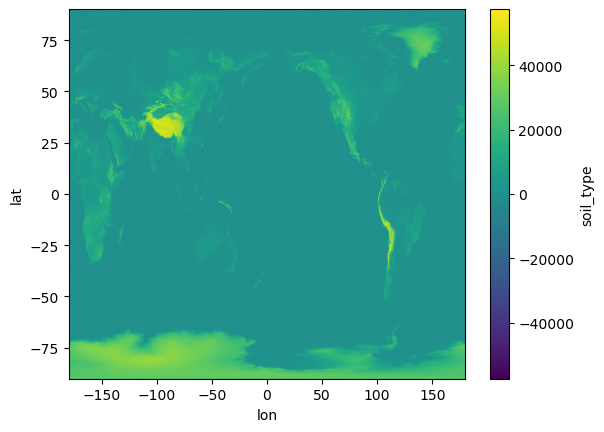

In [6]:
import numpy as np
import xarray as xr
# Load the uploaded file and process it
file_path = 'constant_masks/topography.npy'

# Load the data
soil_type = np.load(file_path)

# Convert to DataArray
soil_da = xr.DataArray(
    soil_type,
    dims=["lat", "lon"],
    coords={
        "lat": np.linspace(90, -90, soil_type.shape[0]),
        "lon": np.linspace(-180, 180, soil_type.shape[1]),
    },
    name="soil_type"
)

# Plot the data
soil_da.plot(cmap="viridis")



# 结果评估

In [16]:
upper_mean.unsqueeze(0).unsqueeze(2).shape

torch.Size([1, 7, 1, 5, 721, 1440])

In [30]:
output_surface.shape

torch.Size([1, 17, 1, 721, 1440])

In [22]:
target_surface.shape

torch.Size([1, 7, 17, 5, 721, 1440])

In [5]:


model_path = '/home/CanglongPhysics/checkpoints_v3/model_v2.pth'  # 使用最佳模型
print(f"Loading model from {model_path}...")
model = CanglongV2()
# model = CanglongV3(
#     surface_mean=surface_mean,
#     surface_std=surface_std,
#     upper_mean=upper_mean,
#     upper_std=upper_std
# )
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
print("Complete model loaded successfully")


model.to(device)
model.eval()

total_precip_climatology = (surface_mean[LSRR_IDX] + surface_mean[CRR_IDX]).to(device)
metric_records = []
surface_mean, upper_mean, surface_std, upper_std = surface_mean.cuda(), upper_mean.cuda(), surface_std.cuda(), upper_std.cuda()
with torch.no_grad():
    for batch in test_loader:
        input_surface, input_upper_air, target_surface, _, sample_indices = batch
        sample_indices = sample_indices.tolist()

        input_surface, input_upper_air, target_surface = input_surface.to(device), input_upper_air.to(device), target_surface.to(device)
        input_surface = ((input_surface - surface_mean.unsqueeze(0).unsqueeze(2)) / surface_std.unsqueeze(0).unsqueeze(2))
        input_upper_air = ((input_upper_air - upper_mean.unsqueeze(0).unsqueeze(3)) / upper_std.unsqueeze(0).unsqueeze(3))

#        target_surface = ((target_surface - surface_mean.unsqueeze(0).unsqueeze(2)) / surface_mean.unsqueeze(0).unsqueeze(2))

        output_surface, _ = model(input_surface, input_upper_air)

        output_surface = output_surface * surface_std.unsqueeze(0).unsqueeze(2) + surface_mean.unsqueeze(0).unsqueeze(2)
        

        pred_total_precip = output_surface[:, LSRR_IDX, 0, :, :] + output_surface[:, CRR_IDX, 0, :, :]
        true_total_precip = target_surface[:, LSRR_IDX, 0, :, :] + target_surface[:, CRR_IDX, 0, :, :]

        pcc_batch = compute_pcc(pred_total_precip, true_total_precip)
        acc_batch = compute_acc(pred_total_precip, true_total_precip, total_precip_climatology)
        rmse_batch = compute_rmse(pred_total_precip, true_total_precip)

        for b_idx, sample_id in enumerate(sample_indices):
            sample_pcc = float(pcc_batch[b_idx].detach().cpu())
            sample_acc = float(acc_batch[b_idx].detach().cpu())
            sample_rmse = float(rmse_batch[b_idx].detach().cpu())
            metric_records.append({
                'sample_index': sample_id,
                'pcc': sample_pcc,
                'acc': sample_acc,
                'rmse': sample_rmse
            })
            print(
                f"Test sample {sample_id:02d} -> PCC: {sample_pcc:.6f}, "
                f"ACC: {sample_acc:.6f}, RMSE: {sample_rmse:.6f}"
            )
        


if not metric_records:
    print("No samples available in the test set for evaluation.")
else:
    metric_records.sort(key=lambda item: item['sample_index'])
    avg_pcc = float(np.mean([m['pcc'] for m in metric_records]))
    avg_acc = float(np.mean([m['acc'] for m in metric_records]))
    avg_rmse = float(np.mean([m['rmse'] for m in metric_records]))
    combined_score = 0.5 * (avg_pcc + avg_acc)

    print("\nTest set summary (precipitation):")
    print(f"Average PCC:  {avg_pcc:.6f}")
    print(f"Average ACC:  {avg_acc:.6f}")
    print(f"Average RMSE: {avg_rmse:.6f}")
    print(f"Combined score (mean PCC/ACC): {combined_score:.6f}")

Loading model from /home/CanglongPhysics/checkpoints_v3/model_v2.pth...
Complete model loaded successfully


/tmp/ipykernel_17286/3310994168.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Test sample 40 -> PCC: 0.287351, ACC: 0.284945, RMSE: 0.000045
Test sample 41 -> PCC: 0.279829, ACC: 0.278133, RMSE: 0.000045
Test sample 42 -> PCC: 0.349491, ACC: 0.348687, RMSE: 0.000047
Test sample 43 -> PCC: 0.291509, ACC: 0.290144, RMSE: 0.000049
Test sample 44 -> PCC: 0.261442, ACC: 0.261774, RMSE: 0.000046
Test sample 45 -> PCC: 0.329170, ACC: 0.325032, RMSE: 0.000044
Test sample 46 -> PCC: 0.306911, ACC: 0.306498, RMSE: 0.000049
Test sample 47 -> PCC: 0.318067, ACC: 0.315497, RMSE: 0.000050
Test sample 48 -> PCC: 0.311375, ACC: 0.308930, RMSE: 0.000048
Test sample 49 -> PCC: 0.307521, ACC: 0.302929, RMSE: 0.000046

Test set summary (precipitation):
Average PCC:  0.304267
Average ACC:  0.302257
Average RMSE: 0.000047
Combined score (mean PCC/ACC): 0.303262


In [29]:
rain.shape

torch.Size([721, 1440])

In [32]:
surface = target_surface * surface_std.unsqueeze(0).unsqueeze(2) + surface_mean.unsqueeze(0).unsqueeze(2) 
rain = surface[0, 0, 0, :, :] + surface[0, 1, 0, :, :]

In [26]:
surface.shape

torch.Size([1, 17, 17, 721, 1440])

/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


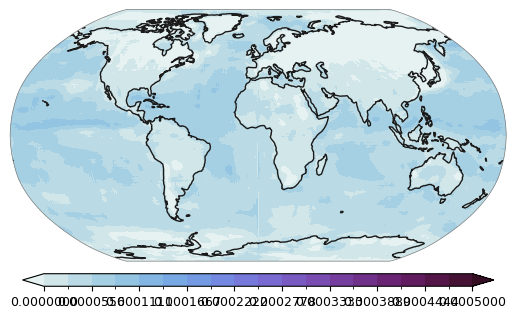

In [5]:
from utils import plot
import xarray as xr
import cmaps
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    pred_total_precip.cpu().numpy()[0],
    coords=[("lat", lat), ("lon", lon)],
    name="sst"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 0.0005, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap=cmaps.cmocean_dense, mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


In [19]:
true_total_precip.cpu().numpy()[0]

array([[2.335199e-05, 2.335199e-05, 2.335199e-05, ..., 2.335199e-05,
        2.335199e-05, 2.335199e-05],
       [2.335199e-05, 2.335199e-05, 2.335199e-05, ..., 2.335199e-05,
        2.335199e-05, 2.335199e-05],
       [2.335199e-05, 2.335199e-05, 2.335199e-05, ..., 2.335199e-05,
        2.335199e-05, 2.335199e-05],
       ...,
       [2.335199e-05, 2.335199e-05, 2.335199e-05, ..., 2.335199e-05,
        2.335199e-05, 2.335199e-05],
       [2.335199e-05, 2.335199e-05, 2.335199e-05, ..., 2.335199e-05,
        2.335199e-05, 2.335199e-05],
       [2.335199e-05, 2.335199e-05, 2.335199e-05, ..., 2.335199e-05,
        2.335199e-05, 2.335199e-05]], dtype=float32)

/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


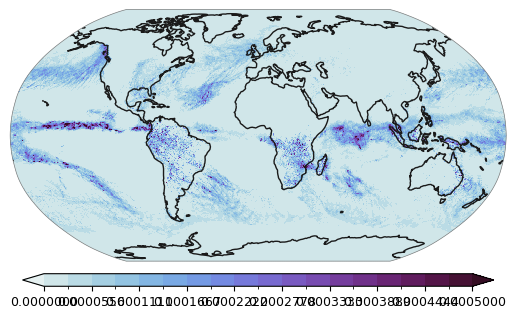

In [6]:
from utils import plot
import xarray as xr
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    true_total_precip.cpu().numpy()[0],
    coords=[("lat", lat), ("lon", lon)],
    name="sst"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 0.0005, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap=cmaps.cmocean_dense, mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


In [1]:
import h5py as h5
print("Loading data...")
h5_file = h5.File('/gz-data/ERA5_2023_weekly.h5', 'r')
input_surface = h5_file['surface'][:]  # (52, 17, 721, 1440)
input_upper_air = h5_file['upper_air'][:]  # (52, 7, 5, 721, 1440)
h5_file.close()


Loading data...


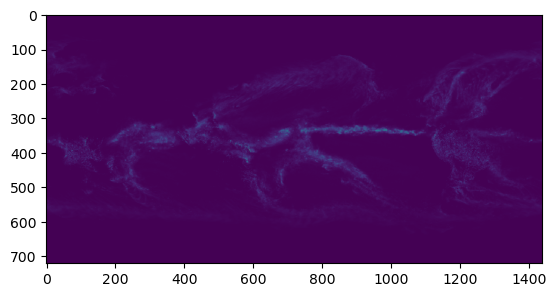

In [5]:
rain = input_surface[50, 0, :, :] + input_surface[50, 1, :, :]
import matplotlib.pyplot as plt
plt.imshow(rain)

## new infer

In [2]:
from torch.utils.data import Dataset, DataLoader
import h5py as h5
sys.path.append('code_v2')
from convert_dict_to_pytorch_arrays import load_normalization_arrays

def denormalize_surface(tensor, surface_mean, surface_std):
    """Convert normalized surface data back to physical units."""
    return tensor * surface_std + surface_mean


def denormalize_upper(tensor, upper_mean, upper_std):
    """Convert normalized upper-air data back to physical units."""
    return tensor * upper_std + upper_mean


class WeatherDataset(Dataset):
    def __init__(self, surface_data, upper_air_data, start_idx, end_idx):
        """
        初始化气象数据集 - 按时间序列顺序划分
        
        参数:
            surface_data: 表面数据，形状为 [time, 17, 721, 1440]
            upper_air_data: 高空数据，形状为 [time, 7, 5, 721, 1440]
            start_idx: 开始索引
            end_idx: 结束索引
        """
        self.surface_data = surface_data
        self.upper_air_data = upper_air_data
        self.length = end_idx - start_idx - 2  # 减2确保有足够的目标数据
        self.start_idx = start_idx
        
        print(f"Dataset from index {start_idx} to {end_idx}, sample count: {self.length}")
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        actual_idx = self.start_idx + idx
        
        # 提取输入数据 (t和t+1时刻)
        input_surface = self.surface_data[actual_idx:actual_idx+2]  # [2, 17, 721, 1440]
        # 添加batch维度并调整为 [17, 2, 721, 1440]
        input_surface = np.transpose(input_surface, (1, 0, 2, 3))  # [17, 2, 721, 1440]
        
        # 提取高空数据 (t和t+1时刻)
        input_upper_air = self.upper_air_data[actual_idx:actual_idx+2]  # [2, 7, 5, 721, 1440]
        # 调整为 [7, 5, 2, 721, 1440]
        input_upper_air = np.transpose(input_upper_air, (1, 2, 0, 3, 4))  # [7, 5, 2, 721, 1440]
        
        # 提取目标数据 (t+2时刻)
        target_surface = self.surface_data[actual_idx+2:actual_idx+3]  # [1, 17, 721, 1440]
        # 调整为 [17, 1, 721, 1440]
        target_surface = np.transpose(target_surface, (1, 0, 2, 3))  # [17, 1, 721, 1440]
        
        target_upper_air = self.upper_air_data[actual_idx+2:actual_idx+3]  # [1, 7, 5, 721, 1440]
        # 调整为 [7, 5, 1, 721, 1440]
        target_upper_air = np.transpose(target_upper_air, (1, 2, 0, 3, 4))  # [7, 5, 1, 721, 1440]
        
        return input_surface, input_upper_air, target_surface, target_upper_air, actual_idx

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load constant masks on the selected device
constant_path = 'constant_masks/Earth.pt'
input_constant = torch.load(constant_path, map_location=device)
input_constant = input_constant.to(device)

# 加载数据
print("Loading data...")
h5_file = h5.File('/gz-data/ERA5_2023_weekly.h5', 'r')
input_surface = h5_file['surface'][:]  # (52, 17, 721, 1440)
input_upper_air = h5_file['upper_air'][:]  # (52, 7, 5, 721, 1440)
h5_file.close()

print(f"Surface data shape: {input_surface.shape}")
print(f"Upper air data shape: {input_upper_air.shape}")

# 加载标准化参数
print("Loading normalization parameters...")
json_path = '/home/CanglongPhysics/code_v2/ERA5_1940_2019_combined_mean_std.json'
surface_mean_np, surface_std_np, upper_mean_np, upper_std_np = load_normalization_arrays(json_path)

surface_mean = torch.from_numpy(surface_mean_np).to(device=device, dtype=torch.float32)
surface_std = torch.from_numpy(surface_std_np).to(device=device, dtype=torch.float32)
upper_mean = torch.from_numpy(upper_mean_np).to(device=device, dtype=torch.float32)
upper_std = torch.from_numpy(upper_std_np).to(device=device, dtype=torch.float32)

print(f"Surface mean shape: {surface_mean.shape}")
print(f"Surface std shape: {surface_std.shape}")
print(f"Upper mean shape: {upper_mean.shape}")
print(f"Upper std shape: {upper_std.shape}")

# 计算数据集划分点 - 按照6:2:2的时间序列划分
total_samples = 52
train_end = 30
valid_end = 40

test_dataset = WeatherDataset(input_surface, input_upper_air, start_idx=valid_end, end_idx=total_samples)
batch_size = 1  # 小batch size便于调试
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(f"Created data loaders with batch size {batch_size}")

# Variable ordering shared across the project. Keep in sync with CLAUDE.md.
SURFACE_VARS = [
    'lsrr', 'crr', 'tciw', 'tcc', 'tsrc', 'u10', 'v10', 'd2m', 't2m',
    'avg_tnlwrf', 'slhf', 'sshf', 'sp', 'swvl', 'msl', 'siconc', 'sst'
]
UPPER_VARS = ['z', 'w', 'u', 'v', 'cc', 't', 'q']
PRESSURE_LEVELS = [200, 300, 500, 700, 850]

SURFACE_VAR_TO_IDX = {name: idx for idx, name in enumerate(SURFACE_VARS)}
LSRR_IDX = SURFACE_VAR_TO_IDX['lsrr']
CRR_IDX = SURFACE_VAR_TO_IDX['crr']
AVG_TNLWRF_IDX = SURFACE_VAR_TO_IDX['avg_tnlwrf']
T2M_IDX = SURFACE_VAR_TO_IDX['t2m']
D2M_IDX = SURFACE_VAR_TO_IDX['d2m']
U_VAR_IDX = UPPER_VARS.index('u')
PRESSURE_LEVEL_TO_IDX = {level: idx for idx, level in enumerate(PRESSURE_LEVELS)}

def compute_pcc(pred, target):
    """Compute Pearson correlation coefficient for each sample in the batch."""
    pred_flat = pred.reshape(pred.shape[0], -1)
    target_flat = target.reshape(target.shape[0], -1)
    pred_anom = pred_flat - pred_flat.mean(dim=1, keepdim=True)
    target_anom = target_flat - target_flat.mean(dim=1, keepdim=True)
    numerator = (pred_anom * target_anom).sum(dim=1)
    denominator = torch.sqrt((pred_anom.pow(2).sum(dim=1)) * (target_anom.pow(2).sum(dim=1)))
    denominator = torch.clamp(denominator, min=1e-12)
    return numerator / denominator


def compute_acc(pred, target, climatology):
    """Compute anomaly correlation coefficient for each sample in the batch."""
    pred_flat = pred.reshape(pred.shape[0], -1)
    target_flat = target.reshape(target.shape[0], -1)
    clim_flat = climatology.reshape(1, -1).to(pred_flat.device)
    pred_anom = pred_flat - clim_flat
    target_anom = target_flat - clim_flat
    numerator = (pred_anom * target_anom).sum(dim=1)
    denominator = torch.sqrt((pred_anom.pow(2).sum(dim=1)) * (target_anom.pow(2).sum(dim=1)))
    denominator = torch.clamp(denominator, min=1e-12)
    return numerator / denominator


def compute_rmse(pred, target):
    """Compute RMSE for each sample in the batch."""
    diff = pred - target
    mse = diff.pow(2).reshape(diff.shape[0], -1).mean(dim=1)
    return torch.sqrt(mse)

Using device: cuda


/tmp/ipykernel_6495/415650273.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_constant = torch.load(constant_path, map_location=device)


Loading data...


Surface data shape: (52, 17, 721, 1440)
Upper air data shape: (52, 7, 5, 721, 1440)
Loading normalization parameters...
Surface mean shape: torch.Size([1, 17, 1, 721, 1440])
Surface std shape: torch.Size([1, 17, 1, 721, 1440])
Upper mean shape: torch.Size([1, 7, 5, 1, 721, 1440])
Upper std shape: torch.Size([1, 7, 5, 1, 721, 1440])
Dataset from index 40 to 52, sample count: 10
Created data loaders with batch size 1


In [3]:
model_path = '/home/CanglongPhysics/checkpoints_v3/model_v3_50.pth'   # 使用最佳模型model_v1'/gz-data/model_v1_epoch50.pth' 
print(f"Loading model from {model_path}...")
#model = CanglongV2()
model = CanglongV3()
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict, strict=False)
print("Complete model loaded successfully")


model.to(device)
model.eval()

surface_mean_2d = surface_mean[0, :, 0, :, :]
total_precip_climatology = surface_mean_2d[LSRR_IDX] + surface_mean_2d[CRR_IDX]
metric_records = []
with torch.no_grad():
    for batch in test_loader:
        input_surface, input_upper_air, target_surface, target_upper_air, sample_indices = batch
        sample_indices = sample_indices.tolist()

        input_surface = input_surface.float().to(device)
        input_upper_air = input_upper_air.float().to(device)
        target_surface = target_surface.float().to(device)
        target_upper_air = target_upper_air.float().to(device)
        input_surface = (input_surface - surface_mean) / surface_std
        input_upper_air = (input_upper_air - upper_mean) / upper_std

        output_surface, output_upper_air = model(input_surface, input_upper_air)

        # Preserve normalized tensors for RMSE in standardized space
        output_surface_norm = output_surface
        output_upper_air_norm = output_upper_air
        target_surface_norm = (target_surface - surface_mean) / surface_std
        target_upper_air_norm = (target_upper_air - upper_mean) / upper_std

        # Convert back to physical units for correlation-based diagnostics
        output_surface_phys = denormalize_surface(output_surface_norm, surface_mean, surface_std)
        output_upper_air_phys = denormalize_upper(output_upper_air_norm, upper_mean, upper_std)

        pred_total_precip_phys = output_surface_phys[:, LSRR_IDX, 0, :, :] + output_surface_phys[:, CRR_IDX, 0, :, :]
        true_total_precip_phys = target_surface[:, LSRR_IDX, 0, :, :] + target_surface[:, CRR_IDX, 0, :, :]
        pred_total_precip_norm = output_surface_norm[:, LSRR_IDX, 0, :, :] + output_surface_norm[:, CRR_IDX, 0, :, :]
        true_total_precip_norm = target_surface_norm[:, LSRR_IDX, 0, :, :] + target_surface_norm[:, CRR_IDX, 0, :, :]

        pcc_batch = compute_pcc(pred_total_precip_phys, true_total_precip_phys)
        acc_batch = compute_acc(pred_total_precip_phys, true_total_precip_phys, total_precip_climatology)
        rmse_batch = compute_rmse(pred_total_precip_norm, true_total_precip_norm)

        avg_tnlwrf_pred_phys = output_surface_phys[:, AVG_TNLWRF_IDX, 0, :, :]
        avg_tnlwrf_true_phys = target_surface[:, AVG_TNLWRF_IDX, 0, :, :]
        avg_tnlwrf_pcc_batch = compute_pcc(avg_tnlwrf_pred_phys, avg_tnlwrf_true_phys)
        avg_tnlwrf_rmse_batch = compute_rmse(
            output_surface_norm[:, AVG_TNLWRF_IDX, 0, :, :],
            target_surface_norm[:, AVG_TNLWRF_IDX, 0, :, :]
        )

        t2m_pred_phys = output_surface_phys[:, T2M_IDX, 0, :, :]
        t2m_true_phys = target_surface[:, T2M_IDX, 0, :, :]
        t2m_pcc_batch = compute_pcc(t2m_pred_phys, t2m_true_phys)
        t2m_rmse_batch = compute_rmse(
            output_surface_norm[:, T2M_IDX, 0, :, :],
            target_surface_norm[:, T2M_IDX, 0, :, :]
        )

        d2m_pred_phys = output_surface_phys[:, D2M_IDX, 0, :, :]
        d2m_true_phys = target_surface[:, D2M_IDX, 0, :, :]
        d2m_pcc_batch = compute_pcc(d2m_pred_phys, d2m_true_phys)
        d2m_rmse_batch = compute_rmse(
            output_surface_norm[:, D2M_IDX, 0, :, :],
            target_surface_norm[:, D2M_IDX, 0, :, :]
        )

        u200_level_idx = PRESSURE_LEVEL_TO_IDX[200]
        u850_level_idx = PRESSURE_LEVEL_TO_IDX[850]
        u200_pred_phys = output_upper_air_phys[:, U_VAR_IDX, u200_level_idx, 0, :, :]
        u200_true_phys = target_upper_air[:, U_VAR_IDX, u200_level_idx, 0, :, :]
        u200_pcc_batch = compute_pcc(u200_pred_phys, u200_true_phys)
        u200_rmse_batch = compute_rmse(
            output_upper_air_norm[:, U_VAR_IDX, u200_level_idx, 0, :, :],
            target_upper_air_norm[:, U_VAR_IDX, u200_level_idx, 0, :, :]
        )

        u850_pred_phys = output_upper_air_phys[:, U_VAR_IDX, u850_level_idx, 0, :, :]
        u850_true_phys = target_upper_air[:, U_VAR_IDX, u850_level_idx, 0, :, :]
        u850_pcc_batch = compute_pcc(u850_pred_phys, u850_true_phys)
        u850_rmse_batch = compute_rmse(
            output_upper_air_norm[:, U_VAR_IDX, u850_level_idx, 0, :, :],
            target_upper_air_norm[:, U_VAR_IDX, u850_level_idx, 0, :, :]
        )

        surface_rmse_batch = compute_rmse(output_surface_norm, target_surface_norm)
        upper_air_rmse_batch = compute_rmse(output_upper_air_norm, target_upper_air_norm)

        for b_idx, sample_id in enumerate(sample_indices):
            sample_pcc = float(pcc_batch[b_idx].detach().cpu())
            sample_acc = float(acc_batch[b_idx].detach().cpu())
            sample_rmse = float(rmse_batch[b_idx].detach().cpu())
            sample_avg_tnlwrf_pcc = float(avg_tnlwrf_pcc_batch[b_idx].detach().cpu())
            sample_avg_tnlwrf_rmse = float(avg_tnlwrf_rmse_batch[b_idx].detach().cpu())
            sample_t2m_pcc = float(t2m_pcc_batch[b_idx].detach().cpu())
            sample_t2m_rmse = float(t2m_rmse_batch[b_idx].detach().cpu())
            sample_d2m_pcc = float(d2m_pcc_batch[b_idx].detach().cpu())
            sample_d2m_rmse = float(d2m_rmse_batch[b_idx].detach().cpu())
            sample_u200_pcc = float(u200_pcc_batch[b_idx].detach().cpu())
            sample_u200_rmse = float(u200_rmse_batch[b_idx].detach().cpu())
            sample_u850_pcc = float(u850_pcc_batch[b_idx].detach().cpu())
            sample_u850_rmse = float(u850_rmse_batch[b_idx].detach().cpu())
            sample_surface_rmse = float(surface_rmse_batch[b_idx].detach().cpu())
            sample_upper_air_rmse = float(upper_air_rmse_batch[b_idx].detach().cpu())
            metric_records.append({
                'sample_index': sample_id,
                'pcc': sample_pcc,
                'acc': sample_acc,
                'rmse': sample_rmse,
                'avg_tnlwrf_pcc': sample_avg_tnlwrf_pcc,
                'avg_tnlwrf_rmse': sample_avg_tnlwrf_rmse,
                't2m_pcc': sample_t2m_pcc,
                't2m_rmse': sample_t2m_rmse,
                'd2m_pcc': sample_d2m_pcc,
                'd2m_rmse': sample_d2m_rmse,
                'u200_pcc': sample_u200_pcc,
                'u200_rmse': sample_u200_rmse,
                'u850_pcc': sample_u850_pcc,
                'u850_rmse': sample_u850_rmse,
                'surface_rmse': sample_surface_rmse,
                'upper_air_rmse': sample_upper_air_rmse
            })
            print(
                f"Test sample {sample_id:02d} -> PCC: {sample_pcc:.6f}, "
                f"ACC: {sample_acc:.6f}, RMSE(norm.): {sample_rmse:.6f}"
            )
            print(
                " " * 22 +
                f"avg_tnlwrf PCC: {sample_avg_tnlwrf_pcc:.6f}, RMSE(norm.): {sample_avg_tnlwrf_rmse:.6f} | "
                f"t2m PCC: {sample_t2m_pcc:.6f}, RMSE(norm.): {sample_t2m_rmse:.6f} | "
                f"d2m PCC: {sample_d2m_pcc:.6f}, RMSE(norm.): {sample_d2m_rmse:.6f} | "
                f"u200 PCC: {sample_u200_pcc:.6f}, RMSE(norm.): {sample_u200_rmse:.6f} | "
                f"u850 PCC: {sample_u850_pcc:.6f}, RMSE(norm.): {sample_u850_rmse:.6f} | "
                f"surface RMSE(norm.): {sample_surface_rmse:.6f} | upper-air RMSE(norm.): {sample_upper_air_rmse:.6f}"
            )
        


if not metric_records:
    print("No samples available in the test set for evaluation.")
else:
    metric_records.sort(key=lambda item: item['sample_index'])
    avg_pcc = float(np.mean([m['pcc'] for m in metric_records]))
    avg_acc = float(np.mean([m['acc'] for m in metric_records]))
    avg_rmse = float(np.mean([m['rmse'] for m in metric_records]))
    avg_avg_tnlwrf_pcc = float(np.mean([m['avg_tnlwrf_pcc'] for m in metric_records]))
    avg_avg_tnlwrf_rmse = float(np.mean([m['avg_tnlwrf_rmse'] for m in metric_records]))
    avg_t2m_pcc = float(np.mean([m['t2m_pcc'] for m in metric_records]))
    avg_t2m_rmse = float(np.mean([m['t2m_rmse'] for m in metric_records]))
    avg_d2m_pcc = float(np.mean([m['d2m_pcc'] for m in metric_records]))
    avg_d2m_rmse = float(np.mean([m['d2m_rmse'] for m in metric_records]))
    avg_u200_pcc = float(np.mean([m['u200_pcc'] for m in metric_records]))
    avg_u200_rmse = float(np.mean([m['u200_rmse'] for m in metric_records]))
    avg_u850_pcc = float(np.mean([m['u850_pcc'] for m in metric_records]))
    avg_u850_rmse = float(np.mean([m['u850_rmse'] for m in metric_records]))
    avg_surface_rmse = float(np.mean([m['surface_rmse'] for m in metric_records]))
    avg_upper_air_rmse = float(np.mean([m['upper_air_rmse'] for m in metric_records]))
    combined_score = 0.5 * (avg_pcc + avg_acc)

    grouped_avg_pcc = float(np.mean([
        avg_pcc,
        avg_t2m_pcc,
        avg_d2m_pcc,
        avg_u200_pcc,
        avg_u850_pcc
    ]))
    grouped_avg_rmse = float(np.mean([
        avg_rmse,
        avg_t2m_rmse,
        avg_d2m_rmse,
        avg_u200_rmse,
        avg_u850_rmse
    ]))

    print("\nTest set summary (precipitation & key variables):")
    print(f"Average precip PCC:  {avg_pcc:.6f}")
    print(f"Average precip ACC:  {avg_acc:.6f}")
    print(f"Average precip RMSE (norm.): {avg_rmse:.6f}")
    print(f"Combined score (mean PCC/ACC): {combined_score:.6f}")
    print(f"Average avg_tnlwrf PCC: {avg_avg_tnlwrf_pcc:.6f}, RMSE(norm.): {avg_avg_tnlwrf_rmse:.6f}")
    print(f"Average t2m PCC:       {avg_t2m_pcc:.6f}, RMSE(norm.): {avg_t2m_rmse:.6f}")
    print(f"Average d2m PCC:       {avg_d2m_pcc:.6f}, RMSE(norm.): {avg_d2m_rmse:.6f}")
    print(f"Average u200 PCC:      {avg_u200_pcc:.6f}, RMSE(norm.): {avg_u200_rmse:.6f}")
    print(f"Average u850 PCC:      {avg_u850_pcc:.6f}, RMSE(norm.): {avg_u850_rmse:.6f}")
    print(f"Average grouped PCC (precip/t2m/d2m/u200/u850): {grouped_avg_pcc:.6f}")
    print(f"Average grouped RMSE(norm.) (precip/t2m/d2m/u200/u850): {grouped_avg_rmse:.6f}")
    print(f"Average surface RMSE(norm.):  {avg_surface_rmse:.6f}")
    print(f"Average upper-air RMSE(norm.):{avg_upper_air_rmse:.6f}")


Loading model from /home/CanglongPhysics/checkpoints_v3/model_v3_50.pth...


/usr/local/miniconda3/envs/torch/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


/tmp/ipykernel_6495/2627620622.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Complete model loaded successfully
Test sample 40 -> PCC: 0.556697, ACC: 0.556143, RMSE(norm.): 1.520416
                      avg_tnlwrf PCC: 0.932973, RMSE(norm.): 0.341551 | t2m PCC: 0.986028, RMSE(norm.): 0.168417 | d2m PCC: 0.981539, RMSE(norm.): 0.187453 | u200 PCC: 0.830472, RMSE(norm.): 0.531410 | u850 PCC: 0.812714, RMSE(norm.): 0.566263 | surface RMSE(norm.): 0.683874 | upper-air RMSE(norm.): 0.624677
Test sample 41 -> PCC: 0.610607, ACC: 0.610544, RMSE(norm.): 1.436676
                      avg_tnlwrf PCC: 0.938379, RMSE(norm.): 0.321100 | t2m PCC: 0.986141, RMSE(norm.): 0.171255 | d2m PCC: 0.982137, RMSE(norm.): 0.187746 | u200 PCC: 0.793127, RMSE(norm.): 0.589018 | u850 PCC: 0.770570, RMSE(norm.): 0.694722 | surface RMSE(norm.): 0.976058 | upper-air RMSE(norm.): 0.641184
Test sample 42 -> PCC: 0.638301, ACC: 0.635850, RMSE(norm.): 1.498940
                      avg_tnlwrf PCC: 0.932138, RMSE(norm.): 0.341076 | t2m PCC: 0.985609, RMSE(norm.): 0.167965 | d2m PCC: 0.983364, R

/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/tmp/ipykernel_6495/1604945567.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


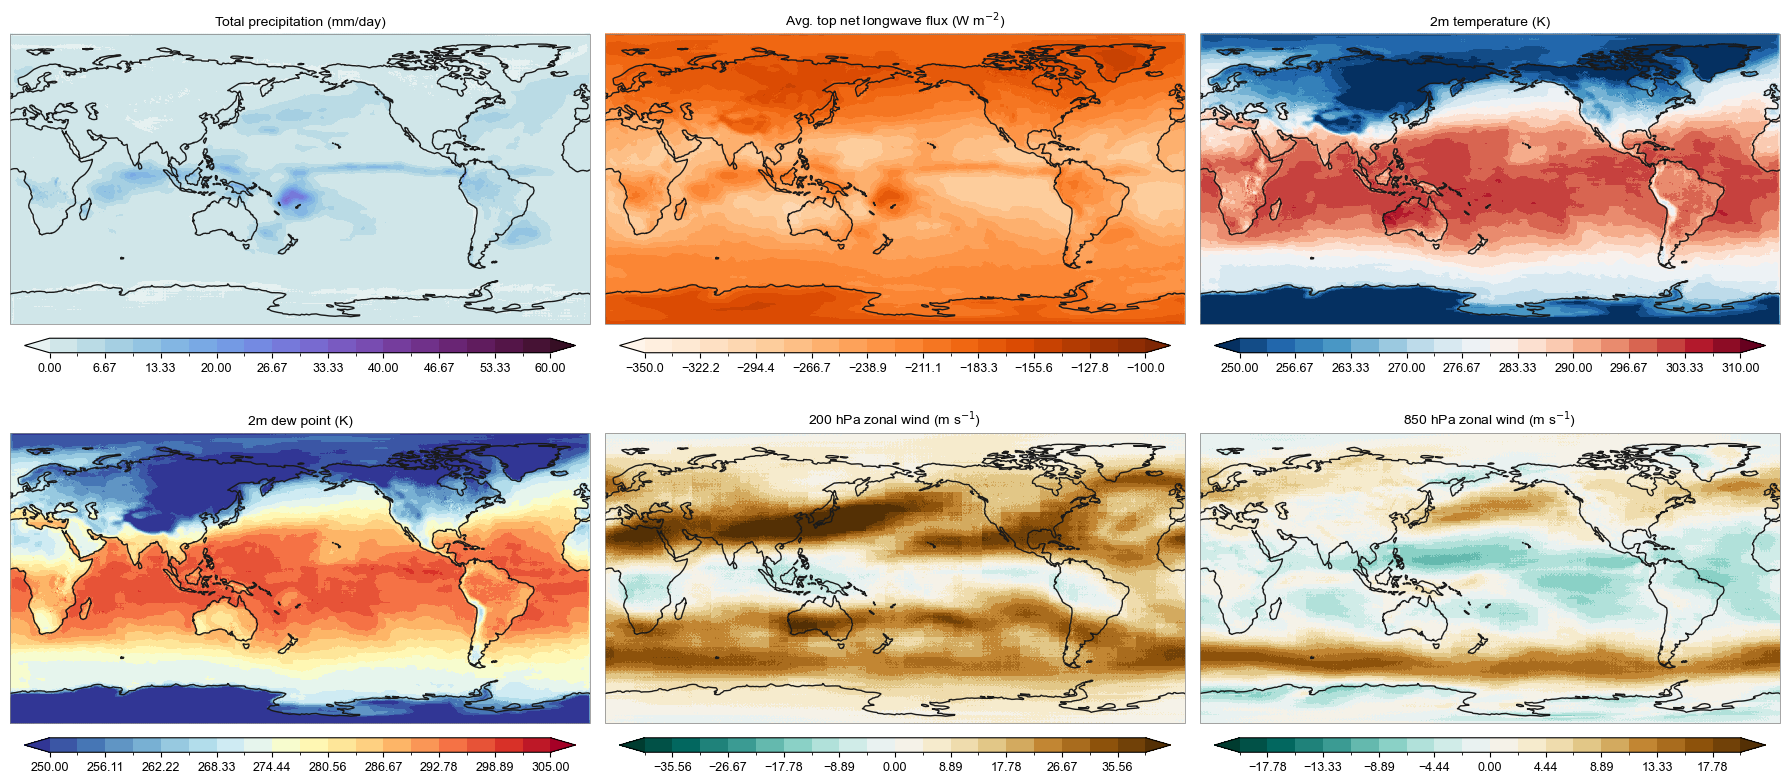

In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmaps
from matplotlib import font_manager
import os

# 在导入cartopy之前设置环境变量
os.environ['PROJ_DATA'] = '/usr/local/miniconda3/envs/torch/share/proj'
from utils import plot

# Configure Arial font as required for all plots
font_path = "/root/ARIAL.TTF"
try:
    font_manager.fontManager.addfont(font_path)
    plt.rcParams["font.family"] = font_manager.FontProperties(fname=font_path).get_name()
except FileNotFoundError:
    plt.rcParams["font.family"] = "Arial"

# Common coordinates
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)

# Helper to move tensor data onto CPU numpy arrays
cpu_numpy = lambda tensor: tensor.detach().cpu().numpy()

# Prepare all fields before plotting

surface_np = cpu_numpy(output_surface_phys)
upper_air_np = cpu_numpy(output_upper_air_phys)

avg_tnlwrf = surface_np[0, 9, 0]
t2m = surface_np[0, 8, 0]
d2m = surface_np[0, 7, 0]
u200 = upper_air_np[0, 2, 0, 0]
u850 = upper_air_np[0, 2, 4, 0]
precip_mm_day = surface_np[0, 0, 0] * 86400.0 + surface_np[0, 1, 0] * 86400.0

plot_configs = [
    {
        "data": xr.DataArray(
            precip_mm_day,
            coords=[("lat", lat), ("lon", lon)],
            name="Total precipitation (mm/day)",
        ),
        "levels": np.linspace(0, 60, num=19),
        "cmap": cmaps.cmocean_dense,
    },
    {
        "data": xr.DataArray(
            avg_tnlwrf,
            coords=[("lat", lat), ("lon", lon)],
            name="Avg. top net longwave flux (W m$^{-2}$)",
        ),
        "levels": np.linspace(-350, -100, num=19),
        "cmap": "Oranges",
    },
    {
        "data": xr.DataArray(
            t2m,
            coords=[("lat", lat), ("lon", lon)],
            name="2m temperature (K)",
        ),
        "levels": np.linspace(250, 310, num=19),
        "cmap": "RdBu_r",
    },
    {
        "data": xr.DataArray(
            d2m,
            coords=[("lat", lat), ("lon", lon)],
            name="2m dew point (K)",
        ),
        "levels": np.linspace(250, 305, num=19),
        "cmap": "RdYlBu_r",
    },
    {
        "data": xr.DataArray(
            u200,
            coords=[("lat", lat), ("lon", lon)],
            name="200 hPa zonal wind (m s$^{-1}$)",
        ),
        "levels": np.linspace(-40, 40, num=19),
        "cmap": "BrBG_r",
    },
    {
        "data": xr.DataArray(
            u850,
            coords=[("lat", lat), ("lon", lon)],
            name="850 hPa zonal wind (m s$^{-1}$)",
        ),
        "levels": np.linspace(-20, 20, num=19),
        "cmap": "BrBG_r",
    },
]

fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(18, 9),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180.0)},
)
axes = axes.flatten()

for ax, cfg in zip(axes, plot_configs):
    plot.one_map_flat(
        cfg["data"],
        ax,
        levels=cfg["levels"],
        cmap=cfg["cmap"],
        mask_ocean=False,
        add_coastlines=True,
        add_land=False,
        plotfunc="pcolormesh",
        colorbar=True,
    )
    ax.set_title(cfg["data"].name, fontsize=10, pad=6)

for ax in axes[len(plot_configs):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/tmp/ipykernel_6495/3785184441.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


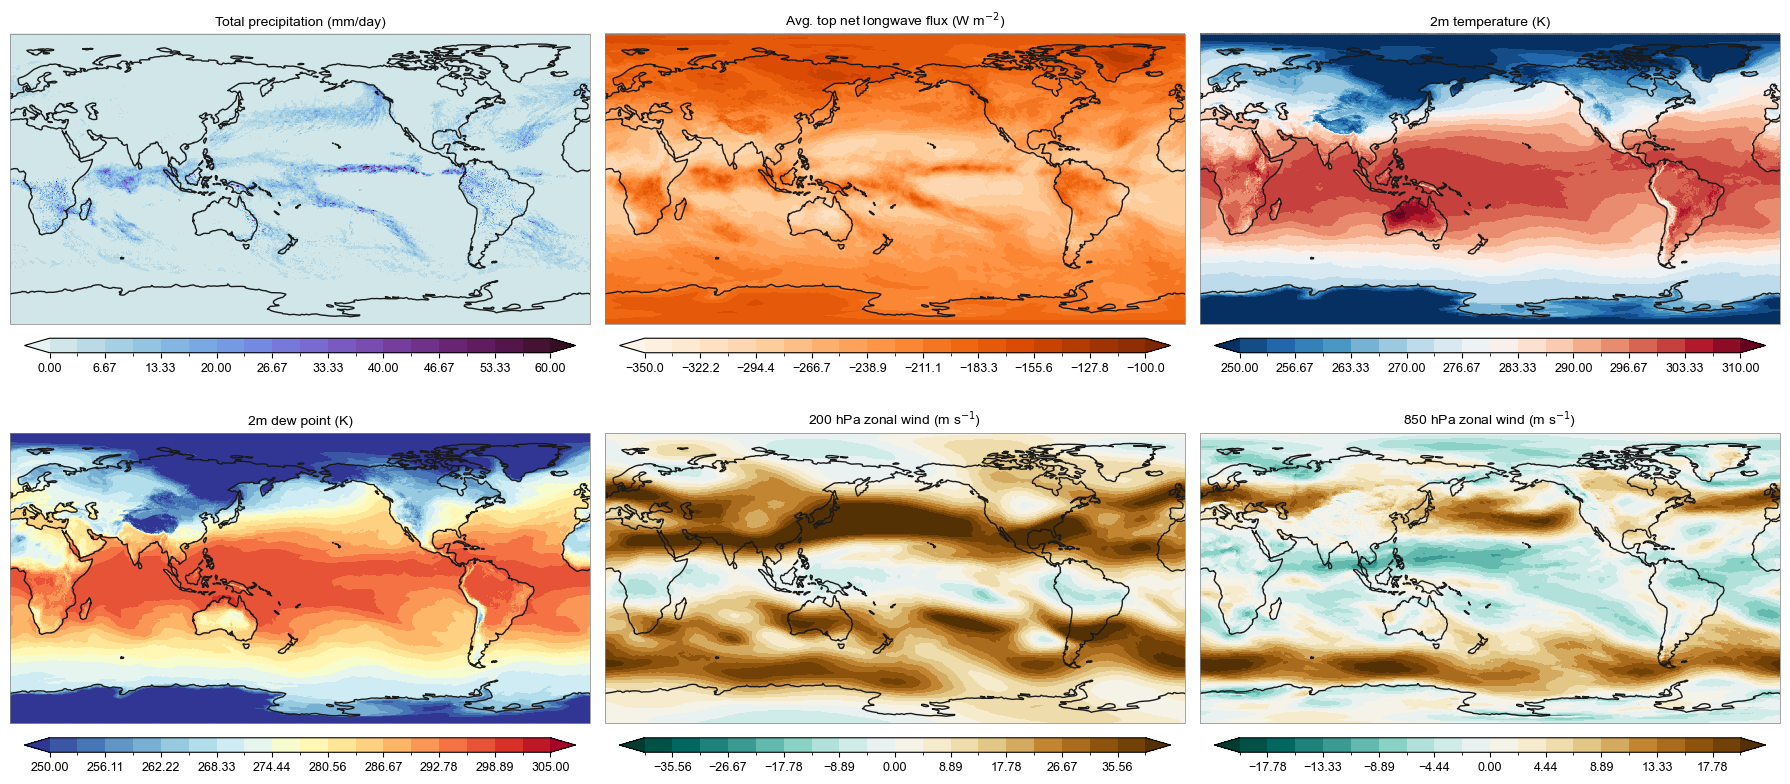

In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmaps
from matplotlib import font_manager
import os

# 在导入cartopy之前设置环境变量
os.environ['PROJ_DATA'] = '/usr/local/miniconda3/envs/torch/share/proj'
from utils import plot

# Configure Arial font as required for all plots
font_path = "/root/ARIAL.TTF"
try:
    font_manager.fontManager.addfont(font_path)
    plt.rcParams["font.family"] = font_manager.FontProperties(fname=font_path).get_name()
except FileNotFoundError:
    plt.rcParams["font.family"] = "Arial"

# Common coordinates
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)

# Helper to move tensor data onto CPU numpy arrays
cpu_numpy = lambda tensor: tensor.detach().cpu().numpy()

# Prepare all fields before plotting

surface_np = cpu_numpy(target_surface)
upper_air_np = cpu_numpy(target_upper_air)

avg_tnlwrf = surface_np[0, 9, 0]
t2m = surface_np[0, 8, 0]
d2m = surface_np[0, 7, 0]
u200 = upper_air_np[0, 2, 0, 0]
u850 = upper_air_np[0, 2, 4, 0]
precip_mm_day = surface_np[0, 0, 0] * 86400.0 + surface_np[0, 1, 0] * 86400.0

plot_configs = [
    {
        "data": xr.DataArray(
            precip_mm_day,
            coords=[("lat", lat), ("lon", lon)],
            name="Total precipitation (mm/day)",
        ),
        "levels": np.linspace(0, 60, num=19),
        "cmap": cmaps.cmocean_dense,
    },
    {
        "data": xr.DataArray(
            avg_tnlwrf,
            coords=[("lat", lat), ("lon", lon)],
            name="Avg. top net longwave flux (W m$^{-2}$)",
        ),
        "levels": np.linspace(-350, -100, num=19),
        "cmap": "Oranges",
    },
    {
        "data": xr.DataArray(
            t2m,
            coords=[("lat", lat), ("lon", lon)],
            name="2m temperature (K)",
        ),
        "levels": np.linspace(250, 310, num=19),
        "cmap": "RdBu_r",
    },
    {
        "data": xr.DataArray(
            d2m,
            coords=[("lat", lat), ("lon", lon)],
            name="2m dew point (K)",
        ),
        "levels": np.linspace(250, 305, num=19),
        "cmap": "RdYlBu_r",
    },
    {
        "data": xr.DataArray(
            u200,
            coords=[("lat", lat), ("lon", lon)],
            name="200 hPa zonal wind (m s$^{-1}$)",
        ),
        "levels": np.linspace(-40, 40, num=19),
        "cmap": "BrBG_r",
    },
    {
        "data": xr.DataArray(
            u850,
            coords=[("lat", lat), ("lon", lon)],
            name="850 hPa zonal wind (m s$^{-1}$)",
        ),
        "levels": np.linspace(-20, 20, num=19),
        "cmap": "BrBG_r",
    },
]

fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(18, 9),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180.0)}, #PlateCarree(central_longitude=0.0, globe=None) Robinson
)
axes = axes.flatten()

for ax, cfg in zip(axes, plot_configs):
    plot.one_map_flat(
        cfg["data"],
        ax,
        levels=cfg["levels"],
        cmap=cfg["cmap"],
        mask_ocean=False,
        add_coastlines=True,
        add_land=False,
        plotfunc="pcolormesh",
        colorbar=True,
    )
    ax.set_title(cfg["data"].name, fontsize=10, pad=6)

for ax in axes[len(plot_configs):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


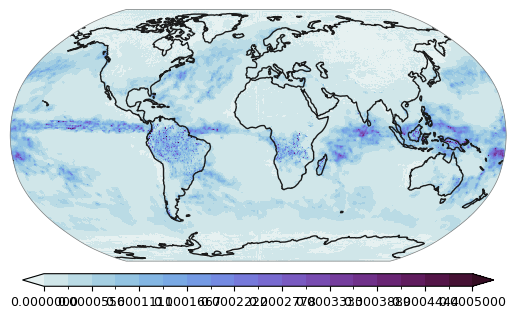

In [11]:
from utils import plot
import xarray as xr
import cmaps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    pred_total_precip.cpu().numpy()[0],
    coords=[("lat", lat), ("lon", lon)],
    name="tp"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 0.0005, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap=cmaps.cmocean_dense, mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


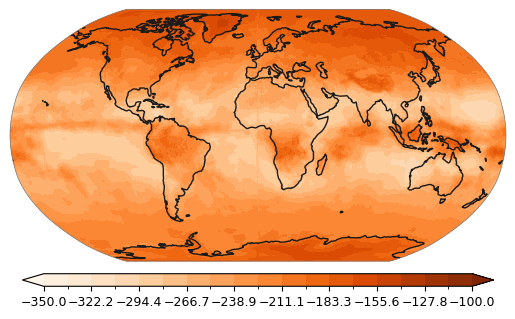

In [27]:
from utils import plot
import xarray as xr
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    output_surface[0, 9, 0, :, :].cpu().numpy(),
    coords=[("lat", lat), ("lon", lon)],
    name="avg_tnlwrf"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-350, -100, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap='Oranges', mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


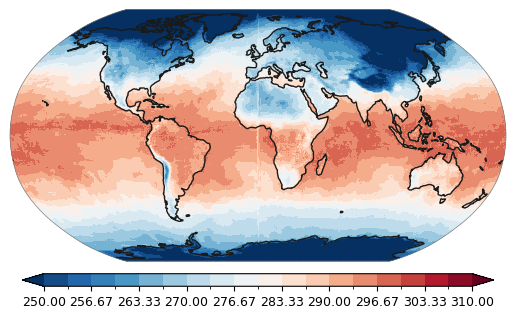

In [18]:
from utils import plot
import xarray as xr
import cmaps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    output_surface[0, 7, 0, :, :].cpu().numpy(),
    coords=[("lat", lat), ("lon", lon)],
    name="t2m"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(250, 310, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap='RdBu_r', mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


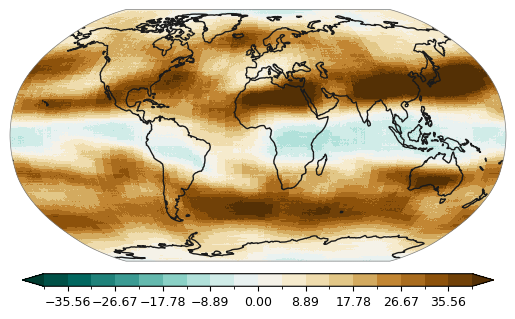

In [37]:
from utils import plot
import xarray as xr
import cmaps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    output_upper_air[0, 2, 0, 0, :, :].cpu().numpy(),
    coords=[("lat", lat), ("lon", lon)],
    name="200u"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-40, 40, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap='BrBG_r', mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


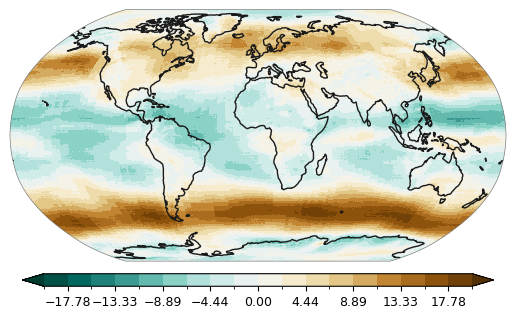

In [45]:
from utils import plot
import xarray as xr
import cmaps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    output_upper_air[0, 2, 4, 0, :, :].cpu().numpy(),
    coords=[("lat", lat), ("lon", lon)],
    name="850u"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-20, 20, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap='BrBG_r', mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


In [34]:
output_upper_air.shape

torch.Size([1, 7, 5, 1, 721, 1440])

In [35]:
output_upper_air[0, 2, 0, 0, :, :].cpu().numpy()

array([[-5.787468  , -5.6993523 , -6.129038  , ..., -4.6931534 ,
        -4.768276  , -4.4954567 ],
       [-4.993778  , -5.480831  , -5.1118336 , ..., -4.699297  ,
        -4.2251186 , -3.5560455 ],
       [-5.0407314 , -4.4520473 , -4.6060486 , ..., -3.9267902 ,
        -4.490553  , -5.028574  ],
       ...,
       [ 0.9498596 ,  1.3490543 ,  1.0781851 , ...,  1.2576408 ,
         0.9014578 ,  0.3801794 ],
       [ 1.4341612 ,  1.1965742 ,  1.4879122 , ...,  0.94414234,
         1.2226734 ,  1.6245909 ],
       [ 0.8089733 ,  1.2403812 ,  0.9738846 , ...,  0.795002  ,
         0.6327276 ,  0.19065666]], dtype=float32)

实际观测

/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


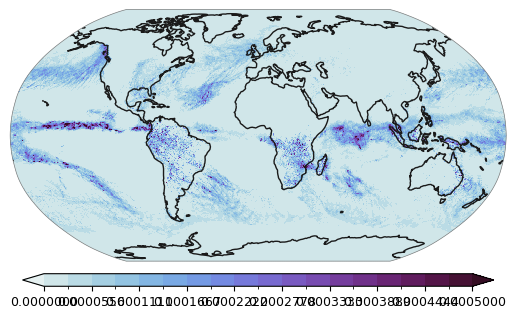

In [6]:
from utils import plot
import xarray as xr
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    true_total_precip.cpu().numpy()[0],
    coords=[("lat", lat), ("lon", lon)],
    name="sst"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 0.0005, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap=cmaps.cmocean_dense, mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


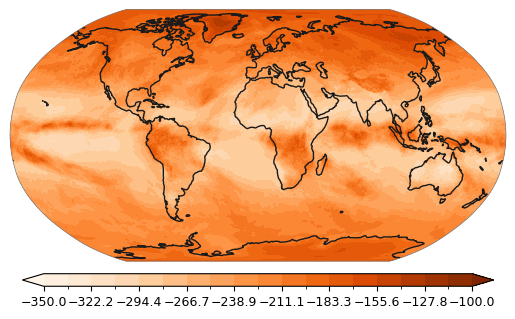

In [24]:
from utils import plot
import xarray as xr
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    target_surface[0, 9, 0, :, :].cpu().numpy(),
    coords=[("lat", lat), ("lon", lon)],
    name="avg_tnlwrf"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-350, -100, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap='Oranges', mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


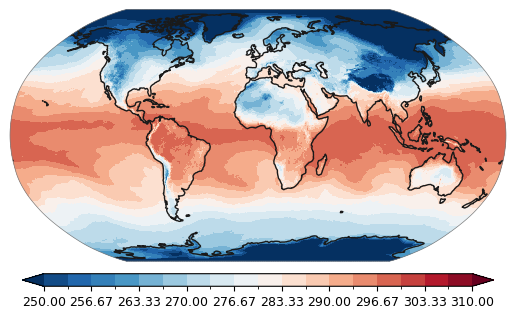

In [19]:
from utils import plot
import xarray as xr
import cmaps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    target_surface[0, 7, 0, :, :].cpu().numpy(),
    coords=[("lat", lat), ("lon", lon)],
    name="t2m"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(250, 310, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap='RdBu_r', mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


In [41]:
target_upper_air.shape

torch.Size([1, 17, 1, 721, 1440])

/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


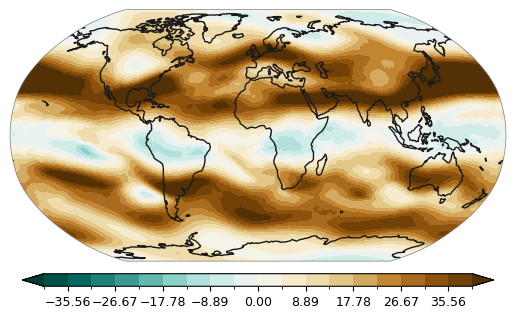

In [43]:
from utils import plot
import xarray as xr
import cmaps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    target_upper_air[0, 2, 0, 0, :, :].cpu().numpy(),
    coords=[("lat", lat), ("lon", lon)],
    name="200u"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-40, 40, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap='BrBG_r', mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


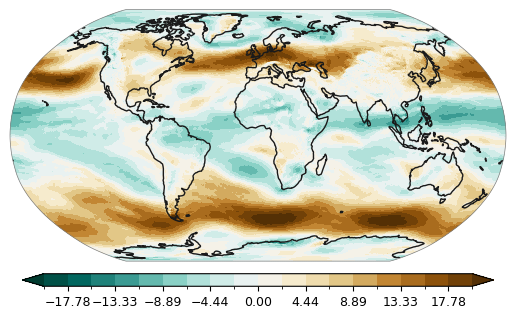

In [46]:
from utils import plot
import xarray as xr
import cmaps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    target_upper_air[0, 2, 4, 0, :, :].cpu().numpy(),
    coords=[("lat", lat), ("lon", lon)],
    name="850u"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-20, 20, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap='BrBG_r', mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# 变量列表及其统计信息
variables = [
    'lsrr',               # Large-scale precipitation rate
    'crr',                # Convective precipitation rate
    'tciw',               # Specific cloud ice
    'tcc',                # Total cloud cover
    'tsrc',               # Top net long-wave radiation flux
    'u10',                # 10m u wind component
    'v10',                # 10m v wind component
    'd2m',                # 2m dewpoint temperature
    't2m',                # 2m temperature
    'surface_latent_heat_flux',  # Surface latent heat flux
    'surface_sensible_heat_flux',  # Surface sensible heat flux
    'sp',                 # Surface pressure
    'swvl',               # Volumetric soil water
    'msl',                # Sea-level pressure
    'siconc',             # Sea ice
    'sst'                 # Sea surface temperature
]

# 变量的均值和标准差
var_stats = {
    'surface_latent_heat_flux': {'mean': -5410301.5, 'std': 5349063.5},
    'u10': {'mean': -0.068418466, 'std': 4.427545547},
    'd2m': {'mean': 274.2094421, 'std': 20.45770073},
    'msl': {'mean': 100972.3438, 'std': 1191.102417},
    'tsrc': {'mean': 856148, 'std': 534222.125},
    'crr': {'mean': 1.29E-05, 'std': 2.97E-05},
    'lsrr': {'mean': 1.10E-05, 'std': 2.55E-05},
    'siconc': {'mean': 0.785884917, 'std': 0.914535105},
    'tciw': {'mean': 0.022627383, 'std': 0.023428712},
    'swvl': {'mean': 0.34216917, 'std': 0.5484813},
    'v10': {'mean': 0.197138891, 'std': 3.09530735},
    't2m': {'mean': 278.7841187, 'std': 21.03286934},
    'surface_sensible_heat_flux': {'mean': -971651.375, 'std': 2276764.75},
    'tcc': {'mean': 0.673692584, 'std': 0.235167906},
    'sp': {'mean': 96651.14063, 'std': 9569.695313},
    'sst': {'mean': 189.7337189, 'std': 136.1803131}
}

class WeatherTestDataset(Dataset):
    def __init__(self, surface_data, upper_air_data, start_idx, end_idx):
        """
        初始化测试数据集
        
        参数:
            surface_data: 表面数据，形状为 [16, 100, 721, 1440]
            upper_air_data: 高空数据，形状为 [7, 4, 100, 721, 1440]
            start_idx: 开始索引
            end_idx: 结束索引
        """
        self.surface_data = surface_data[:, start_idx:end_idx]
        self.upper_air_data = upper_air_data[:, :, start_idx:end_idx]
        self.length = end_idx - start_idx - 2  # 减2确保有足够的目标数据
        
        print(f"Test dataset from index {start_idx} to {end_idx}, sample count: {self.length}")
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        # 提取输入数据 (t和t+1时刻)
        input_surface = self.surface_data[:, idx:idx+2]  # [1, 16, 2, 721, 1440]
        
        # 提取高空数据 (t和t+1时刻)
        input_upper_air = self.upper_air_data[:, :, idx:idx+2]  # [1, 7, 4, 2, 721, 1440]
        
        # 提取目标数据 (t+2时刻)
        target_surface = self.surface_data[:, idx+2]  # [1, 16, 721, 1440]
        
        return input_surface, input_upper_air, target_surface, idx

def denormalize(data, var_idx):
    """反标准化数据"""
    var_name = variables[var_idx]
    mean = var_stats[var_name]['mean']
    std = var_stats[var_name]['std']
    return data * std + mean

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载数据
print("Loading data...")
input_surface_load = torch.load('I:/ERA5_np/input_surface_norm_test_last100.pt')
input_upper_air_load = torch.load('I:/ERA5_np/input_upper_air_norm_test_last100.pt')
print(f"Surface data shape: {input_surface_load.shape}")
print(f"Upper air data shape: {input_upper_air_load.shape}")

Using device: cuda
Loading data...
Surface data shape: torch.Size([16, 100, 721, 1440])
Upper air data shape: torch.Size([7, 4, 100, 721, 1440])


In [30]:
input_surface_load.shape
total_rain = denormalize(input_surface_load[variables.index('lsrr'), :, :, :], variables.index('lsrr')) + denormalize(input_surface_load[variables.index('crr'), :, :, :], variables.index('crr'))
total_rain.shape
# 使用torch.mean代替np.mean，因为total_rain是torch.Tensor
total_rain_mean = torch.mean(total_rain, dim=0).numpy()

total_rain_mean.shape

(721, 1440)

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats
# 计算测试集的索引范围 (使用后20%)
total_samples = 100  # 假设为100
test_start = int(total_samples * 0.2)  # 80
test_end = total_samples  # 100

# 创建测试数据集
test_dataset = WeatherTestDataset(input_surface_load, input_upper_air_load, test_start, test_end)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(f"Created test data loader with {len(test_dataset)} samples")

# 加载模型
model_path = 'I:/model/model_v1_100.pth'  # 使用最佳模型
print(f"Loading model from {model_path}...")
model = torch.load(model_path)
print("Complete model loaded successfully")
lsrr_idx = variables.index('lsrr')  # 大尺度降水率索引
crr_idx = variables.index('crr')    # 对流降水率索引
var_idx = variables.index('sst')

model.to(device)
model.eval()  
predictions = []
targets = []
indices = []
pcc_values = []  # 存储每个样本的PCC值
acc_values = []  # 存储每个样本的ACC值

with torch.no_grad():
    for input_surface, input_upper_air, target_surface, idx in test_loader:
        # 将数据移动到设备
        input_surface = input_surface.to(device)
        input_upper_air = input_upper_air.to(device)
        
        # 前向传播
        output_surface, _ = model(input_surface, input_upper_air)
        
        # 收集结果
        predictions.append(output_surface.cpu())
        targets.append(target_surface.cpu())
        indices.append(idx.item())

        first_sample_idx = int(idx)  # 取第一个样本
        # 反标准化第一个样本的预测降水率
        pred_lsrr = denormalize(predictions[first_sample_idx][0, lsrr_idx, 0].numpy(), lsrr_idx)
        pred_crr = denormalize(predictions[first_sample_idx][0, crr_idx, 0].numpy(), crr_idx)
        pred_total_precip = pred_lsrr + pred_crr  # 总降水率

        # 反标准化第一个样本的真实降水率
        true_lsrr = denormalize(targets[first_sample_idx][0, lsrr_idx].numpy(), lsrr_idx)
        true_crr = denormalize(targets[first_sample_idx][0, crr_idx].numpy(), crr_idx)
        true_total_precip = true_lsrr + true_crr  # 总降水率

        pre_var = denormalize(predictions[first_sample_idx][0, var_idx, 0].numpy(), var_idx)
        true_var = denormalize(targets[first_sample_idx][0, var_idx].numpy(), var_idx)

        # 计算并存储PCC和ACC
        pcc, _ = stats.pearsonr(true_total_precip.flatten(), pred_total_precip.flatten())
        acc, _ = stats.pearsonr(true_total_precip.flatten() - total_rain_mean.flatten(), pred_total_precip.flatten() - total_rain_mean.flatten())
        pcc_values.append(pcc)
        acc_values.append(acc)
        
        print(f"Correlation Coefficients - PCC: {pcc:.8f}, ACC: {acc:.8f}")
        # if int(idx) == 0:
        #     break

# 计算平均PCC和ACC
avg_pcc = sum(pcc_values) / len(pcc_values)
avg_acc = sum(acc_values) / len(acc_values)
print(f"\nAverage Correlation Coefficients across test set:")
print(f"Average PCC: {avg_pcc:.8f}")
print(f"Average ACC: {avg_acc:.8f}")


Test dataset from index 20 to 100, sample count: 78
Created test data loader with 78 samples
Loading model from I:/model/model_v1_100.pth...
Complete model loaded successfully
Correlation Coefficients - PCC: 0.48583440, ACC: 0.17387418
Correlation Coefficients - PCC: 0.48724304, ACC: 0.20856283
Correlation Coefficients - PCC: 0.54709221, ACC: 0.30468506
Correlation Coefficients - PCC: 0.47020556, ACC: 0.20940591
Correlation Coefficients - PCC: 0.53178103, ACC: 0.28364254
Correlation Coefficients - PCC: 0.44106116, ACC: 0.20490520
Correlation Coefficients - PCC: 0.43211491, ACC: 0.17439806
Correlation Coefficients - PCC: 0.46407052, ACC: 0.25934573
Correlation Coefficients - PCC: 0.41004729, ACC: 0.17037049
Correlation Coefficients - PCC: 0.43909521, ACC: 0.21248419
Correlation Coefficients - PCC: 0.45740376, ACC: 0.24589529
Correlation Coefficients - PCC: 0.43707267, ACC: 0.22459119
Correlation Coefficients - PCC: 0.41410398, ACC: 0.16570204
Correlation Coefficients - PCC: 0.50319403, 

In [14]:
# 反标准化第一个样本的预测结果和真实值
print("Denormalizing results...")
first_sample_idx = 0  # 取第一个样本

lsrr_idx = variables.index('lsrr')  # 大尺度降水率索引
crr_idx = variables.index('crr')    # 对流降水率索引
# 反标准化第一个样本的预测降水率
pred_lsrr = denormalize(predictions[first_sample_idx][0, lsrr_idx, 0].numpy(), lsrr_idx)
pred_crr = denormalize(predictions[first_sample_idx][0, crr_idx, 0].numpy(), crr_idx)
pred_total_precip = pred_lsrr + pred_crr  # 总降水率

# 反标准化第一个样本的真实降水率
true_lsrr = denormalize(targets[first_sample_idx][0, lsrr_idx].numpy(), lsrr_idx)
true_crr = denormalize(targets[first_sample_idx][0, crr_idx].numpy(), crr_idx)
true_total_precip = true_lsrr + true_crr  # 总降水率



# 计算统计指标
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats

mse = mean_squared_error(true_total_precip.flatten(), pred_total_precip.flatten())
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_total_precip.flatten(), pred_total_precip.flatten())

# 计算PCC空间相关性系数
pcc, _ = stats.pearsonr(true_total_precip.flatten(), pred_total_precip.flatten())

print("\nStatistical Metrics for Total Precipitation Rate:")
print(f"Root Mean Square Error (RMSE): {rmse:.8f} m/s")
print(f"Mean Absolute Error (MAE): {mae:.8f} m/s")
print(f"Pearson Correlation Coefficient (PCC): {pcc:.8f}")


Denormalizing results...

Statistical Metrics for Total Precipitation Rate:
Root Mean Square Error (RMSE): 0.00005251 m/s
Mean Absolute Error (MAE): 0.00002508 m/s
Pearson Correlation Coefficient (PCC): 0.39416888


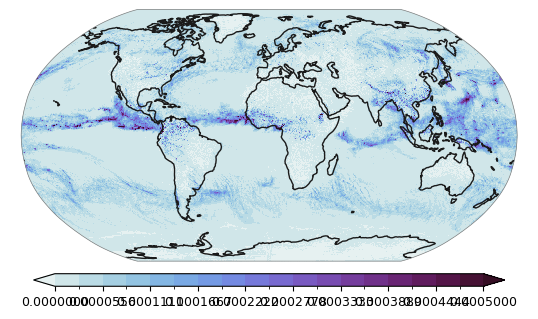

In [15]:
from utils import plot
import xarray as xr
import cmaps
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    pred_total_precip,
    coords=[("lat", lat), ("lon", lon)],
    name="sst"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 0.0005, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap=cmaps.cmocean_dense, mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


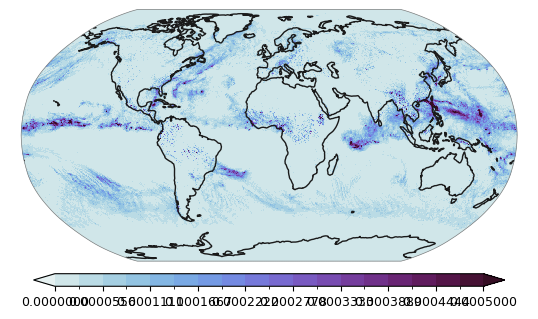

In [16]:
from utils import plot
import xarray as xr
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    true_total_precip,
    coords=[("lat", lat), ("lon", lon)],
    name="sst"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 0.0005, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap=cmaps.cmocean_dense, mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


## v2中等数据

In [27]:
output_surface, output_upper_air = model(input_surface, input_upper_air)

In [28]:
output_upper_air.shape

torch.Size([1, 7, 4, 2, 721, 1440])

In [29]:
output_surface.shape

torch.Size([1, 16, 2, 721, 1440])

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 设置滚动预报的周数
week = 3  # 预测未来3周

# 变量列表及其统计信息
variables = [
    'lsrr',               # Large-scale precipitation rate
    'crr',                # Convective precipitation rate
    'tciw',               # Specific cloud ice
    'tcc',                # Total cloud cover
    'tsrc',               # Top net long-wave radiation flux
    'u10',                # 10m u wind component
    'v10',                # 10m v wind component
    'd2m',                # 2m dewpoint temperature
    't2m',                # 2m temperature
    'surface_latent_heat_flux',  # Surface latent heat flux
    'surface_sensible_heat_flux',  # Surface sensible heat flux
    'sp',                 # Surface pressure
    'swvl',               # Volumetric soil water
    'msl',                # Sea-level pressure
    'siconc',             # Sea ice
    'sst'                 # Sea surface temperature
]

# 变量的均值和标准差
var_stats = {
    'surface_latent_heat_flux': {'mean': -5410301.5, 'std': 5349063.5},
    'u10': {'mean': -0.068418466, 'std': 4.427545547},
    'd2m': {'mean': 274.2094421, 'std': 20.45770073},
    'msl': {'mean': 100972.3438, 'std': 1191.102417},
    'tsrc': {'mean': 856148, 'std': 534222.125},
    'crr': {'mean': 1.29E-05, 'std': 2.97E-05},
    'lsrr': {'mean': 1.10E-05, 'std': 2.55E-05},
    'siconc': {'mean': 0.785884917, 'std': 0.914535105},
    'tciw': {'mean': 0.022627383, 'std': 0.023428712},
    'swvl': {'mean': 0.34216917, 'std': 0.5484813},
    'v10': {'mean': 0.197138891, 'std': 3.09530735},
    't2m': {'mean': 278.7841187, 'std': 21.03286934},
    'surface_sensible_heat_flux': {'mean': -971651.375, 'std': 2276764.75},
    'tcc': {'mean': 0.673692584, 'std': 0.235167906},
    'sp': {'mean': 96651.14063, 'std': 9569.695313},
    'sst': {'mean': 189.7337189, 'std': 136.1803131}
}

class WeatherTestDataset(Dataset):
    def __init__(self, surface_data, upper_air_data, start_idx, end_idx, forecast_week=3):
        """
        初始化测试数据集
        
        参数:
            surface_data: 表面数据，形状为 [16, 100, 721, 1440]
            upper_air_data: 高空数据，形状为 [7, 4, 100, 721, 1440]
            start_idx: 开始索引
            end_idx: 结束索引
            forecast_week: 预测的周数，默认为3周
        """
        self.surface_data = surface_data[:, start_idx:end_idx]
        self.upper_air_data = upper_air_data[:, :, start_idx:end_idx]
        self.forecast_week = forecast_week
        self.length = end_idx - start_idx - forecast_week  # 确保有足够的目标数据
        
        print(f"Test dataset from index {start_idx} to {end_idx}, forecast week: {forecast_week}, sample count: {self.length}")
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        # 提取输入数据 (t和t+1时刻)
        input_surface = self.surface_data[:, idx:idx+2]  # [1, 16, 2, 721, 1440]
        
        # 提取高空数据 (t和t+1时刻)
        input_upper_air = self.upper_air_data[:, :, idx:idx+2]  # [1, 7, 4, 2, 721, 1440]
        
        # 提取目标数据 (t+forecast_week时刻)
        target_surface = self.surface_data[:, idx+self.forecast_week]  # [1, 16, 721, 1440]
        
        return input_surface, input_upper_air, target_surface, idx

def denormalize(data, var_idx):
    """反标准化数据"""
    var_name = variables[var_idx]
    mean = var_stats[var_name]['mean']
    std = var_stats[var_name]['std']
    return data * std + mean

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载数据
print("Loading data...")
input_surface_load = torch.load('I:/ERA5_np/input_surface_norm_test_last100.pt')
input_upper_air_load = torch.load('I:/ERA5_np/input_upper_air_norm_test_last100.pt')
print(f"Surface data shape: {input_surface_load.shape}")
print(f"Upper air data shape: {input_upper_air_load.shape}")

Using device: cuda
Loading data...
Surface data shape: torch.Size([16, 100, 721, 1440])
Upper air data shape: torch.Size([7, 4, 100, 721, 1440])


In [4]:
input_surface_load.shape
total_rain = denormalize(input_surface_load[variables.index('lsrr'), :, :, :], variables.index('lsrr')) + denormalize(input_surface_load[variables.index('crr'), :, :, :], variables.index('crr'))
total_rain.shape
# 使用torch.mean代替np.mean，因为total_rain是torch.Tensor
total_rain_mean = torch.mean(total_rain, dim=0).numpy()

total_rain_mean.shape

(721, 1440)

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats
# 计算测试集的索引范围 (使用后20%)
total_samples = 100  # 假设为100
test_start = int(total_samples * 0.8)  # 80
test_end = total_samples  # 100

# 创建测试数据集
test_dataset = WeatherTestDataset(input_surface_load, input_upper_air_load, test_start, test_end, forecast_week=3)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(f"Created test data loader with {len(test_dataset)} samples")

# 加载模型
model_path = 'I:/model/model_epoch_500.pt'  # 使用最佳模型
print(f"Loading model from {model_path}...")
model = torch.load(model_path)
print("Complete model loaded successfully")
lsrr_idx = variables.index('lsrr')  # 大尺度降水率索引
crr_idx = variables.index('crr')    # 对流降水率索引
var_idx = variables.index('sst')

model.to(device)
model.eval()  
predictions = []
targets = []
indices = []
pcc_values = []  # 存储每个样本的PCC值
acc_values = []  # 存储每个样本的ACC值
week = 3  # 设置滚动预报的周数

with torch.no_grad():
    for input_surface, input_upper_air, target_surface, idx in test_loader:
        # 将数据移动到设备
        input_surface = input_surface.to(device)
        input_upper_air = input_upper_air.to(device)
        target_surface = target_surface.to(device)
        
        # 存储滚动预报的结果
        all_surface_predictions = []
        all_upper_air_predictions = []
        
        # 初始输入
        current_input_surface = input_surface.clone()
        current_input_upper_air = input_upper_air.clone()
        
        # 滚动预报week周
        for w in range(week):
            # 前向传播
            output_surface, output_upper_air = model(current_input_surface, current_input_upper_air)
            
            # 存储当前周的预测结果
            all_surface_predictions.append(output_surface[:, :, 0:1, :, :])  # 只取第一个时间步
            all_upper_air_predictions.append(output_upper_air[:, :, :, 0:1, :, :])  # 只取第一个时间步
            
            if w < week - 1:  # 如果不是最后一周，准备下一周的输入
                # 更新输入：使用上一个时间步和新预测的时间步
                new_input_surface = torch.cat([
                    current_input_surface[:, :, 1:2, :, :],  # 取当前输入的第二个时间步
                    output_surface[:, :, 0:1, :, :]  # 取当前预测的第一个时间步
                ], dim=2)
                
                new_input_upper_air = torch.cat([
                    current_input_upper_air[:, :, :, 1:2, :, :],  # 取当前输入的第二个时间步
                    output_upper_air[:, :, :, 0:1, :, :]  # 取当前预测的第一个时间步
                ], dim=3)
                
                current_input_surface = new_input_surface
                current_input_upper_air = new_input_upper_air
        
        # 合并所有周的预测结果
        combined_surface_predictions = torch.cat(all_surface_predictions, dim=2)  # [1, 16, week, 721, 1440]
        
        # 收集第三周的预测结果（索引为2）
        predictions.append(all_surface_predictions[week-1].cpu())  # 取最后一周的预测
        targets.append(target_surface.cpu())
        indices.append(idx.item())

        # 反标准化第三周的预测降水率
        pred_lsrr = denormalize(all_surface_predictions[week-1][0, lsrr_idx, 0].cpu().numpy(), lsrr_idx)
        pred_crr = denormalize(all_surface_predictions[week-1][0, crr_idx, 0].cpu().numpy(), crr_idx)
        pred_total_precip = pred_lsrr + pred_crr  # 总降水率

        # 反标准化真实降水率
        true_lsrr = denormalize(target_surface[0, lsrr_idx].cpu().numpy(), lsrr_idx)
        true_crr = denormalize(target_surface[0, crr_idx].cpu().numpy(), crr_idx)
        true_total_precip = true_lsrr + true_crr  # 总降水率

        pre_var = denormalize(all_surface_predictions[week-1][0, var_idx, 0].cpu().numpy(), var_idx)
        true_var = denormalize(target_surface[0, var_idx].cpu().numpy(), var_idx)

        
        pcc, _ = stats.pearsonr(true_total_precip.flatten(), pred_total_precip.flatten())
        acc, _ = stats.pearsonr(true_total_precip.flatten() - total_rain_mean.flatten(), pred_total_precip.flatten() - total_rain_mean.flatten())
        pcc_values.append(pcc)
        acc_values.append(acc)
        
        print(f"Sample {idx.item()}, Week {week} - Correlation Coefficients - PCC: {pcc:.8f}, ACC: {acc:.8f}")

# 计算平均PCC和ACC (基于第三周的预测)
avg_pcc = sum(pcc_values) / len(pcc_values)
avg_acc = sum(acc_values) / len(acc_values)
print(f"\nAverage Correlation Coefficients across test set (Week {week}):")
print(f"Average PCC: {avg_pcc:.8f}")
print(f"Average ACC: {avg_acc:.8f}")
print(f"Successfully generated {week}-week rolling forecasts for all test samples")


Test dataset from index 80 to 100, forecast week: 3, sample count: 17
Created test data loader with 17 samples
Loading model from I:/model/model_epoch_500.pt...
Complete model loaded successfully
Sample 0, Week 3 - Correlation Coefficients - PCC: 0.46968061, ACC: 0.23212582
Sample 1, Week 3 - Correlation Coefficients - PCC: 0.43441446, ACC: 0.17349164
Sample 2, Week 3 - Correlation Coefficients - PCC: 0.46679058, ACC: 0.21522253
Sample 3, Week 3 - Correlation Coefficients - PCC: 0.46328837, ACC: 0.18437735
Sample 4, Week 3 - Correlation Coefficients - PCC: 0.41708312, ACC: 0.11546501
Sample 5, Week 3 - Correlation Coefficients - PCC: 0.42880533, ACC: 0.12602720
Sample 6, Week 3 - Correlation Coefficients - PCC: 0.42973204, ACC: 0.12616163
Sample 7, Week 3 - Correlation Coefficients - PCC: 0.42454746, ACC: 0.13722814
Sample 8, Week 3 - Correlation Coefficients - PCC: 0.42188281, ACC: 0.13132383
Sample 9, Week 3 - Correlation Coefficients - PCC: 0.48622649, ACC: 0.18757532
Sample 10, Wee

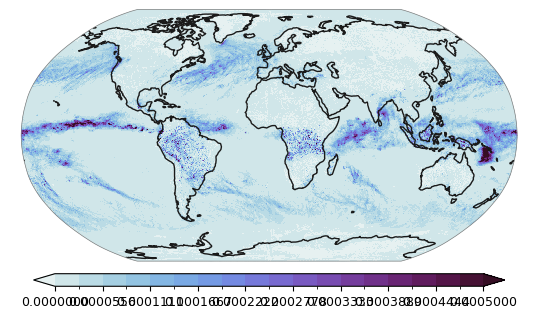

In [7]:
from utils import plot
import xarray as xr
import cmaps
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    pred_total_precip,
    coords=[("lat", lat), ("lon", lon)],
    name="sst"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 0.0005, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap=cmaps.cmocean_dense, mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


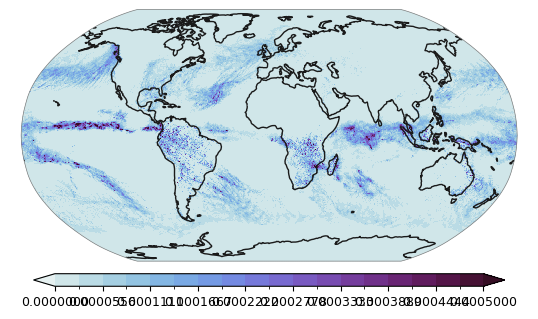

In [8]:
from utils import plot
import xarray as xr
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    true_total_precip,
    coords=[("lat", lat), ("lon", lon)],
    name="sst"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 0.0005, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap=cmaps.cmocean_dense, mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)
